In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')
data_heatmap_new1 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')
data_heatmap_new2 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')

In [3]:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded_new1 = data_heatmap_new1.loc[data_heatmap_new1.index.repeat(data_heatmap_new1['clicks'])].reset_index(drop=True)
data_heatmap_expanded_new2 = data_heatmap_new2.loc[data_heatmap_new2.index.repeat(data_heatmap_new2['clicks'])].reset_index(drop=True)

In [4]:
click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()
click_stat_new1 = data_heatmap_expanded_new1.groupby(['click_x','click_y'])['clicks'].count().reset_index()
click_stat_new2 = data_heatmap_expanded_new2.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [5]:
data_heatmap_expanded['clicks'] = 1
data_heatmap_expanded_new1['clicks'] = 1
data_heatmap_expanded_new2['clicks'] = 1

In [32]:
data_heatmap_expanded_new2

Unnamed: 0   domain  grid_id  click_x  click_y  display_height  \
0           2000000  ID_2674   333346       62      137             250   
1           2000001  ID_2674   333346       66       93             250   
2           2000002  ID_2674   333346      249      154             250   
3           2000003  ID_2674   333346       86      156             250   
4           2000004  ID_2674   333346       71      131             250   
...             ...      ...      ...      ...      ...             ...   
3824351     4075995  ID_1220   333346       65      127             250   
3824352     4075995  ID_1220   333346       65      127             250   
3824353     4075995  ID_1220   333346       65      127             250   
3824354     4075995  ID_1220   333346       65      127             250   
3824355     4075995  ID_1220   333346       65      127             250   

         display_width  clicks  click_x_rel  click_y_rel  
0                  300       1          8.0         22.0  
1                  300       1          9.0         15.0  
2                  300       1         33.0         25.0  
3                  300       1         11.0         25.0  
4                  300       1          9.0         21.0  
...                ...     ...          ...          ...  
3824351            300       1          9.0         20.0  
3824352            300       1          9.0         20.0  
3824353            300       1          9.0         20.0  
3824354            300       1          9.0         20.0  
3824355            300       1          9.0         20.0  

[3824356 rows x 10 columns]

# Visualize new data

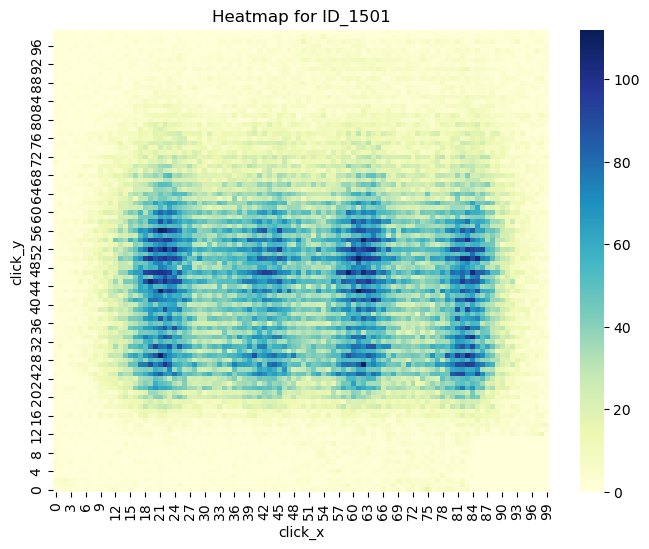

In [6]:
x = data_heatmap_expanded_new2[(data_heatmap_expanded_new2.grid_id == 333346) & 
                          (data_heatmap_expanded_new2.domain == 'ID_3516')]

heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[100, 100])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1501')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() # Invert y-axis to match the coordinate system
plt.show()

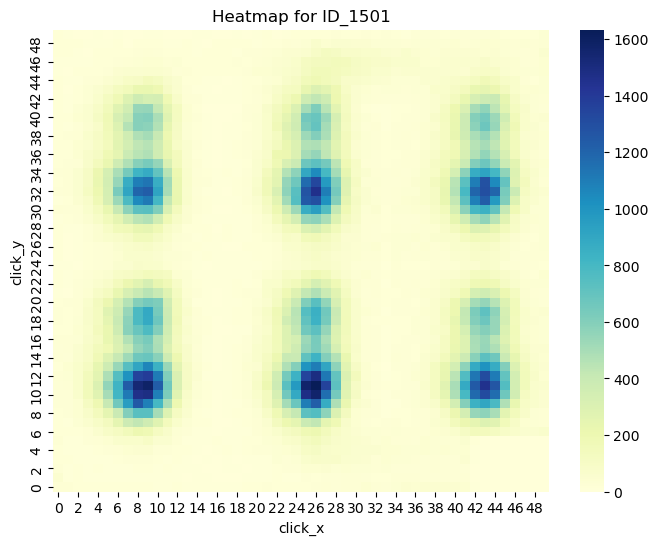

In [7]:
x = data_heatmap_expanded_new2[(data_heatmap_expanded_new2.grid_id == 333519) & 
                          (data_heatmap_expanded_new2.domain == 'ID_3516')]
heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[50, 50])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1501')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() # Invert y-axis to match the coordinate system
plt.show()

# Some Data wrangling

In [8]:
data_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)

max_width = data_expanded['display_width'].max()
max_height = data_expanded['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded['click_x_bin'] = pd.cut(data_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded['click_y_bin'] = pd.cut(data_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()


aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [9]:
cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

# Basic Bootstrap approach

In [10]:
def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    
    # resample heatmap of size = size n_bootstrap times
    for _ in range(n_bootstraps):
        # draw samples from drawing_distro column:
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        
        # compute log-probability for current sample based on emp_distro column:
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        
        # cumulative log-probability
        tot_log_proba += log_proba
        
    # compute and return average log-probability:
    return tot_log_proba/n_bootstraps

In [11]:
def weighted_jittered_bootstrap_resample(data, drawing_distro, total_data_size, stdev=2):
    tot_log_proba = 0
    pert_x = np.random.normal(0, stdev, total_data_size).round().astype(int)
    pert_y = np.random.normal(0, stdev, total_data_size).round().astype(int)
    indices = np.random.choice(data.index, 
                               total_data_size, 
                               replace=True, 
                               p=data[drawing_distro])
    
    log_proba = np.log(data.loc[indices][emp_distro]).sum()
    tot_log_proba += log_proba
    return tot_log_proba/n_bootstraps #boots[['click_x_bin','click_y_bin', 'boot']]

# Basic Chi-squared test

In [12]:
from scipy.stats import chisquare

def Chi_squared_test(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]

    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    # Perform Chi-square test
    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Data enhancement

In [13]:
from itertools import product

def enhance_data(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

# Chi-squared test with bootstrapped enhancement:

In [14]:
def Chi_squared_test_enh(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID, samp_size, stdev):
    
    # observed heatmap domain = ID and grid_id = GRID_ID:
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]
    
    observed['proba'] = observed['clicks_sum']/observed['clicks_sum'].sum()
    
    # bootstrap enhance data to samp_size with stdev:
    observed = enhance_data(observed, 'proba', samp_size, stdev)
    
    # empirical distribution + probabilities for grid_id=GRID_ID
    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                                   on=['click_x_bin',
                                                       'click_y_bin'], 
                                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

In [18]:
# save domains by grid id:
domains_by_grid_id = pd.DataFrame(aggregated_clicks.groupby('grid_id')['domain'].unique()).reset_index()

In [34]:
data_bad = data.copy()

In [36]:
data_bad.proba = 1/data_bad.shape[0]

In [95]:
len(cb_333519+cb_333346+cb_333346_6p+cb_333519_6p)

330

In [44]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

cb_333346_6p = ['ID_106', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_136', 
             'ID_1542', 'ID_1589', 'ID_1602', 'ID_185', 'ID_1908', 'ID_1915', 
             'ID_1916', 'ID_1971',  'ID_2015', 'ID_2063', 'ID_2133', 'ID_2143', 
             'ID_2336', 'ID_2337', 'ID_2368', 'ID_243', 'ID_245', 'ID_2553', 
             'ID_2564', 'ID_2635', 'ID_2636', 'ID_267', 'ID_2693', 'ID_27', 
             'ID_2737', 'ID_2750', 'ID_2762', 'ID_2867', 'ID_2924', 'ID_2933', 
             'ID_2977', 'ID_3172', 'ID_3219', 'ID_324', 'ID_3268', 'ID_333', 
             'ID_3334', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567', 'ID_3605', 
             'ID_362', 'ID_3633', 'ID_3640', 'ID_365', 'ID_367', 'ID_3672', 
             'ID_3699', 'ID_3730', 'ID_3809', 'ID_3837', 'ID_3848', 'ID_3920', 
             'ID_3939', 'ID_3982', 'ID_401', 'ID_4042', 'ID_4058', 'ID_4072', 
             'ID_4076', 'ID_4199', 'ID_4206', 'ID_4224', 'ID_4378', 'ID_4507', 
             'ID_466', 'ID_494', 'ID_539', 'ID_62', 'ID_727', 'ID_737', 
             'ID_861', 'ID_876', 'ID_889', 'ID_90', 'ID_922', 'ID_949', 
             'ID_981', 'ID_993']

cb_333519_6p = ['ID_1081', 'ID_1150', 'ID_1464', 'ID_1518', 'ID_1622', 'ID_1623', 
                'ID_1624', 'ID_1631', 'ID_1678', 'ID_1623', 'ID_1731', 'ID_1752', 
                'ID_1764', 'ID_1795', 'ID_1915', 'ID_1916', 'ID_1971', 'ID_198', 
                'ID_2018', 'ID_204', 'ID_2044', 'ID_2104', 'ID_2108', 'ID_2109', 
                'ID_2146', 'ID_2251', 'ID_2330', 'ID_2336', 'ID_2381', 'ID_2383', 
                'ID_2400', 'ID_2616', 'ID_2636', 'ID_2749', 'ID_2766', 'ID_2779', 
                'ID_2809', 'ID_284', 'ID_2875', 'ID_2881', 'ID_30', 'ID_3021', 
                'ID_3049', 'ID_3098', 'ID_3178', 'ID_3183', 'ID_3219', 'ID_3232', 
                'ID_3561', 'ID_3644', 'ID_365', 'ID_3850', 'ID_389', 'ID_4025', 
                'ID_4036', 'ID_4050', 'ID_4058', 'ID_4075', 'ID_4113', 'ID_4122', 
                'ID_4255', 'ID_4257', 'ID_4275', 'ID_4347', 'ID_44', 'ID_4506', 
                'ID_4567', 'ID_618', 'ID_727', 'ID_737', 'ID_922', 'ID_950', 
                'ID_960', 'ID_969']

In [46]:
cb = {333519: cb_333519, 333346: cb_333346}
cb_6p = {333519: cb_333519_6p, 333346: cb_333346_6p}

# Emp distro = cumulative

In [55]:
# upsampling size:
size = 1000

# stdev for noisy bootstrap enhancement:
stdev = 0

# init to count pct of broken banners:
tot_p, tot, tot_pv, tot_lrt = 0, 0, 0, 0

# keep track of misidentified:
misid = {}

# p-value threshold for chi-squared test:
pv_thresh = 0.0000001

# probability threshold:
# proba_thres = 0.0000001

for proba_thres in [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]:
    
    misid[proba_thres] = {'FN': [], 'FP': []}
    TP, TN, FP, FN = 0, 0, 0, 0
    
    for g_id in [333519, 333346]: 

        # data = all clicks for grid_id = g_id (in principle should probably do some train/test split):
        data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

        # compute probability by bin
        data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

        '''
        compute probability for "average" heatmap based on bootstrap sampling of data. 

        The empirical distribution is given by the proba columns and we bootstrap
        sample based on that column as well as evaluate the log-probability.

        The bootstrapped sample is of size = size (notice that the size should be 
        the same as the size for the instance-heatmap to get "fair" comparison, if not
        we would have to normalize accordingly).

        n_bootstrap = number of generated heatmaps to compute average.

        The following returns the avg log-probability:
        '''
        avg_from_empirical = weighted_bootstrap_resample(data, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)

        avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)


        # run over domains, dom for given grid_id = g_id:
        for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
            tot += 1

            ####################
            # chi-squared method:
            # returns p-value for chi-squared comparison of heatmap vs empirical distribution
            _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
                                                  aggregated_clicks_by_grid, 
                                                  dom, g_id, size, .5)

            ####################
            # log-probability method:

            # data_obs = "observed" heatmap for current domain_id = dom
            data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                         (aggregated_clicks.domain == dom)]

            # add proba column in order to do bootstrap enhancement:
            data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

            # enhanced observed heatmap of size = size, with stdev = stdev 
            # and sampling based on proba column:
            data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

            # merge enhanced observed heatmap with empirical distribution
            # in order to get empircal probabilities for bins:
            data_obs = data_obs_enh.merge(data, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
            from_obs = (np.log(data_obs['proba'])*data_obs['clicks_sum_x']).sum()

            # compare with average heatmap from empirical distribution:
            # prob = P[distr for domain]/P[avg distr]
            prob = np.exp(from_obs - avg_from_empirical)
            log_prob = from_obs - avg_from_empirical

            # if log_prob below certain threshold, label as broken:

            if log_prob < np.log(proba_thres):
                tot_p +=1

            # compare both log-prob and chi-squared p-value:
            if log_prob < np.log(proba_thres) and pv < pv_thresh:
                tot_pv += 1

            ####################
            # "lrt" method:

            data_obs_bad = data_obs_enh.merge(data_bad, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            from_obs_bad = (np.log(data_obs_bad['proba'])*data_obs_bad['clicks_sum_x']).sum()

            loglrt = from_obs - from_obs_bad

            if loglrt < np.log(proba_thres):
                tot_lrt += 1
                if dom in cb[g_id]:
                    TP += 1
                else:
                    FP += 1
                    misid[proba_thres]['FP'].append(dom)
            else:
                if dom in cb[g_id]:
                    FN += 1
                    misid[proba_thres]['FN'].append(dom)
                else:
                    TN += 1

    print(f'Probability thresh: {proba_thres}')
    print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
    print('-----------------------------------------------------------')
            

Probability thresh: 0.1
Confusion matrix: ((TN,FN),(FP,TP)) = (1556,59),(7,111)
-----------------------------------------------------------
Probability thresh: 0.01
Confusion matrix: ((TN,FN),(FP,TP)) = (1557,59),(6,111)
-----------------------------------------------------------
Probability thresh: 0.001
Confusion matrix: ((TN,FN),(FP,TP)) = (1556,62),(7,108)
-----------------------------------------------------------
Probability thresh: 0.0001
Confusion matrix: ((TN,FN),(FP,TP)) = (1556,57),(7,113)
-----------------------------------------------------------
Probability thresh: 1e-05
Confusion matrix: ((TN,FN),(FP,TP)) = (1556,60),(7,110)
-----------------------------------------------------------
Probability thresh: 1e-06
Confusion matrix: ((TN,FN),(FP,TP)) = (1557,59),(6,111)
-----------------------------------------------------------
Probability thresh: 1e-07
Confusion matrix: ((TN,FN),(FP,TP)) = (1555,59),(8,111)
-----------------------------------------------------------
Probabil

In [100]:
TN,FN,FP,TP = 1557,59,6,111

prec = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*prec*recall/(prec+recall)

print(prec,recall,F1)

0.9487179487179487 0.6529411764705882 0.7735191637630662


In [84]:
unique_gd_comb = data_heatmap.groupby(['grid_id','domain']).size().reset_index(name='Freq')[['grid_id','domain']]

In [ ]:
# cb_333346 = cb_333346+['ID_2274','ID_2198','ID_962', 'ID_657']

aasdfasdfasdfasdf


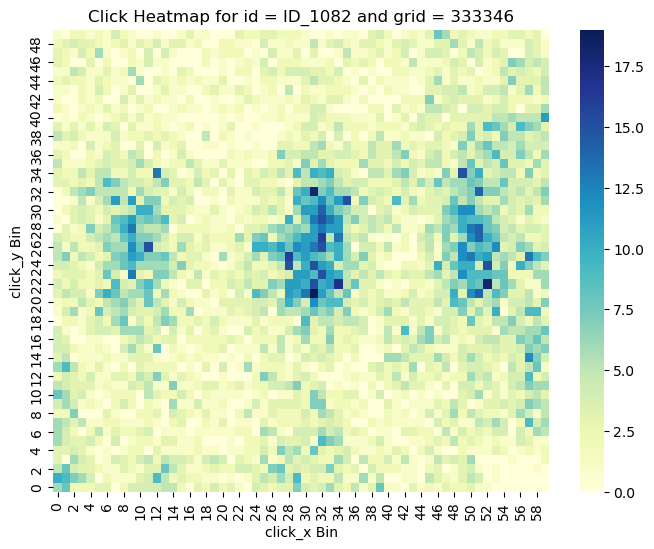

aasdfasdfasdfasdf


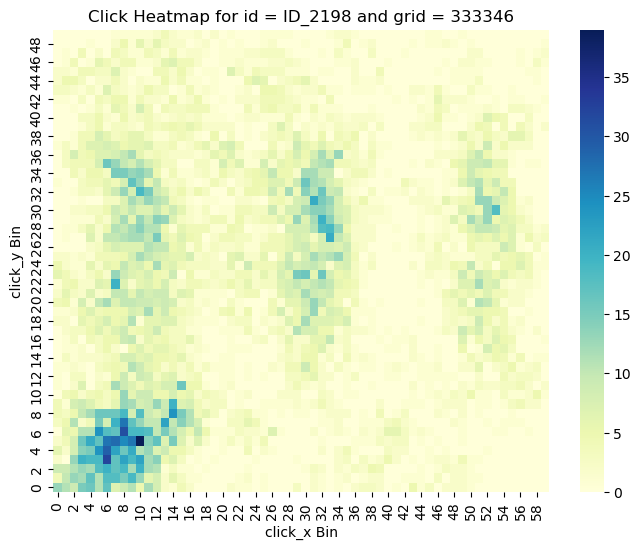

aasdfasdfasdfasdf


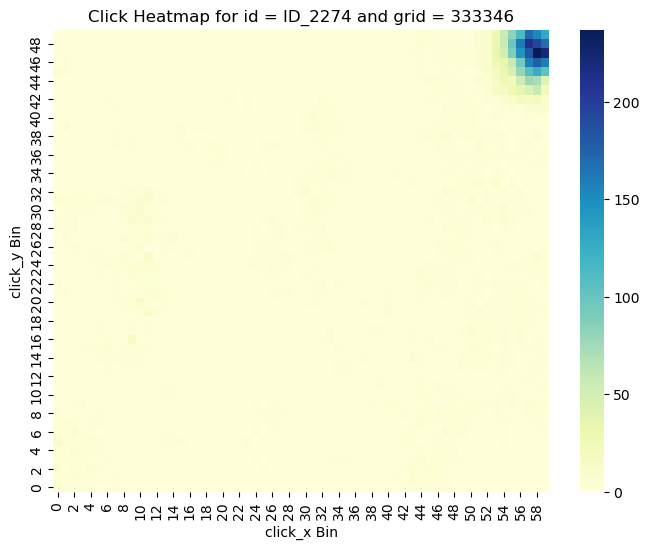

aasdfasdfasdfasdf


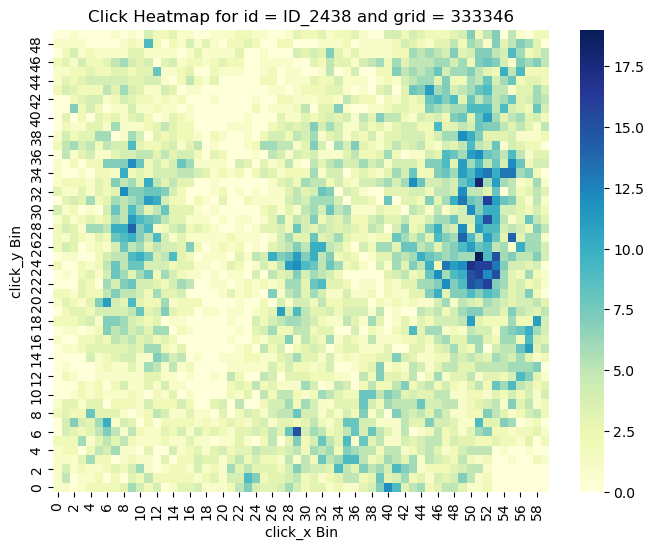

aasdfasdfasdfasdf


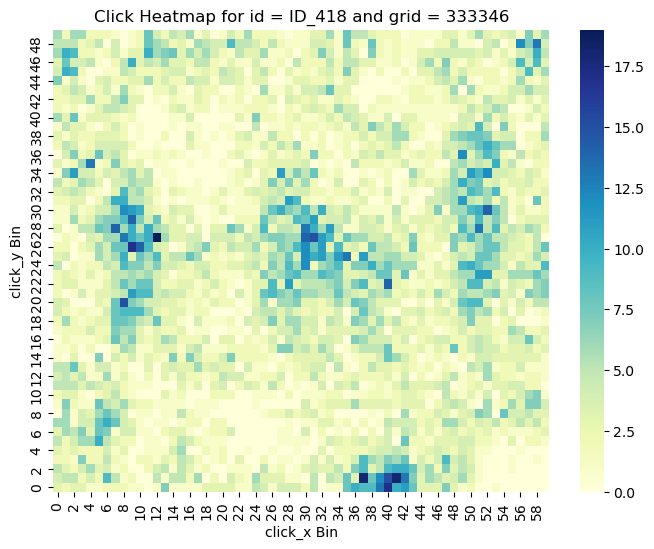

aasdfasdfasdfasdf


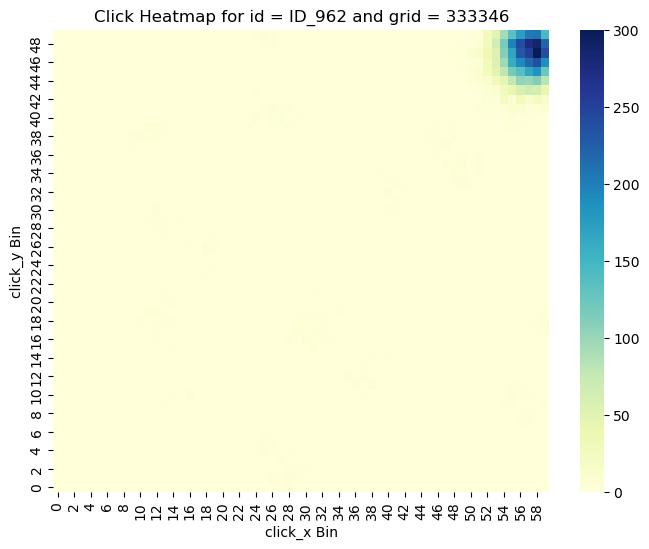

In [101]:
for dom in misid[1e-06]['FP']:
    if dom in unique_gd_comb[unique_gd_comb.grid_id == 333346].domain.unique():
        print('aasdfasdfasdfasdf')
        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
                                     (aggregated_clicks.domain == dom)]
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()
    elif  dom in unique_gd_comb[unique_gd_comb.grid_id == 333519].domain.unique():

        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
                                     (aggregated_clicks.domain == dom)]
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()
        

## True Positives:

### 333519

Total clicks for (grid_id, domain): (333519, ID_1184): 326


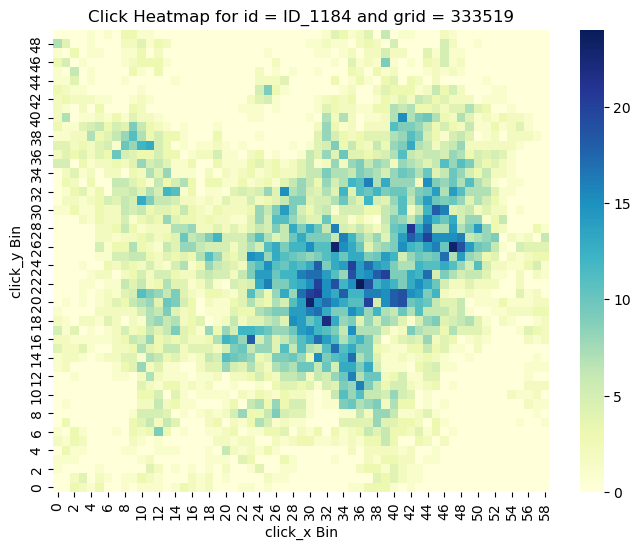

Total clicks for (grid_id, domain): (333519, ID_1281): 235


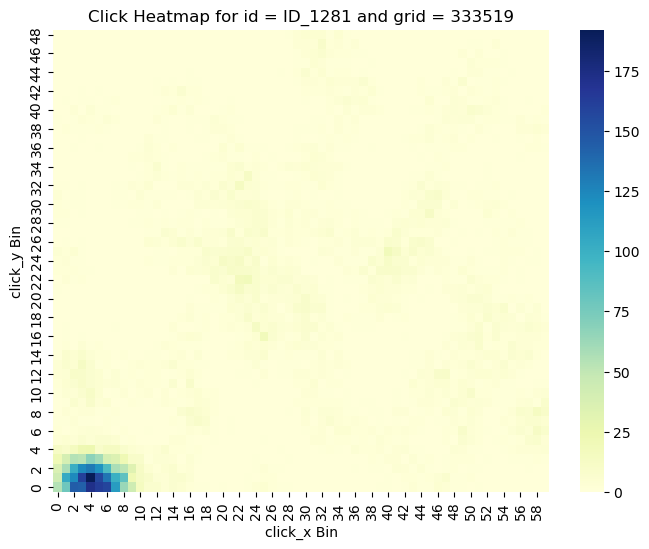

Total clicks for (grid_id, domain): (333519, ID_1305): 202


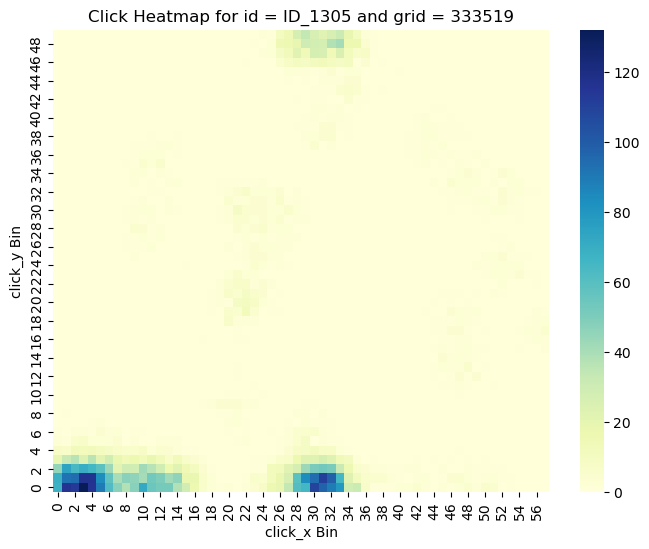

Total clicks for (grid_id, domain): (333519, ID_1353): 2107


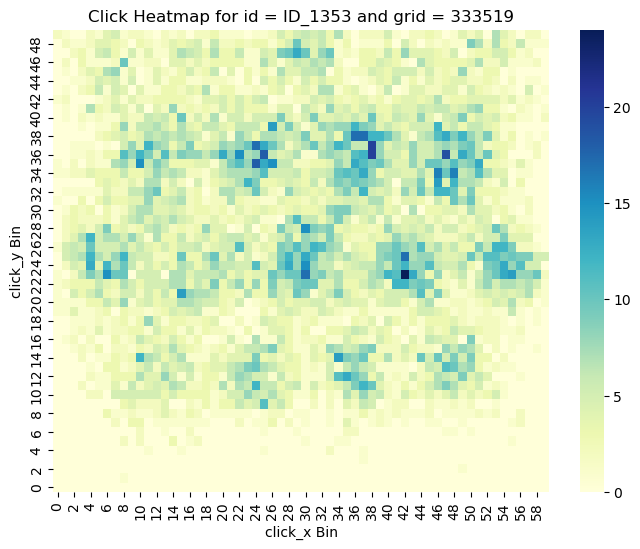

Total clicks for (grid_id, domain): (333519, ID_1448): 503


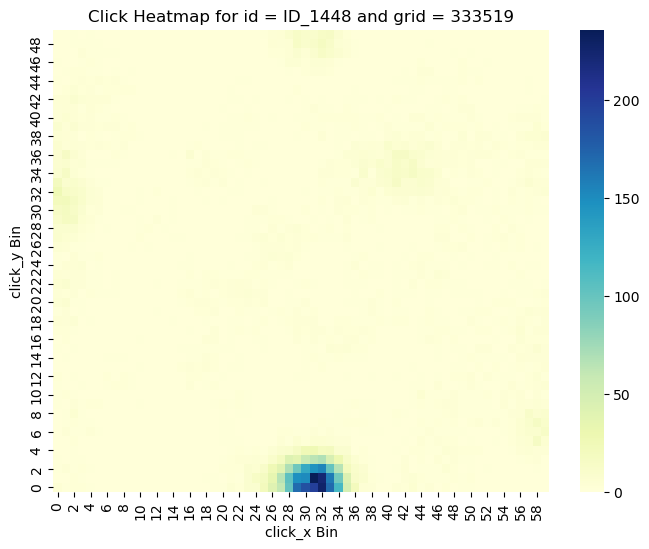

Total clicks for (grid_id, domain): (333519, ID_1522): 257


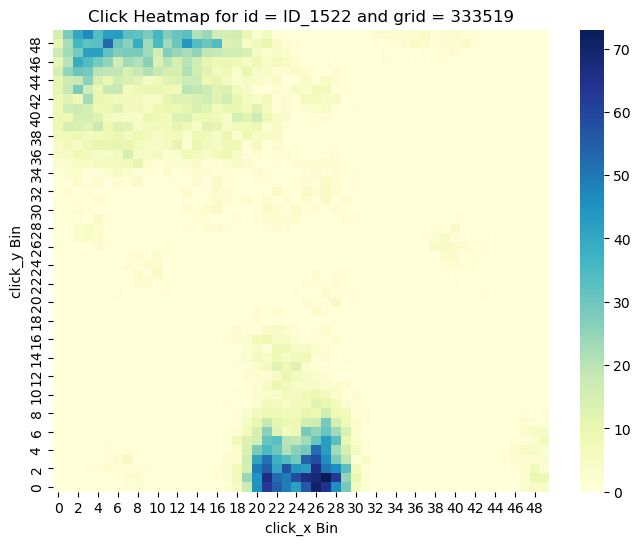

Total clicks for (grid_id, domain): (333519, ID_1544): 571


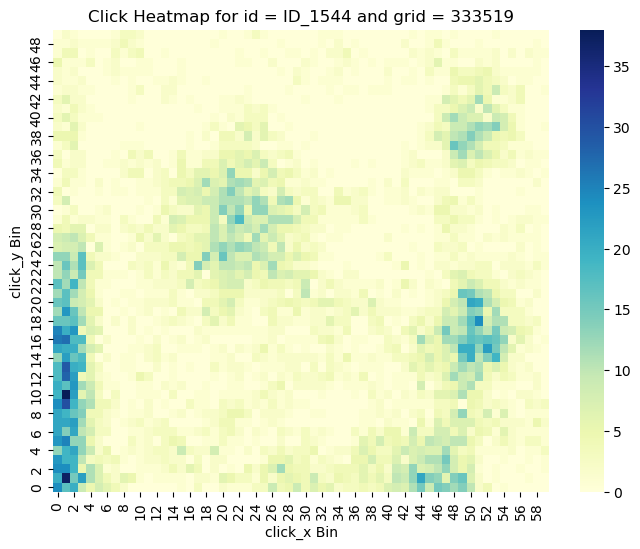

Total clicks for (grid_id, domain): (333519, ID_162): 213


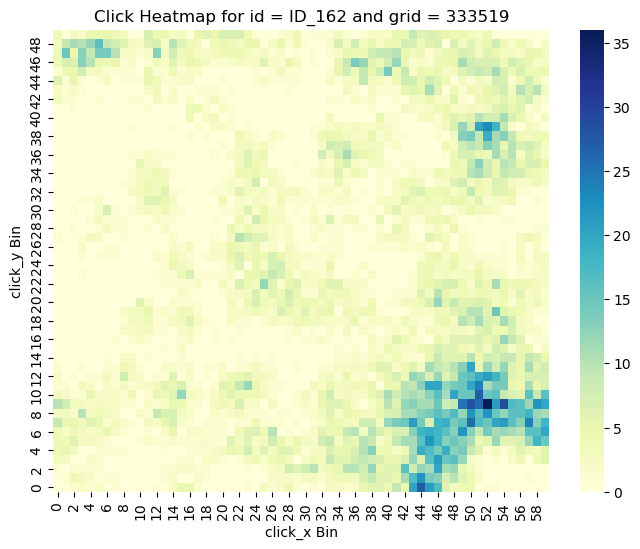

Total clicks for (grid_id, domain): (333519, ID_1682): 423


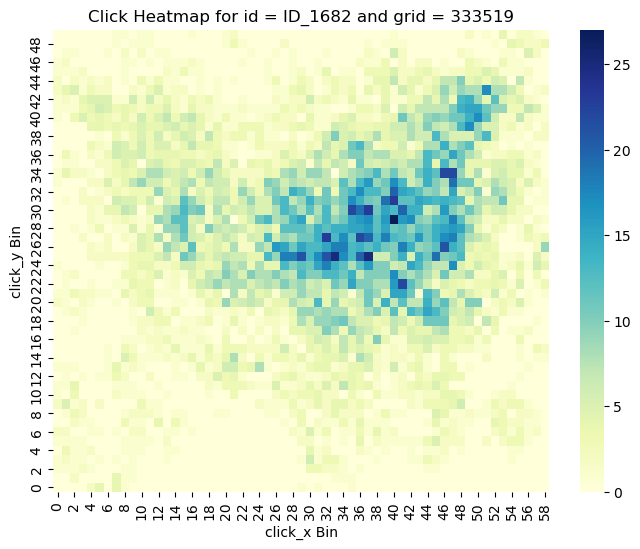

Total clicks for (grid_id, domain): (333519, ID_1690): 235


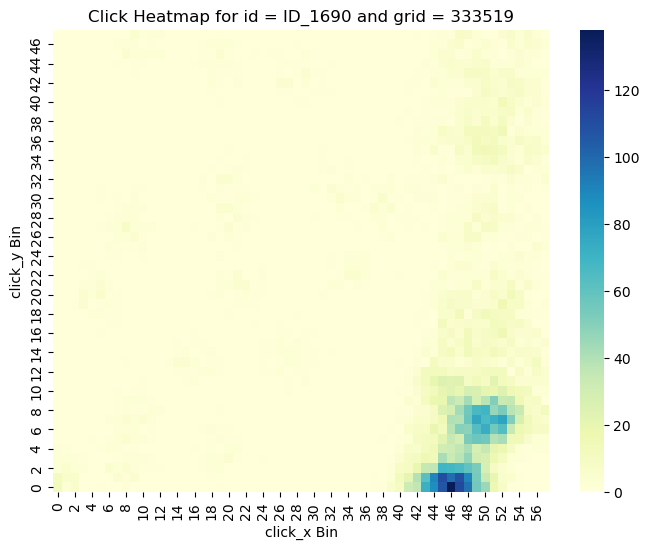

Total clicks for (grid_id, domain): (333519, ID_1824): 239


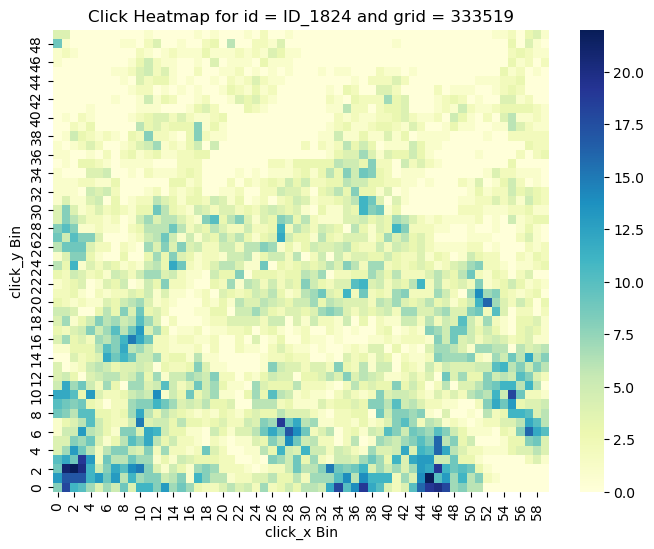

Total clicks for (grid_id, domain): (333519, ID_1888): 1749


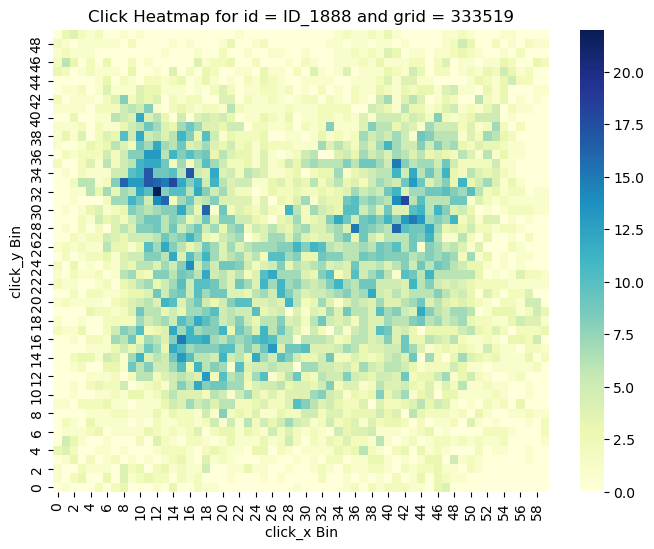

Total clicks for (grid_id, domain): (333519, ID_1929): 437


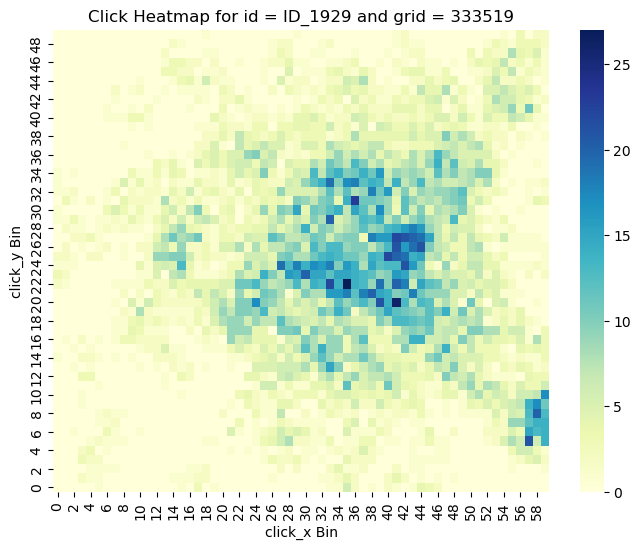

Total clicks for (grid_id, domain): (333519, ID_2076): 4762


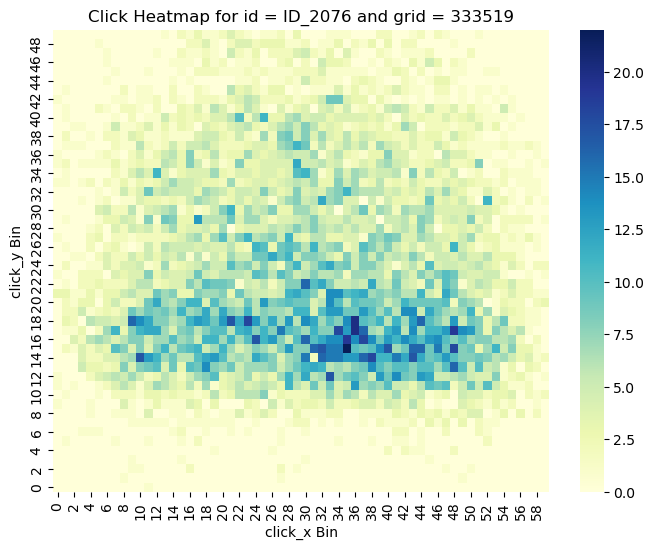

Total clicks for (grid_id, domain): (333519, ID_2097): 264


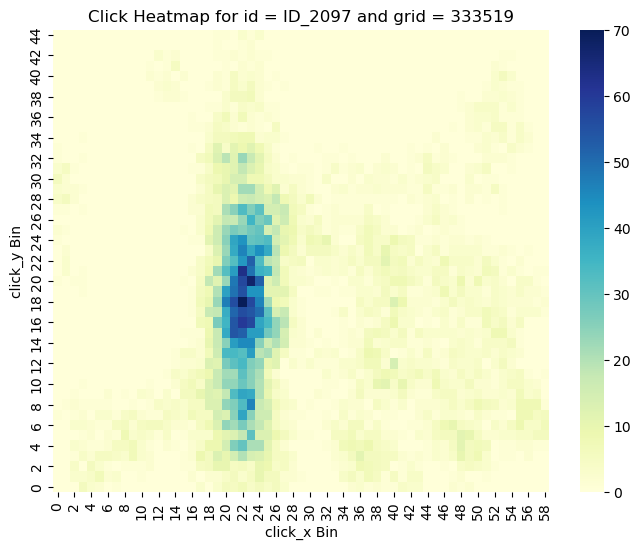

Total clicks for (grid_id, domain): (333519, ID_2226): 282


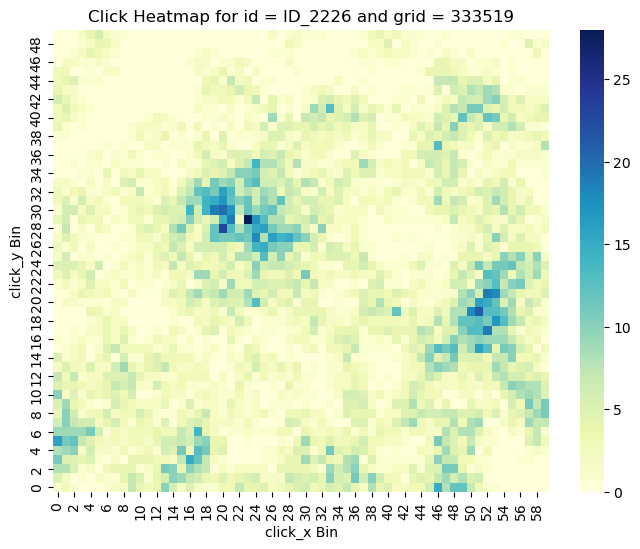

Total clicks for (grid_id, domain): (333519, ID_2249): 220


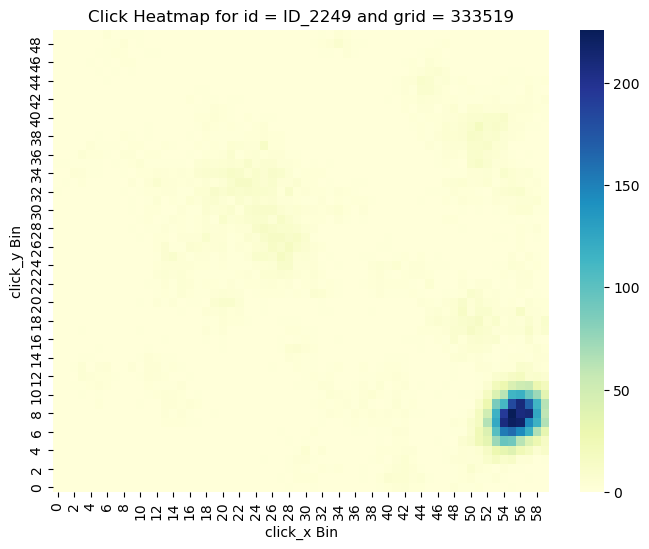

Total clicks for (grid_id, domain): (333519, ID_2268): 377


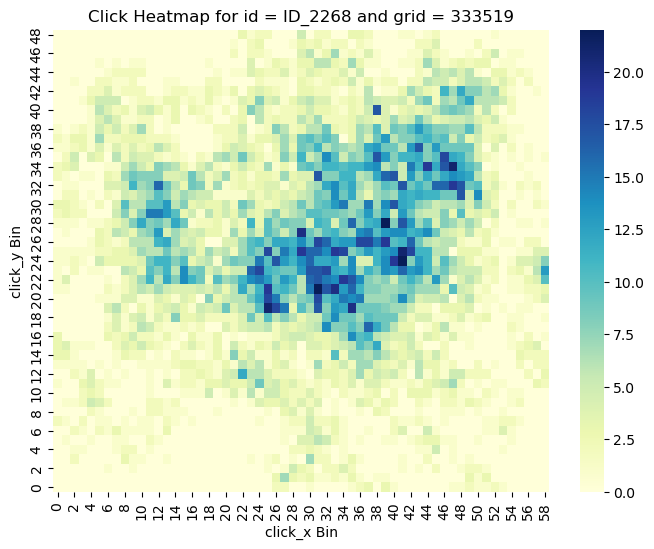

Total clicks for (grid_id, domain): (333519, ID_2331): 742


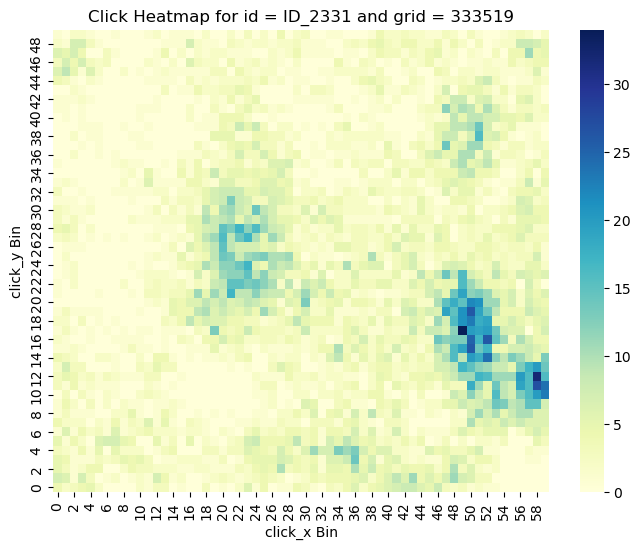

Total clicks for (grid_id, domain): (333519, ID_2339): 414


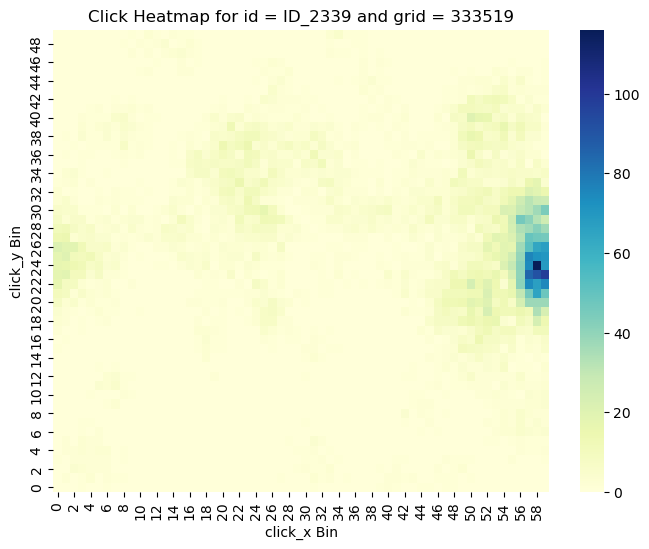

Total clicks for (grid_id, domain): (333519, ID_2386): 257


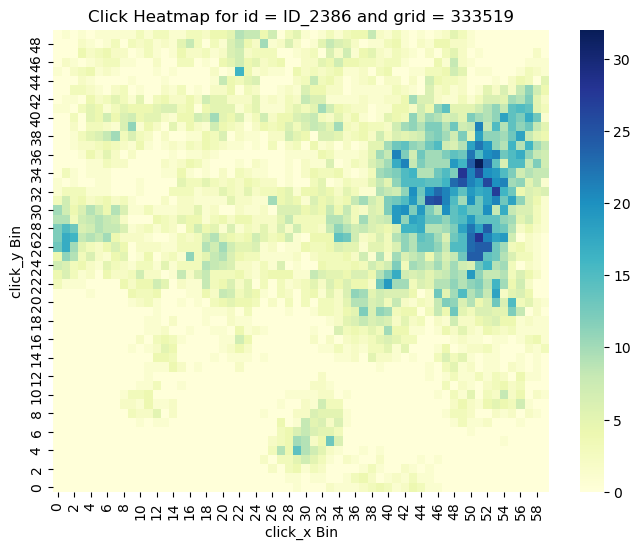

Total clicks for (grid_id, domain): (333519, ID_2396): 573


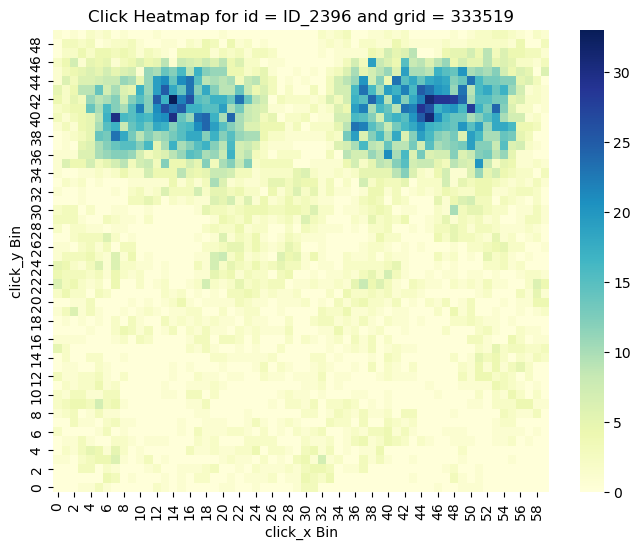

Total clicks for (grid_id, domain): (333519, ID_2438): 1158


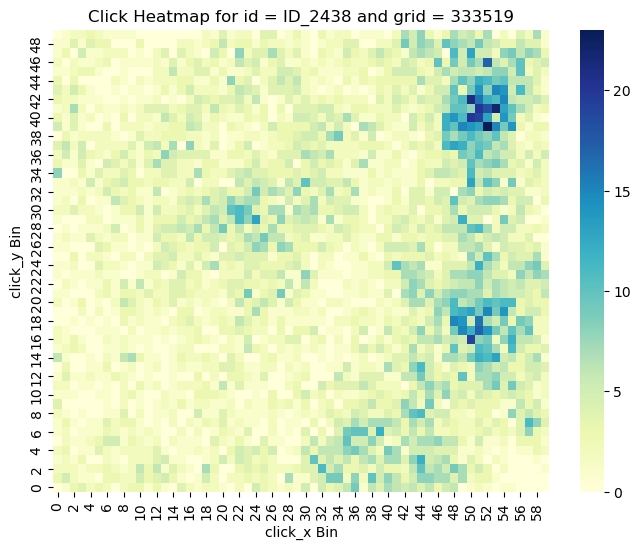

Total clicks for (grid_id, domain): (333519, ID_258): 363


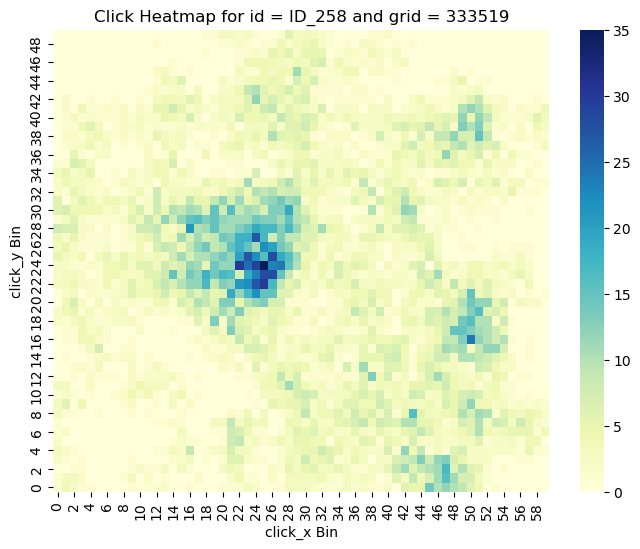

Total clicks for (grid_id, domain): (333519, ID_2609): 668


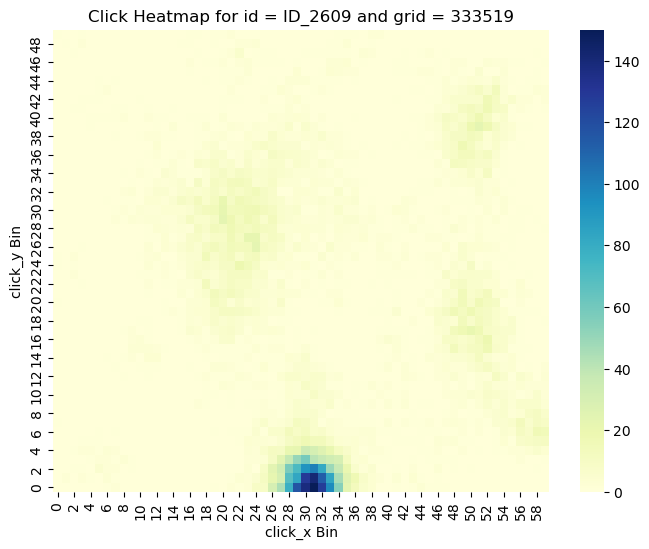

Total clicks for (grid_id, domain): (333519, ID_2680): 202


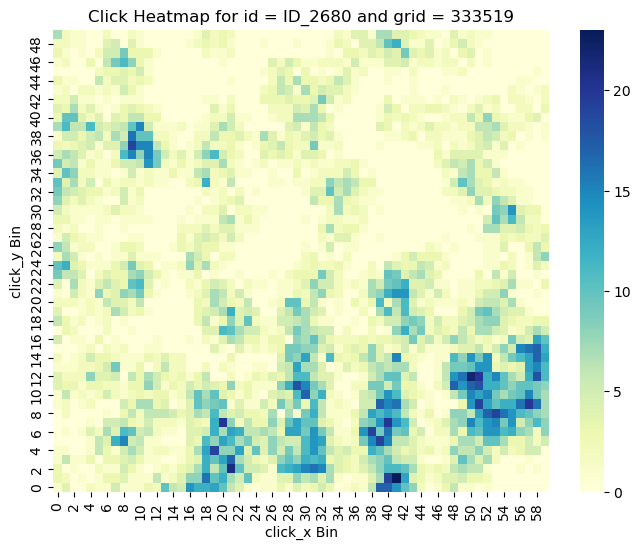

Total clicks for (grid_id, domain): (333519, ID_2863): 279


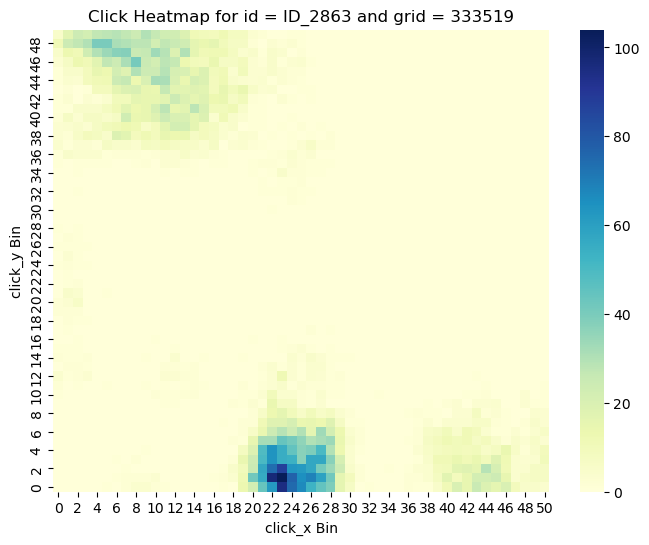

Total clicks for (grid_id, domain): (333519, ID_2883): 408


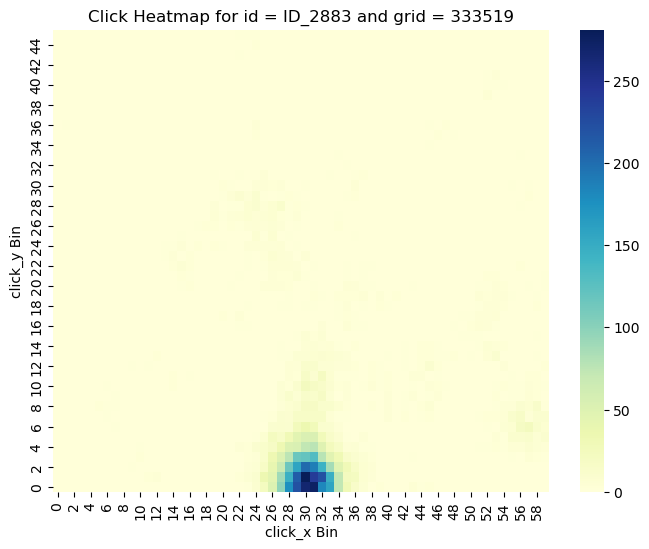

Total clicks for (grid_id, domain): (333519, ID_2908): 540


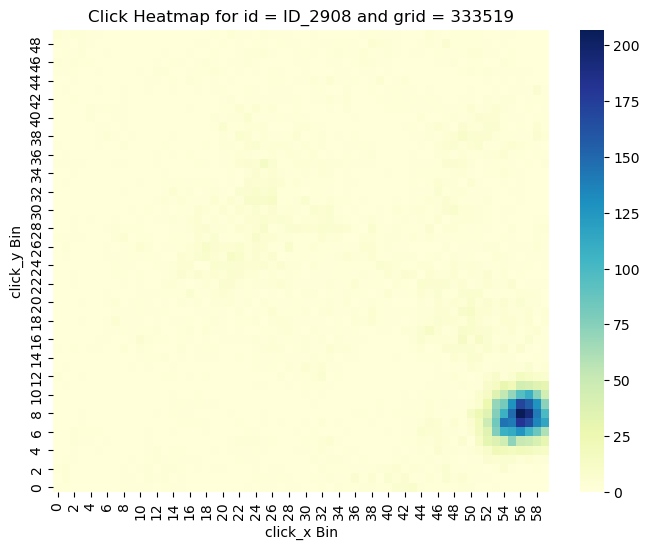

Total clicks for (grid_id, domain): (333519, ID_3061): 541


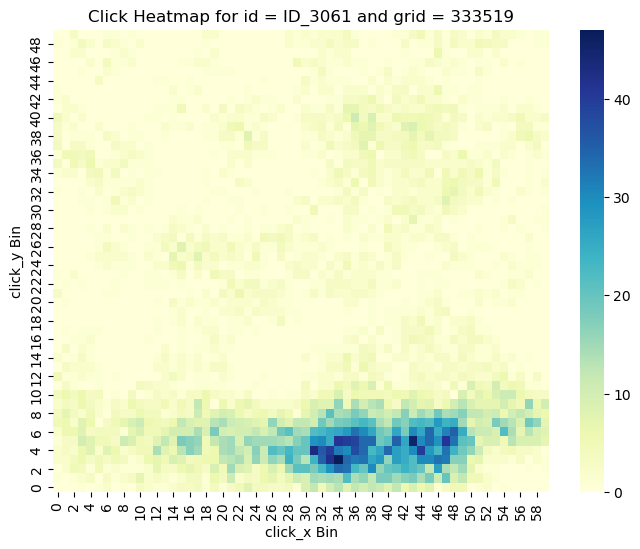

Total clicks for (grid_id, domain): (333519, ID_3243): 565


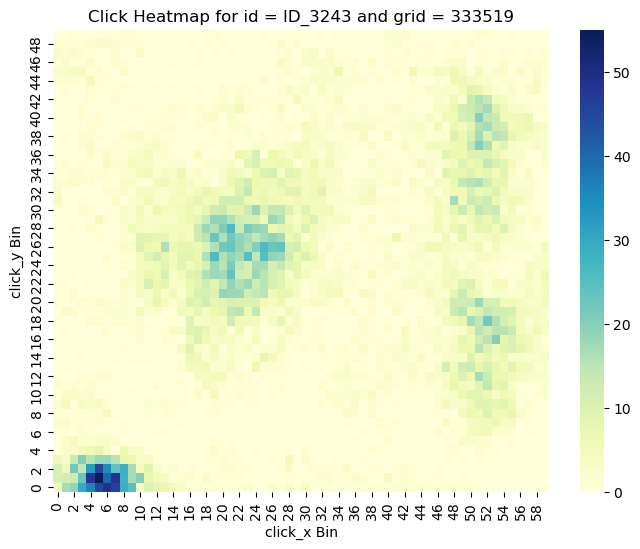

Total clicks for (grid_id, domain): (333519, ID_3250): 226


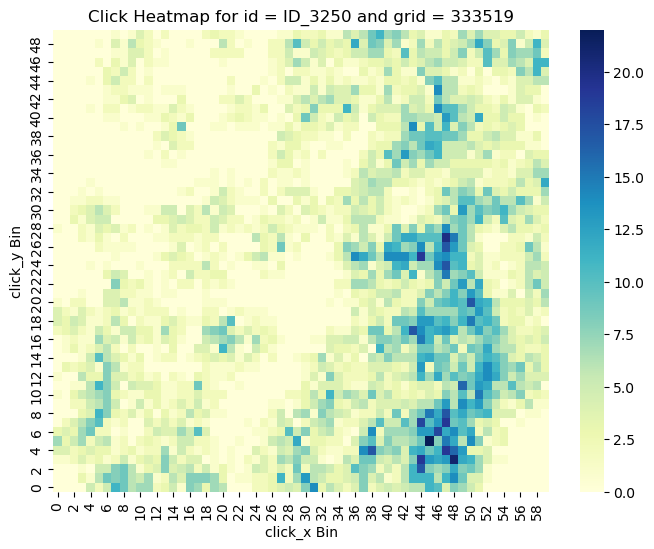

Total clicks for (grid_id, domain): (333519, ID_3314): 330


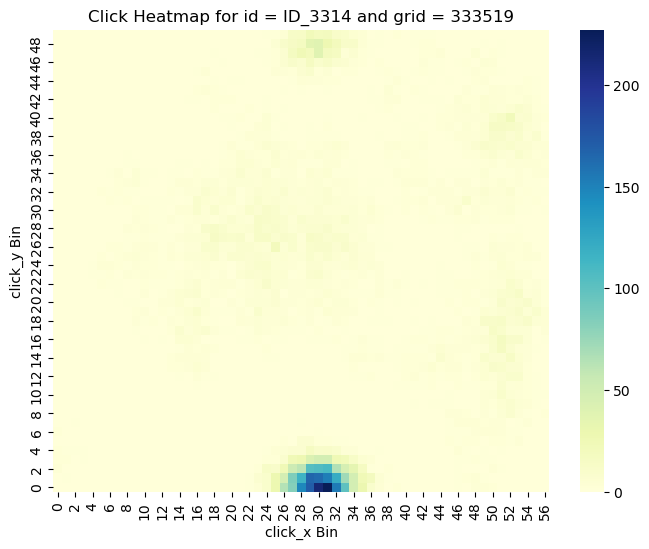

Total clicks for (grid_id, domain): (333519, ID_3382): 2093


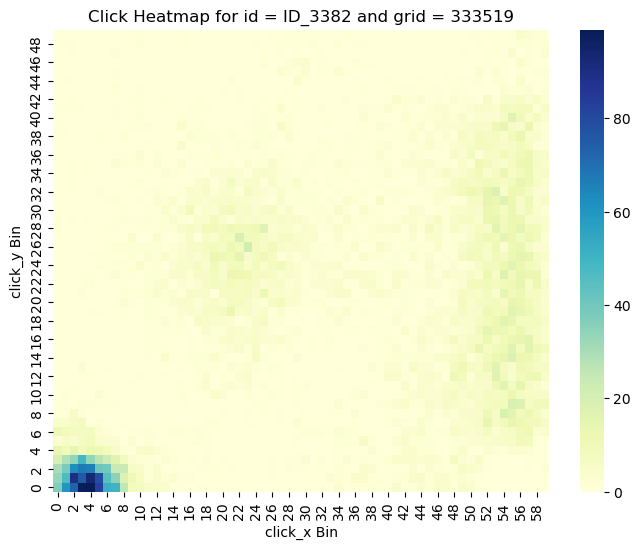

Total clicks for (grid_id, domain): (333519, ID_3397): 534


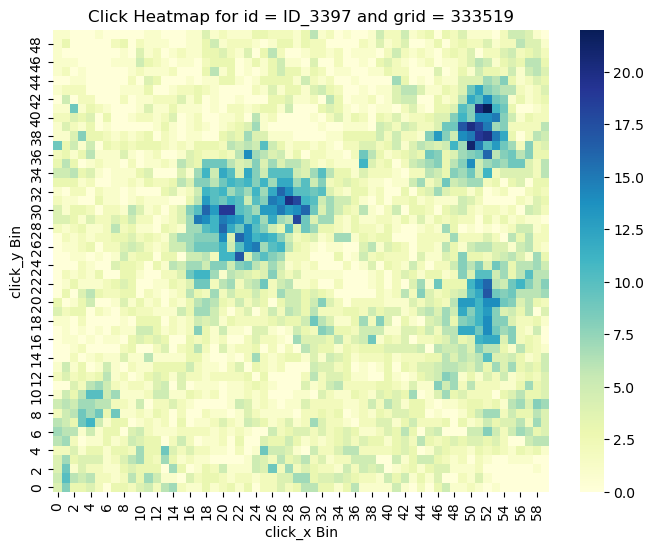

Total clicks for (grid_id, domain): (333519, ID_3402): 251


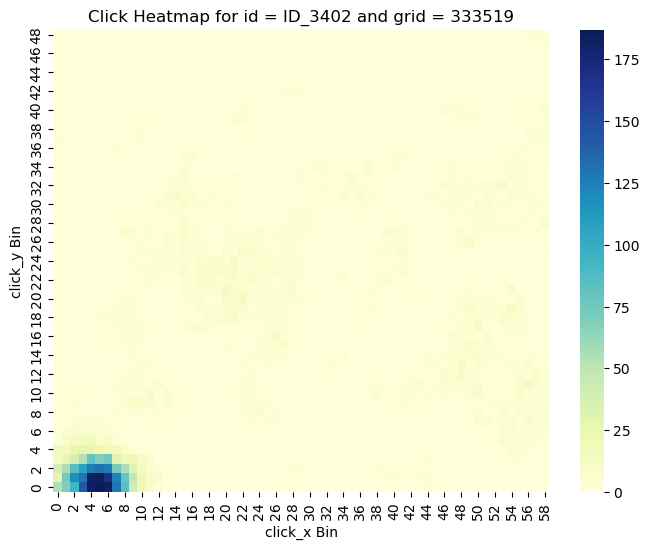

Total clicks for (grid_id, domain): (333519, ID_3420): 373


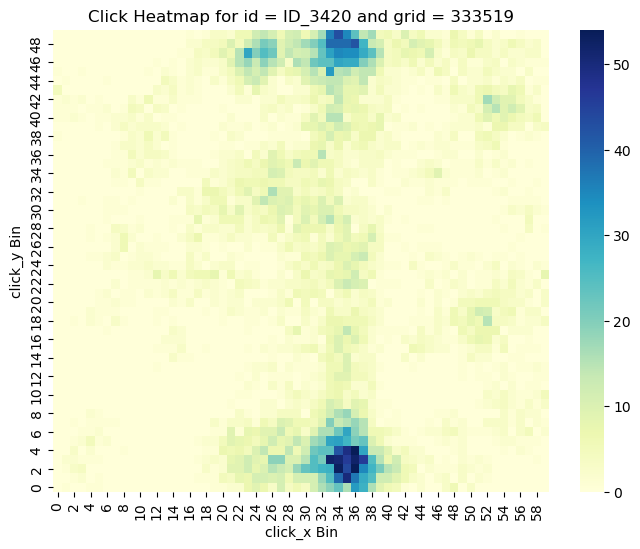

Total clicks for (grid_id, domain): (333519, ID_3459): 293


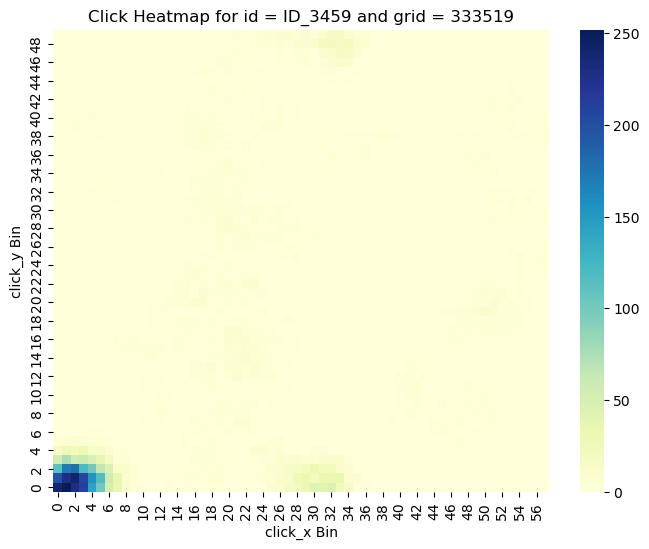

Total clicks for (grid_id, domain): (333519, ID_3470): 297


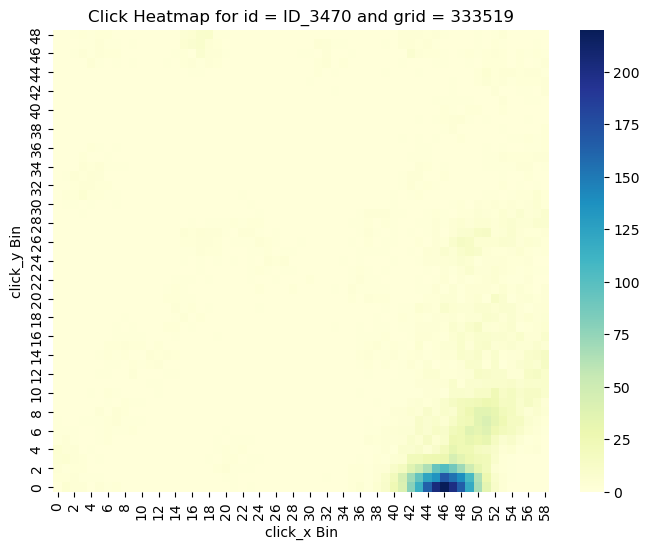

Total clicks for (grid_id, domain): (333519, ID_3540): 230


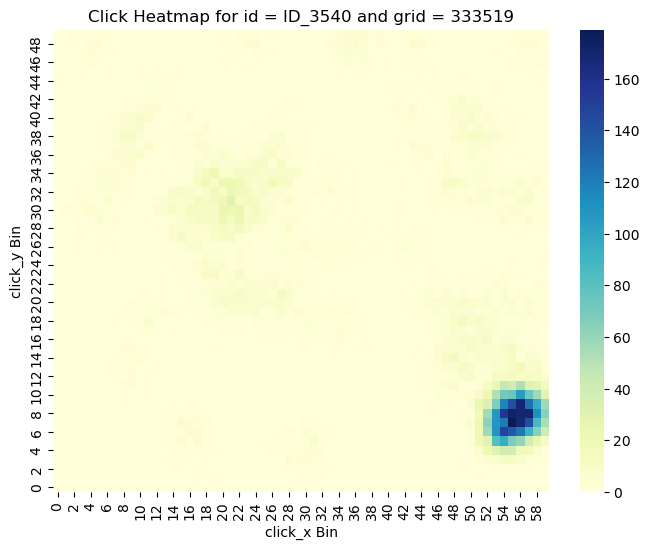

Total clicks for (grid_id, domain): (333519, ID_409): 1200


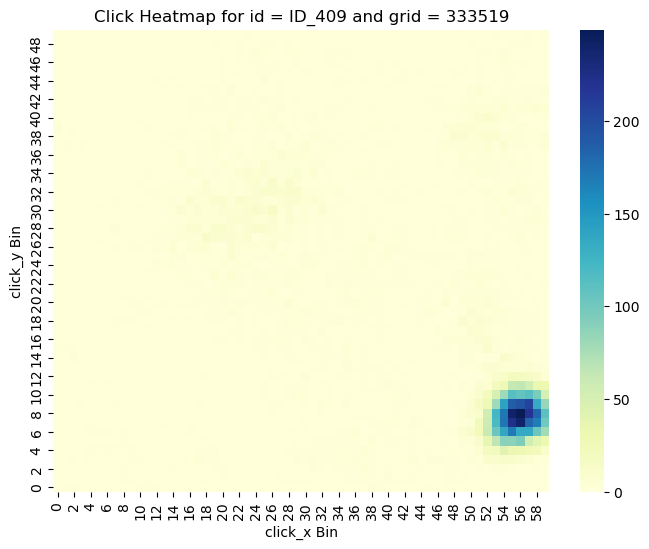

Total clicks for (grid_id, domain): (333519, ID_484): 255


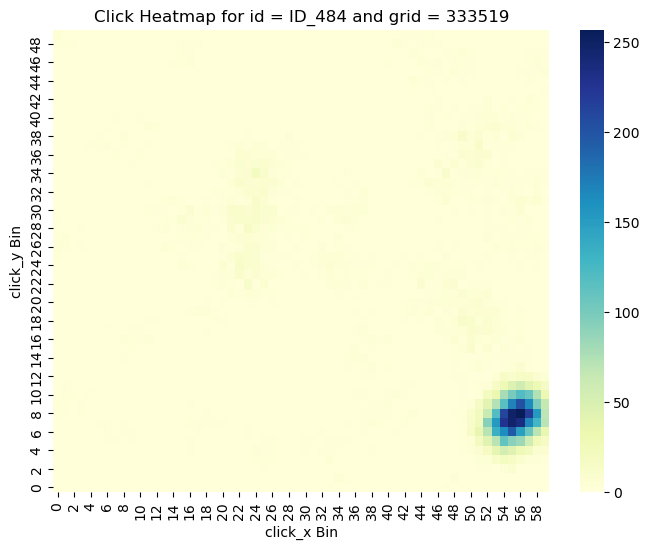

Total clicks for (grid_id, domain): (333519, ID_489): 449


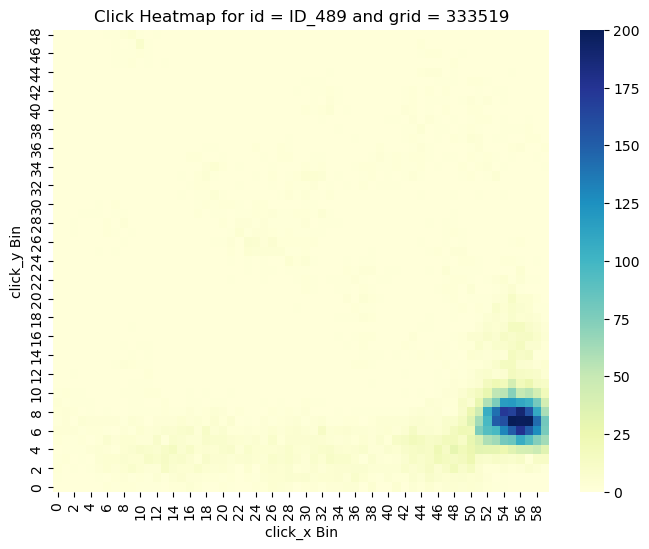

Total clicks for (grid_id, domain): (333519, ID_526): 248


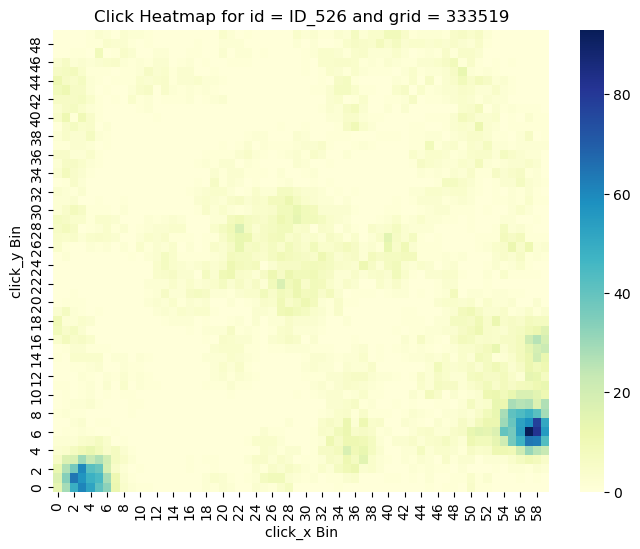

Total clicks for (grid_id, domain): (333519, ID_549): 330


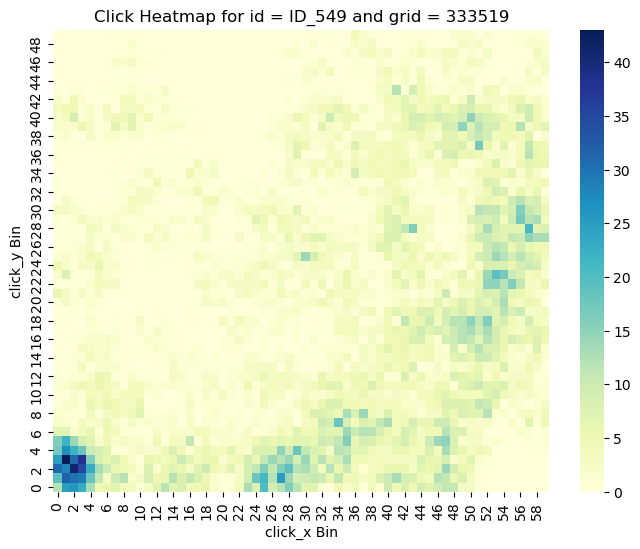

Total clicks for (grid_id, domain): (333519, ID_580): 642


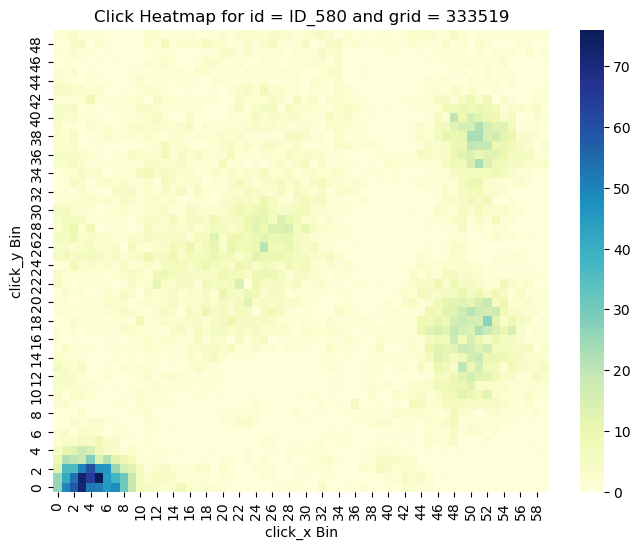

Total clicks for (grid_id, domain): (333519, ID_665): 342


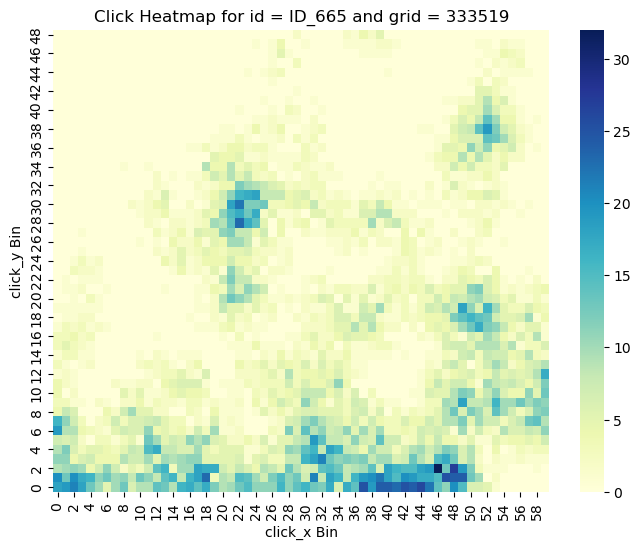

Total clicks for (grid_id, domain): (333519, ID_84): 802


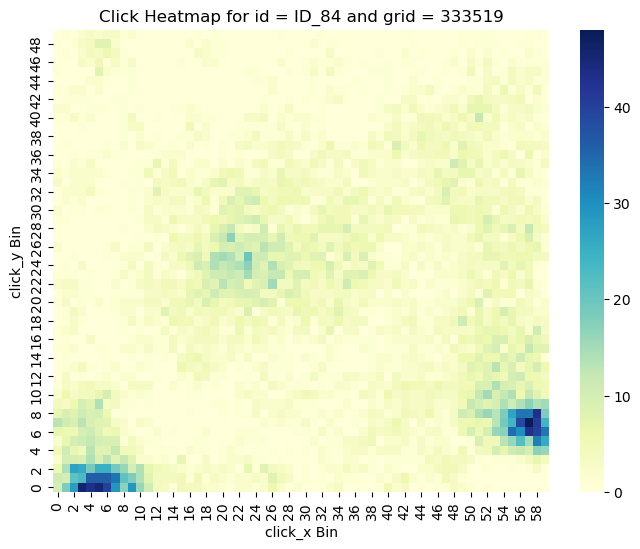

Total clicks for (grid_id, domain): (333519, ID_857): 215


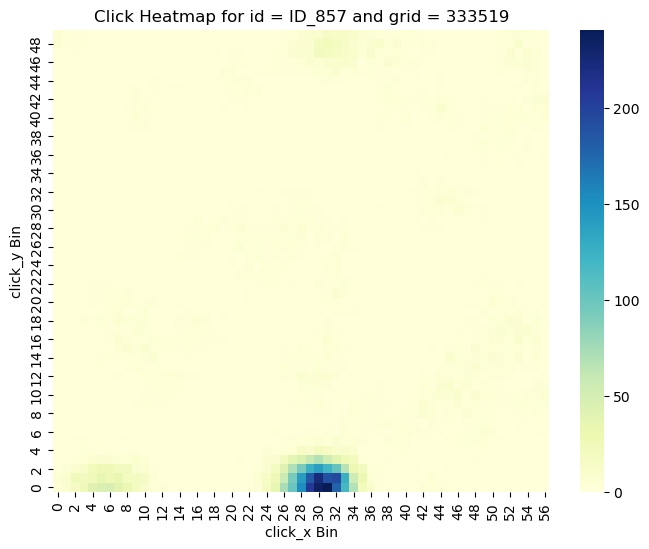

Total clicks for (grid_id, domain): (333519, ID_86): 327


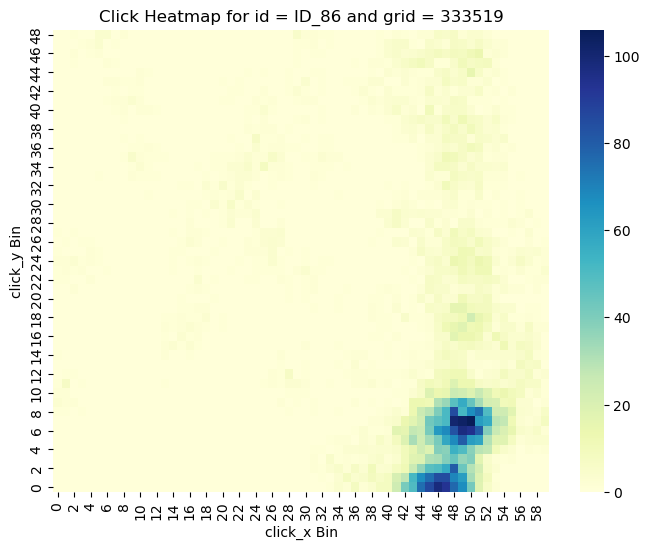

Total clicks for (grid_id, domain): (333519, ID_905): 222


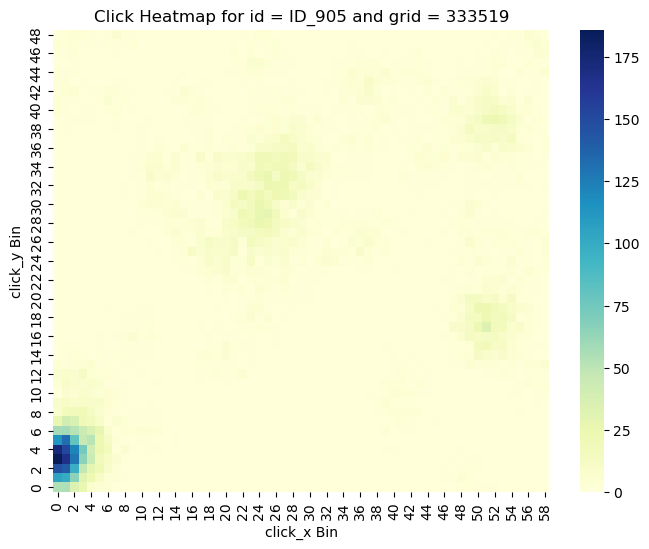

Total clicks for (grid_id, domain): (333519, ID_927): 442


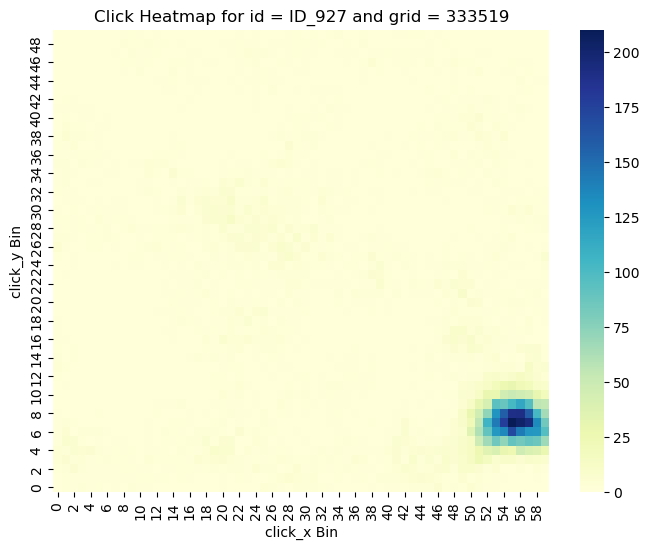

Total clicks for (grid_id, domain): (333519, ID_934): 257


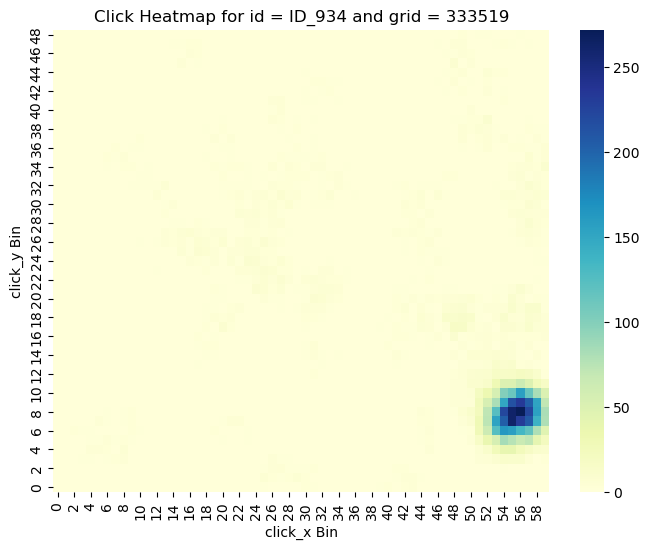

Total clicks for (grid_id, domain): (333519, ID_962): 279


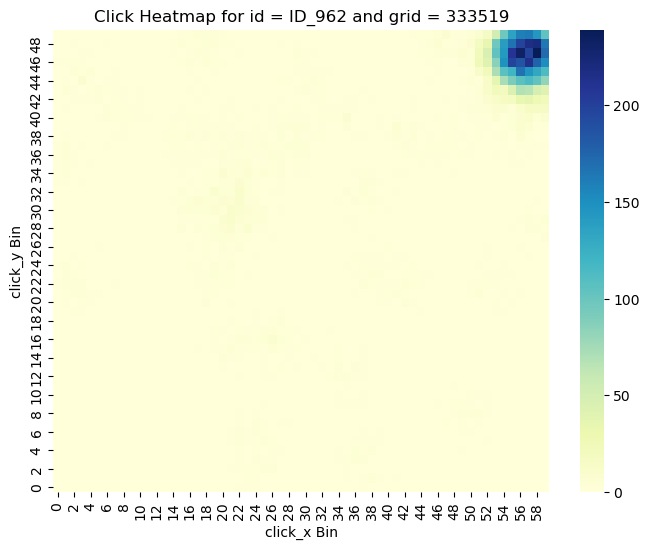

Total clicks for (grid_id, domain): (333519, ID_986): 208


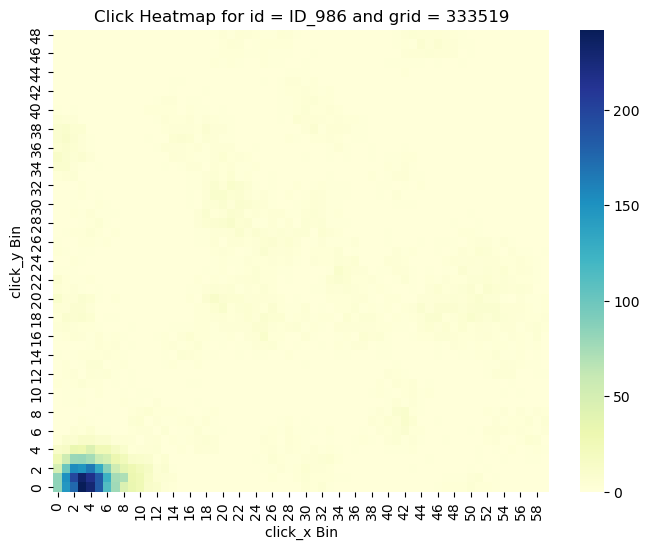

In [114]:
for dom in cb[333519]:
    if dom not in misid[1e-06]['FN']:
        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
                                     (aggregated_clicks.domain == dom)]
        print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()
        

### 333346

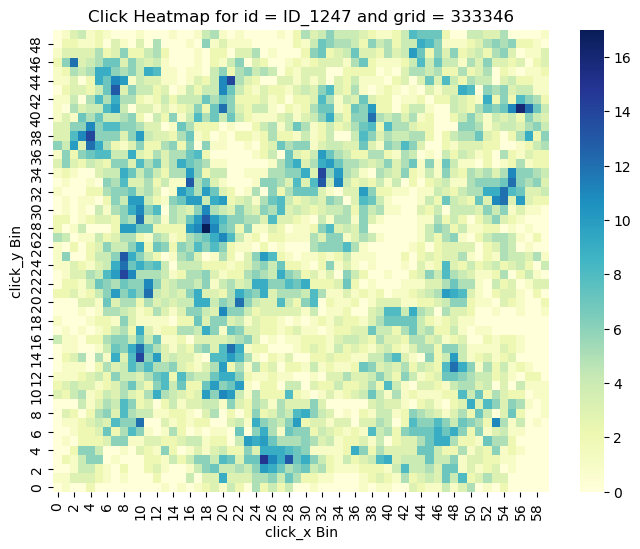

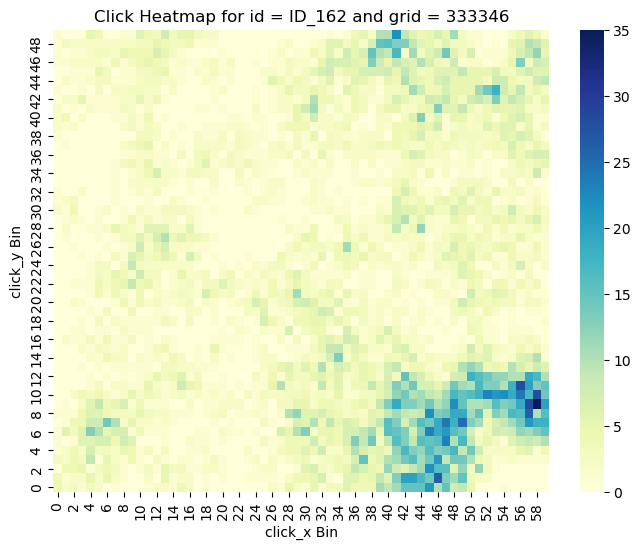

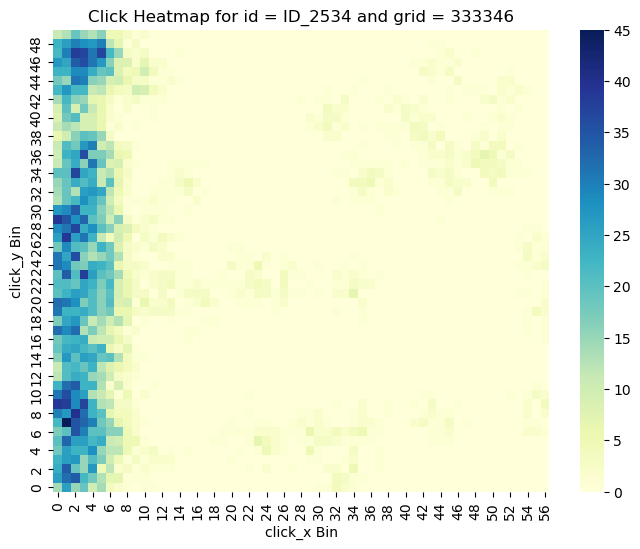

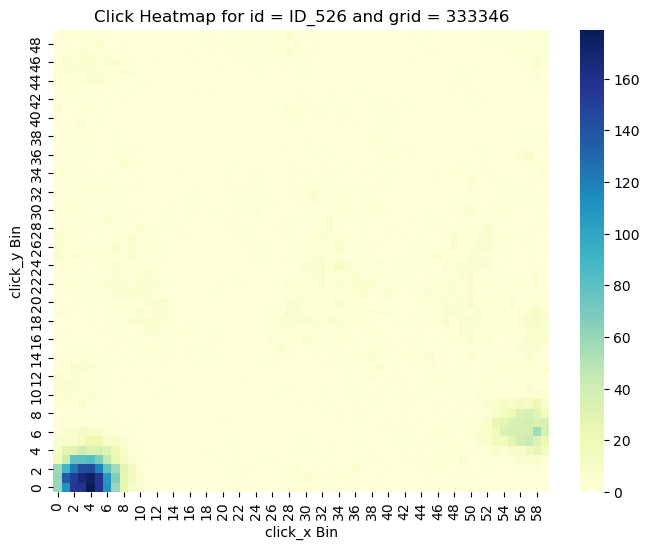

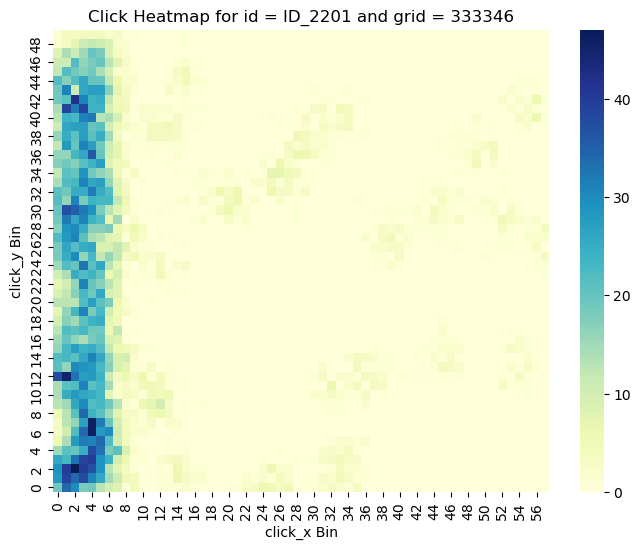

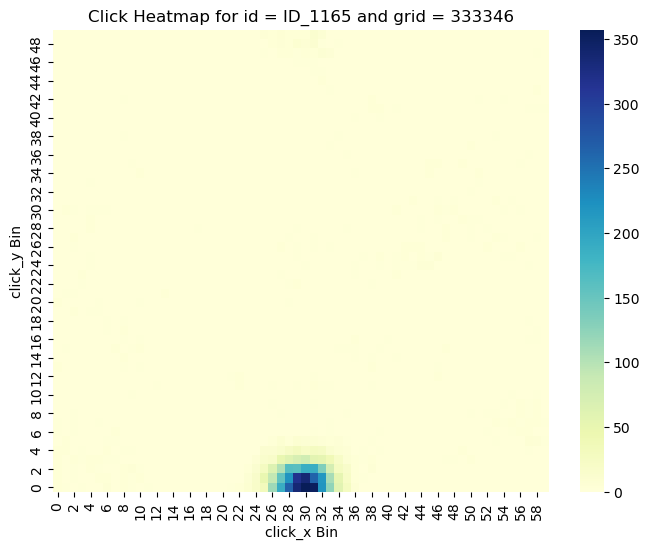

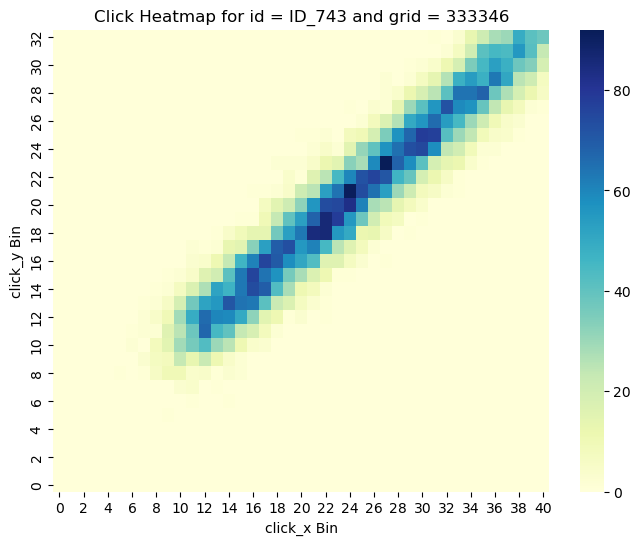

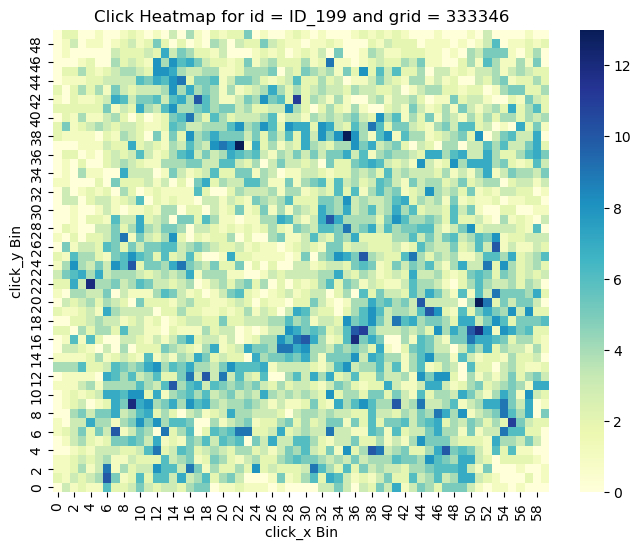

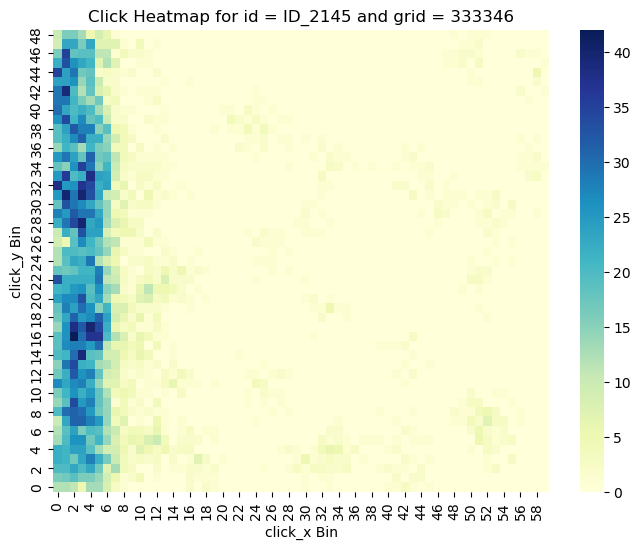

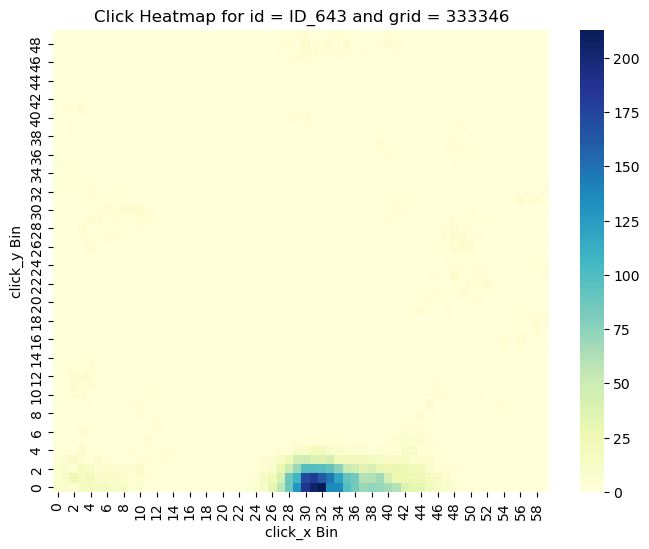

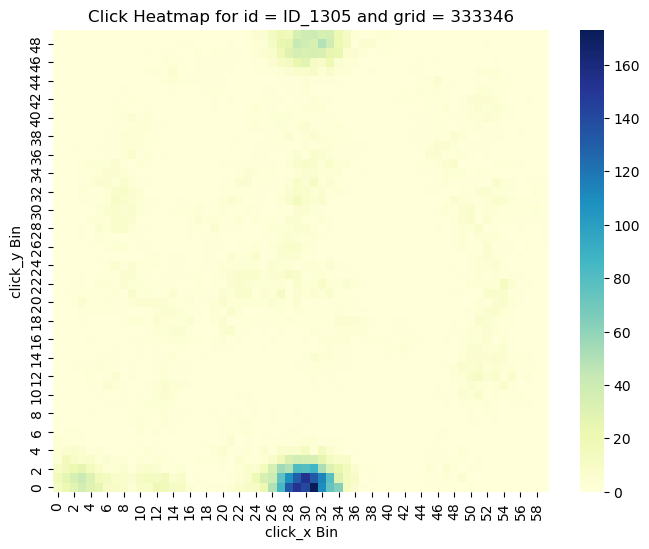

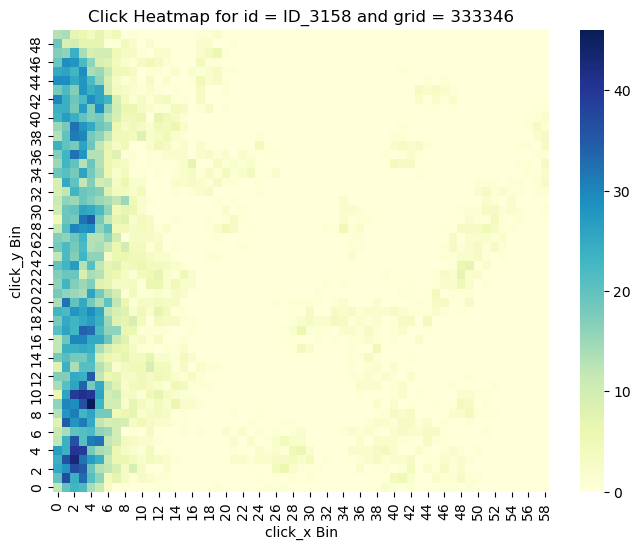

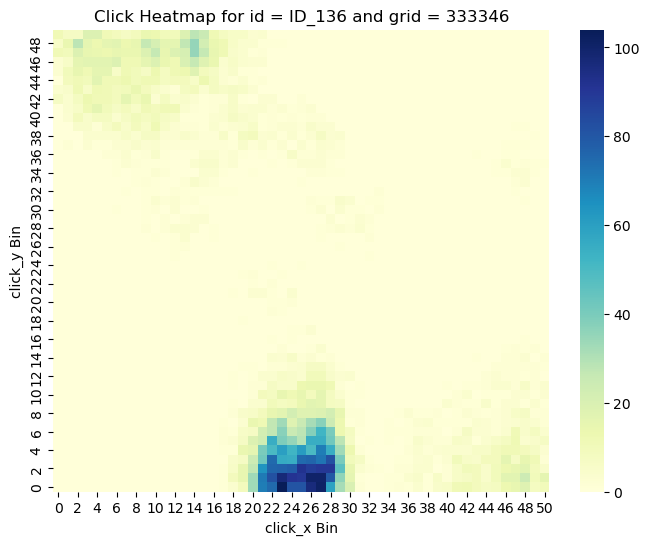

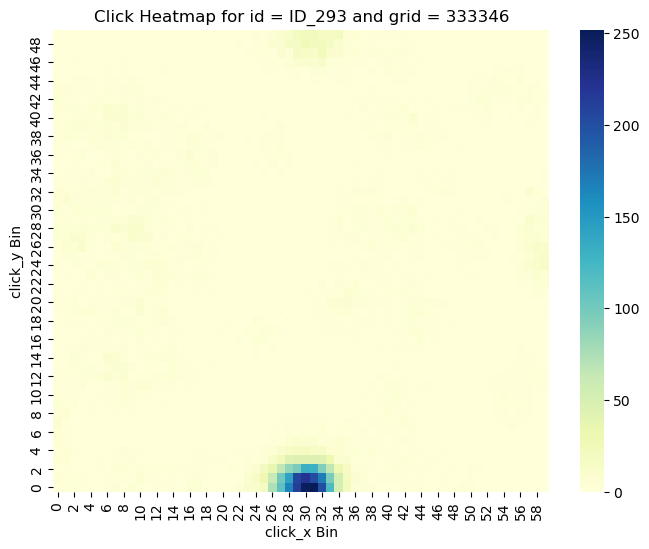

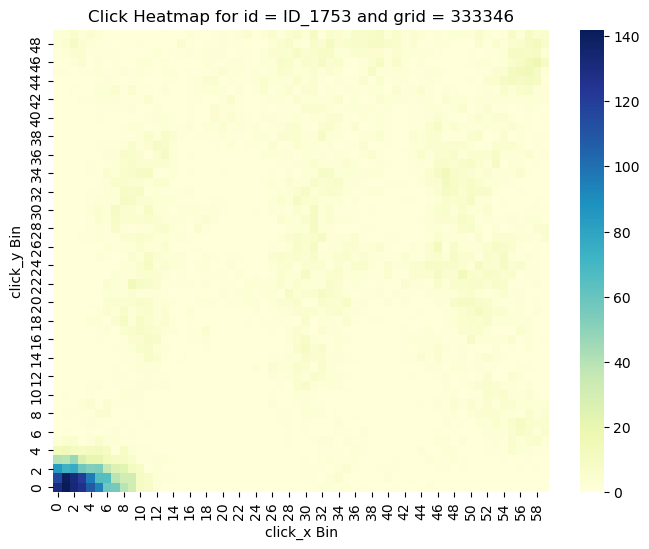

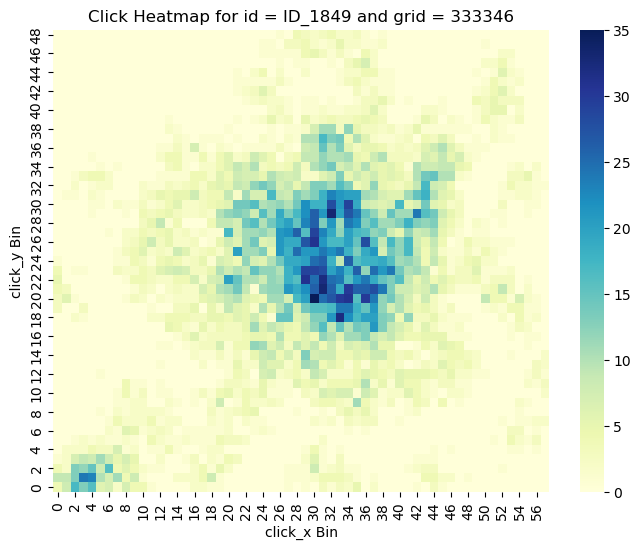

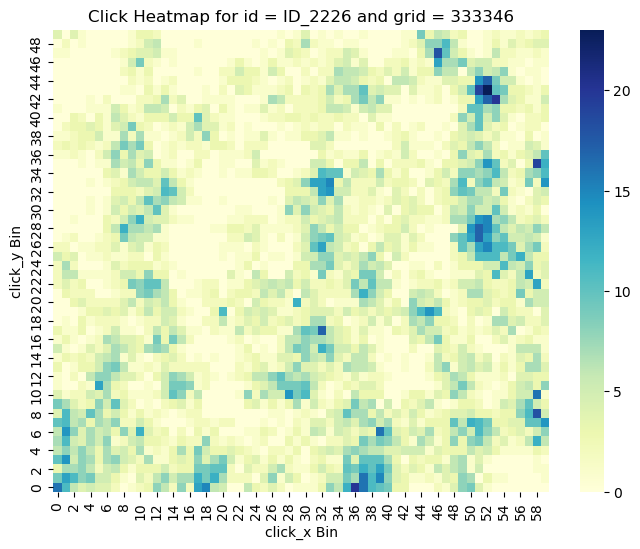

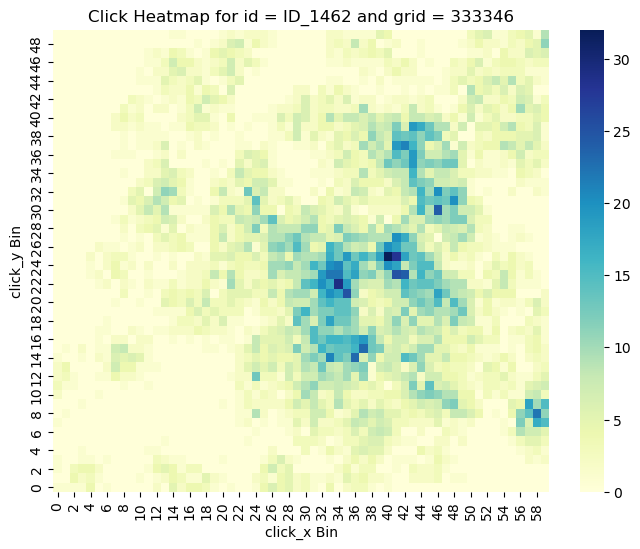

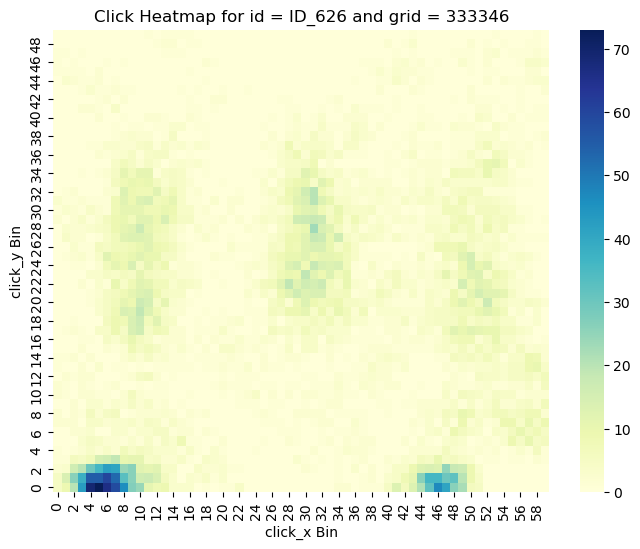

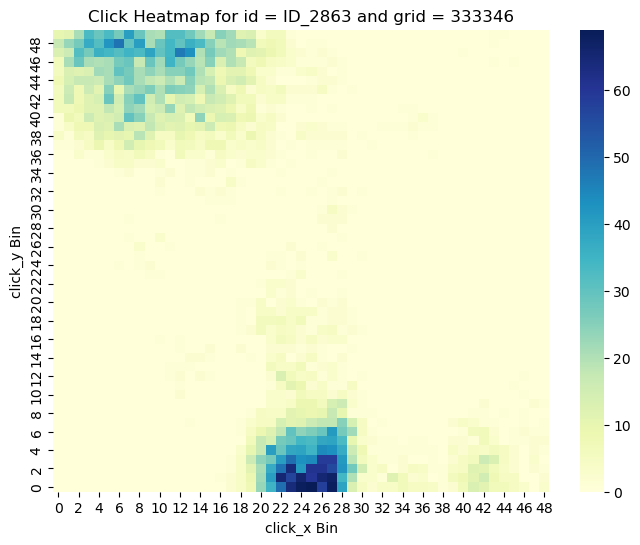

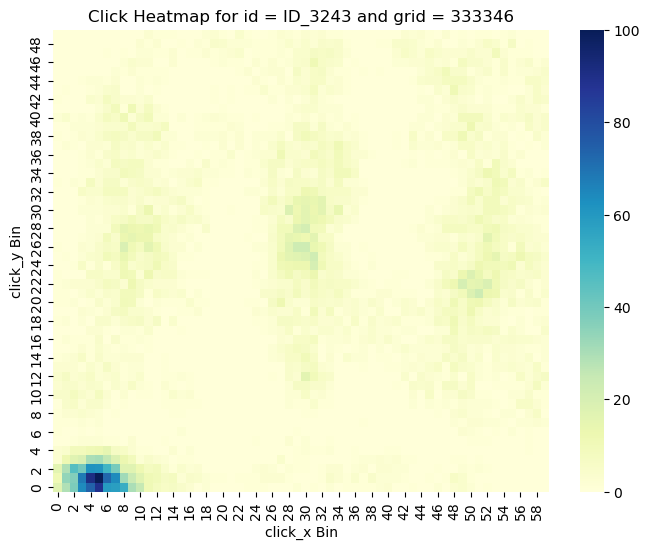

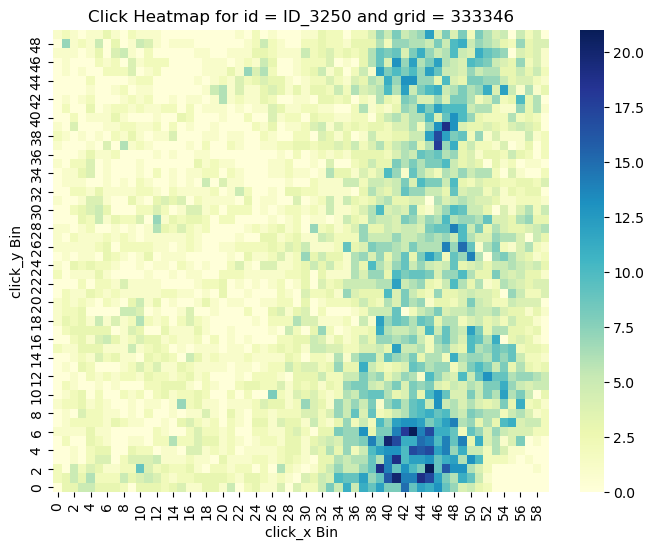

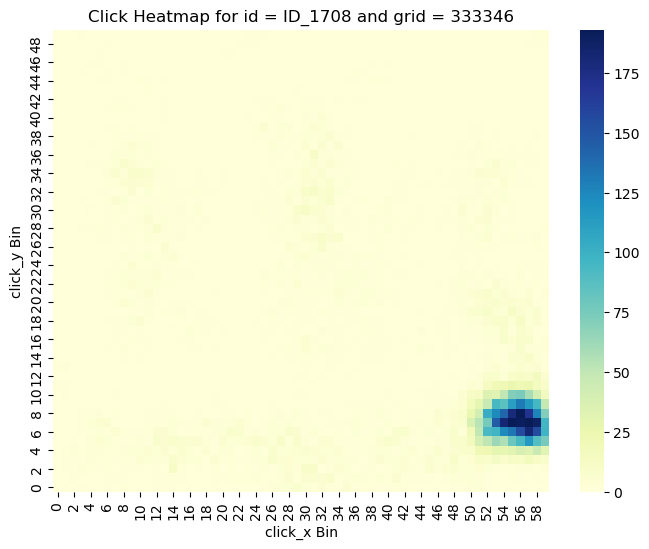

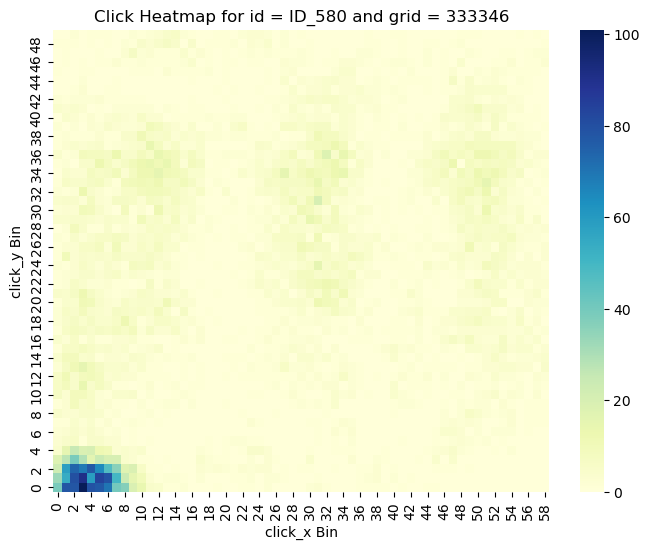

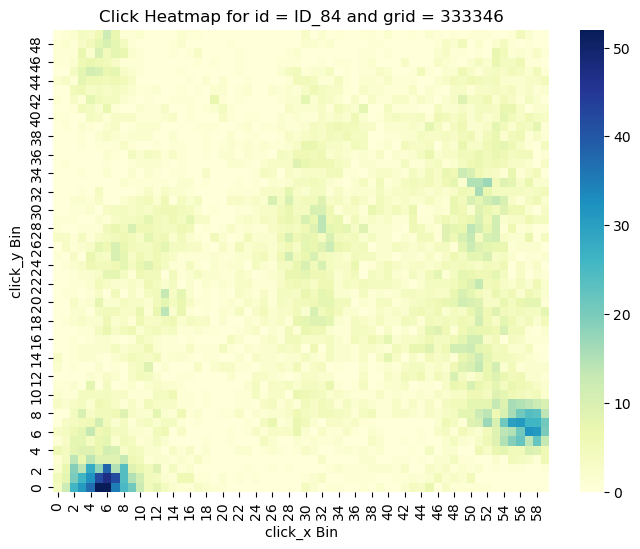

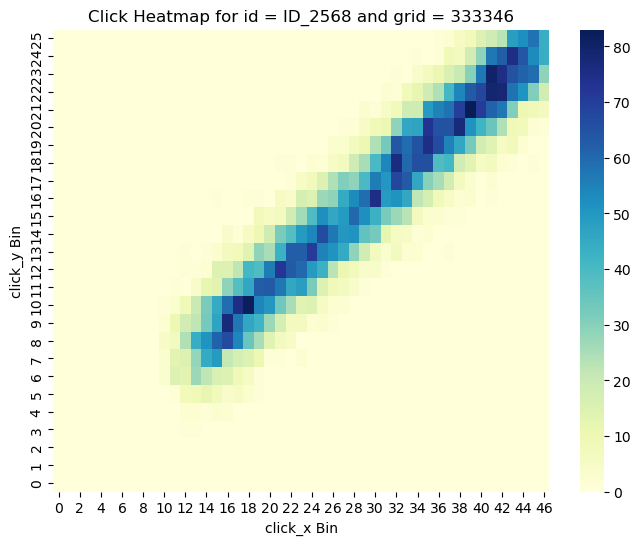

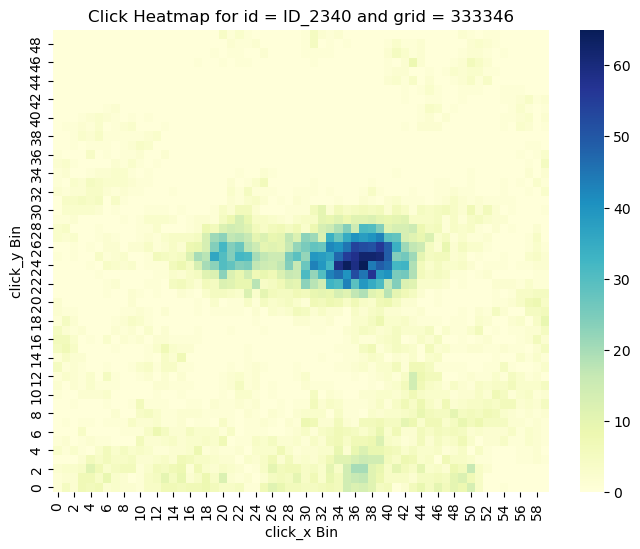

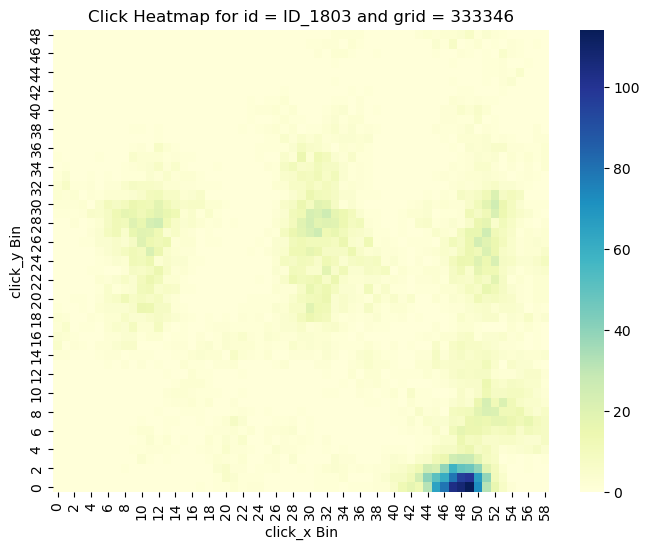

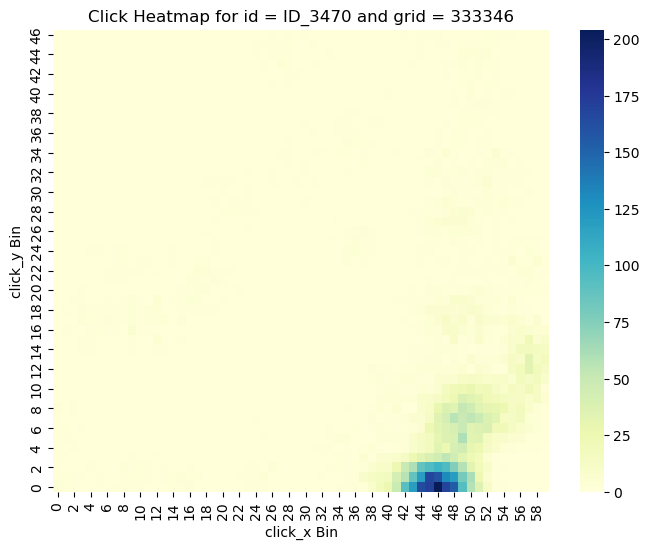

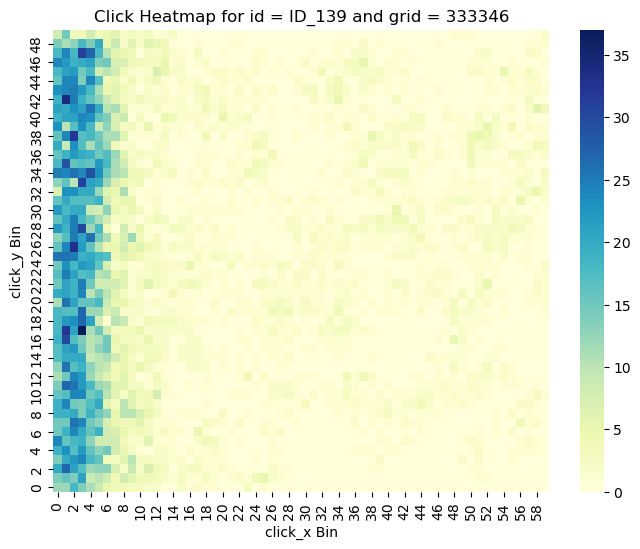

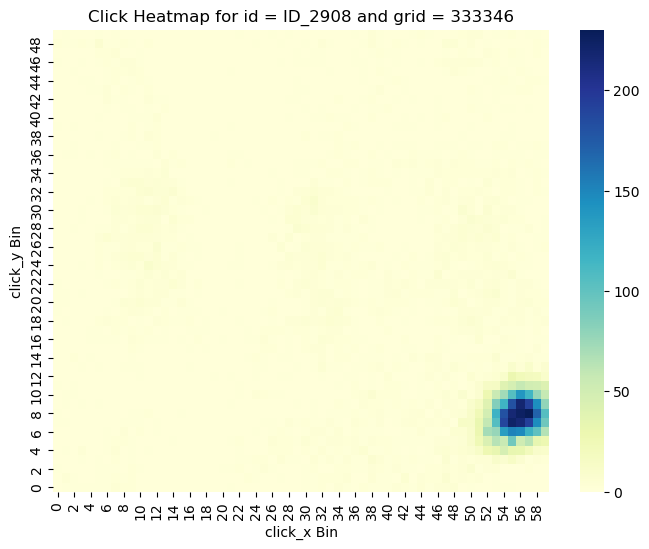

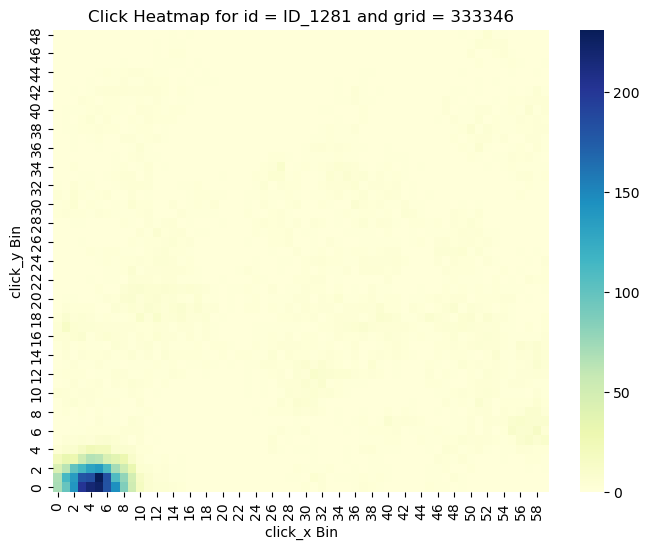

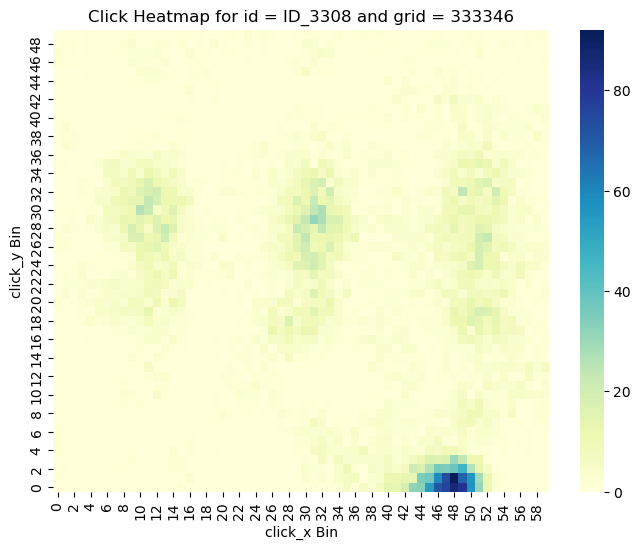

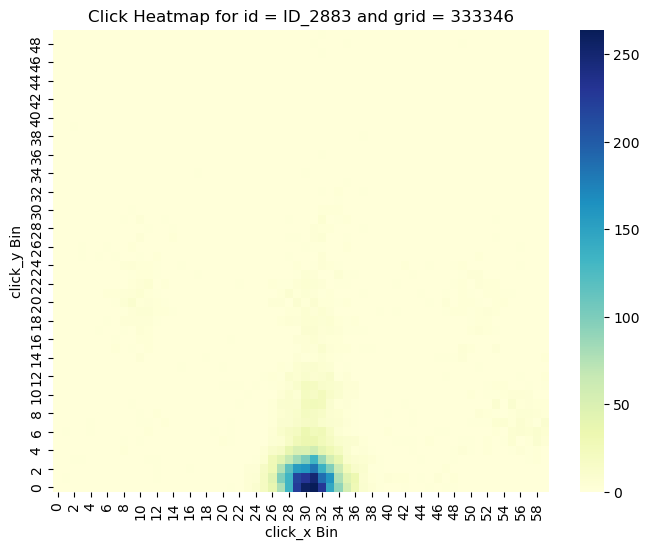

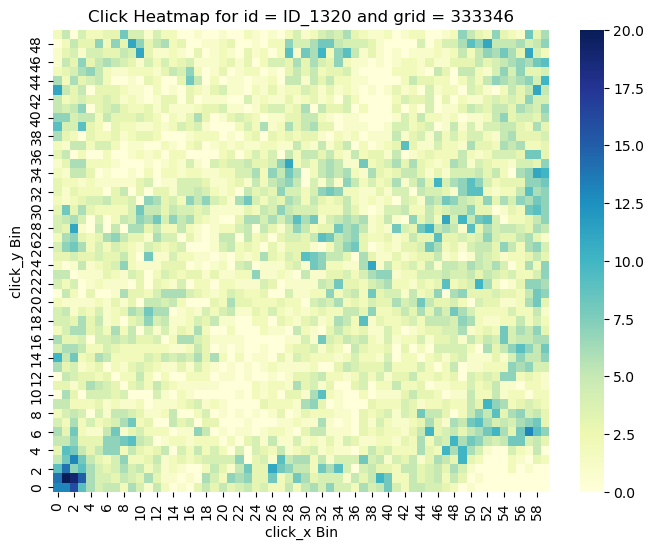

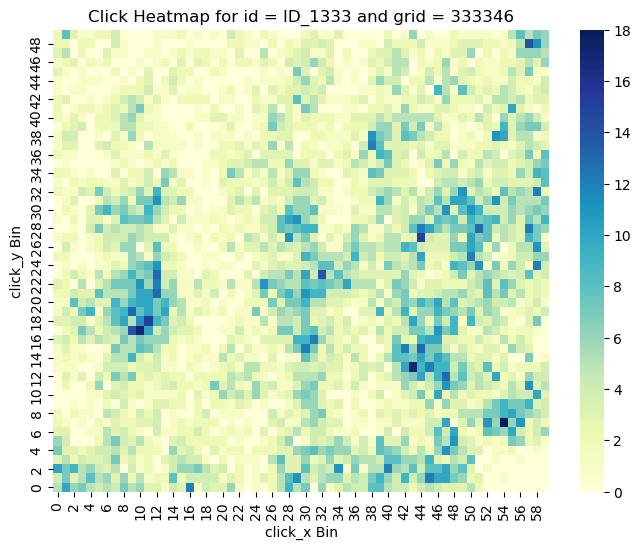

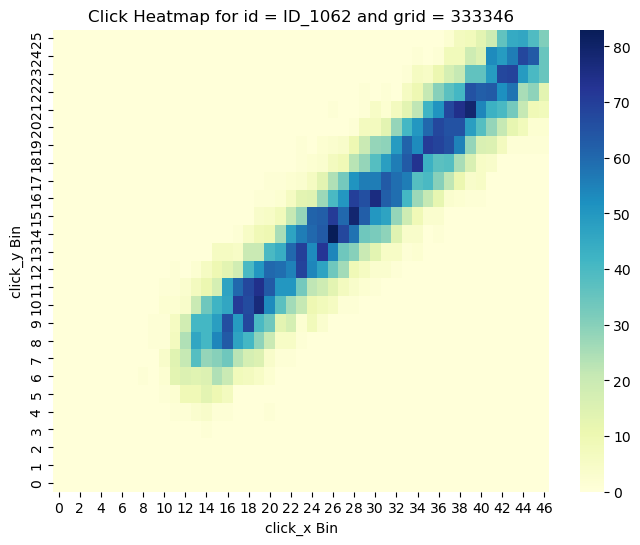

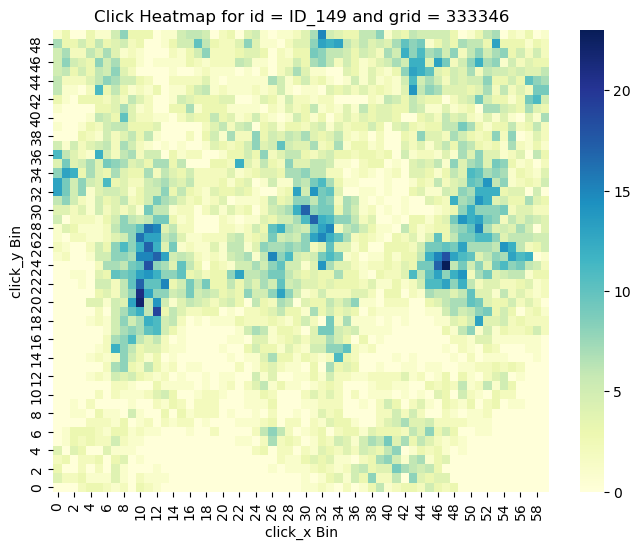

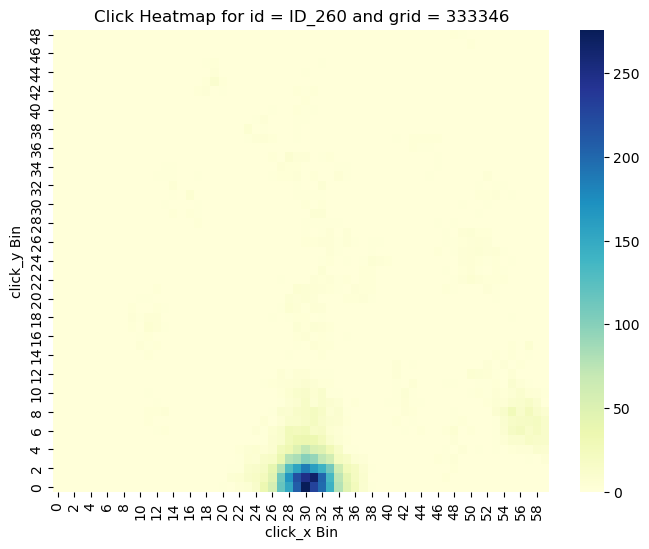

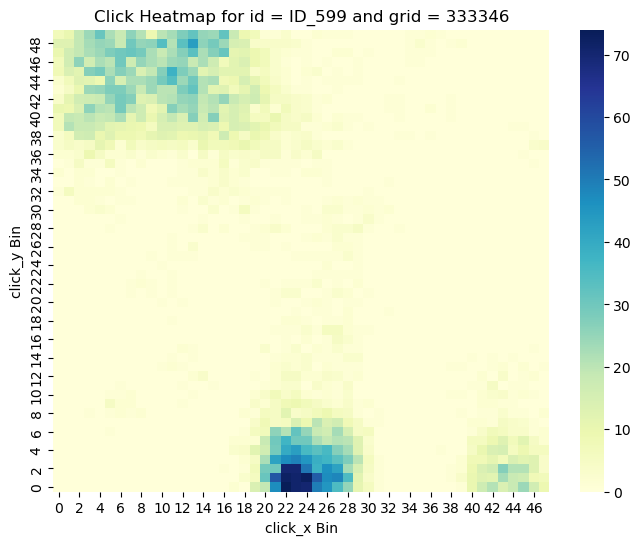

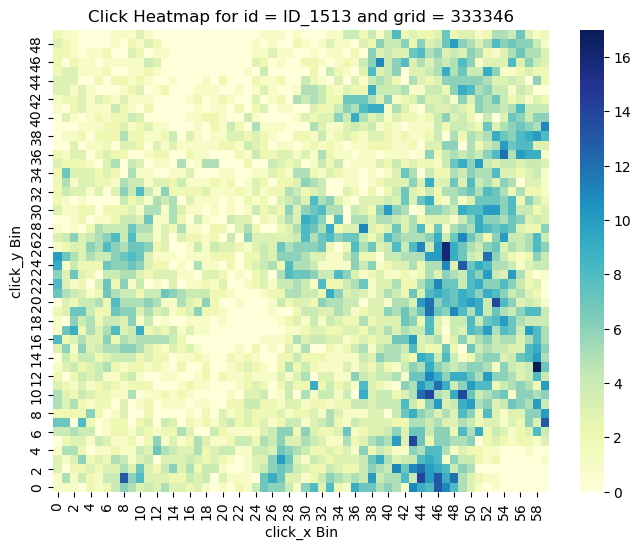

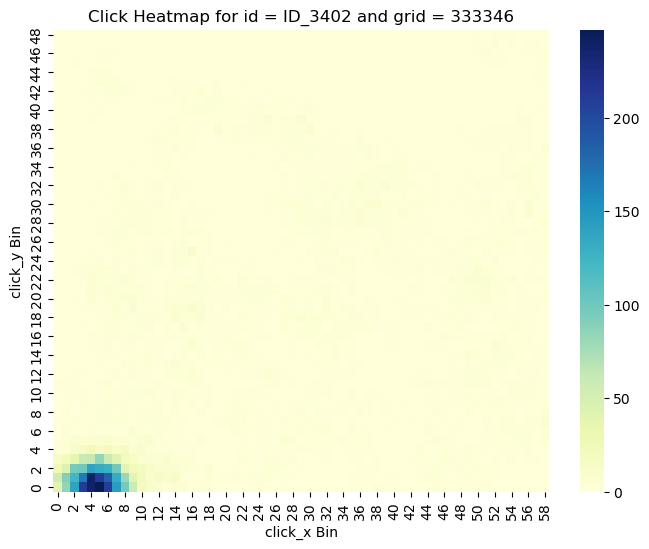

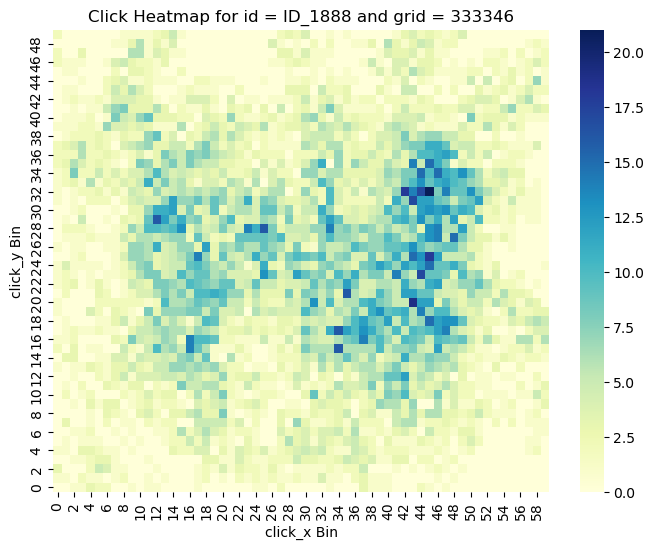

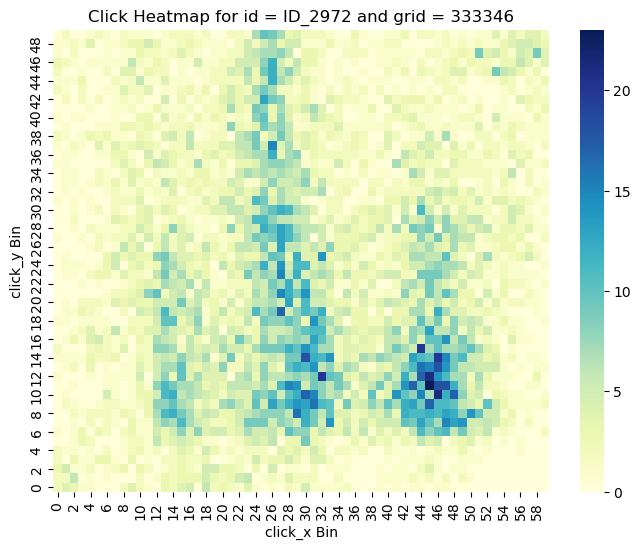

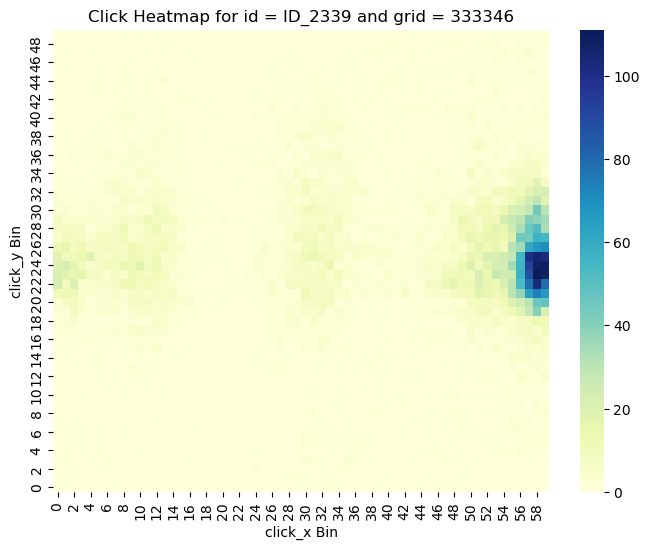

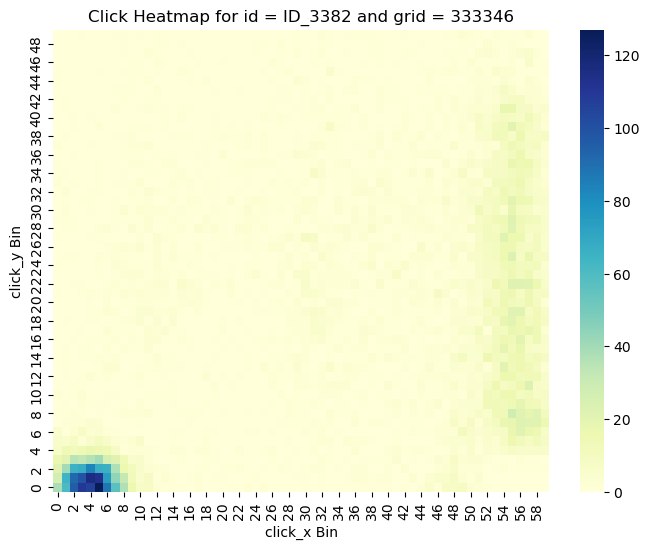

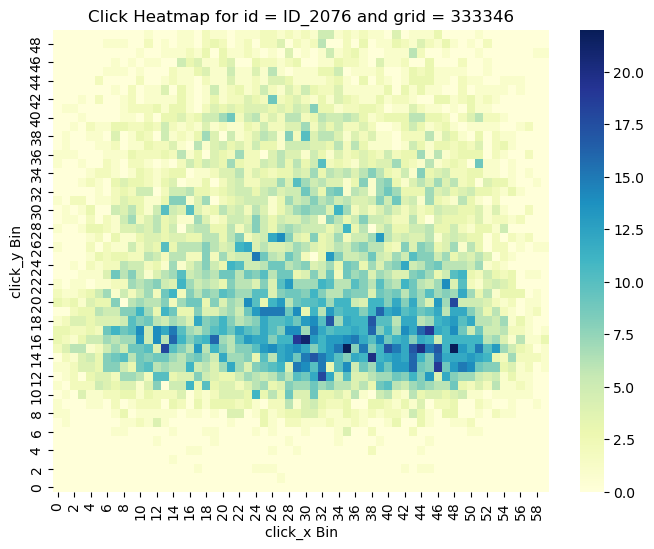

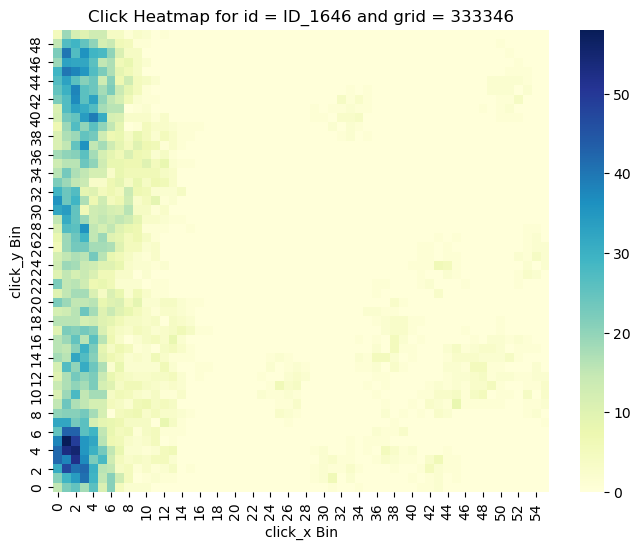

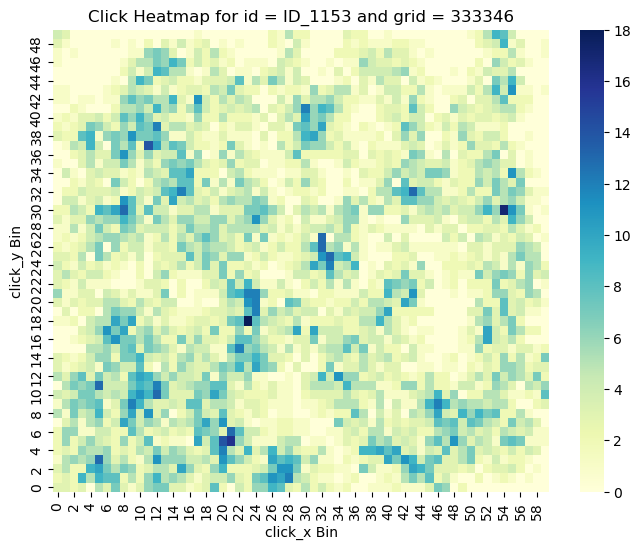

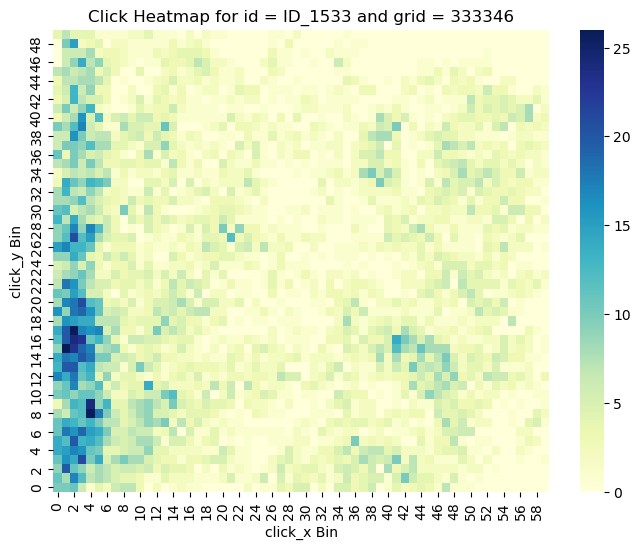

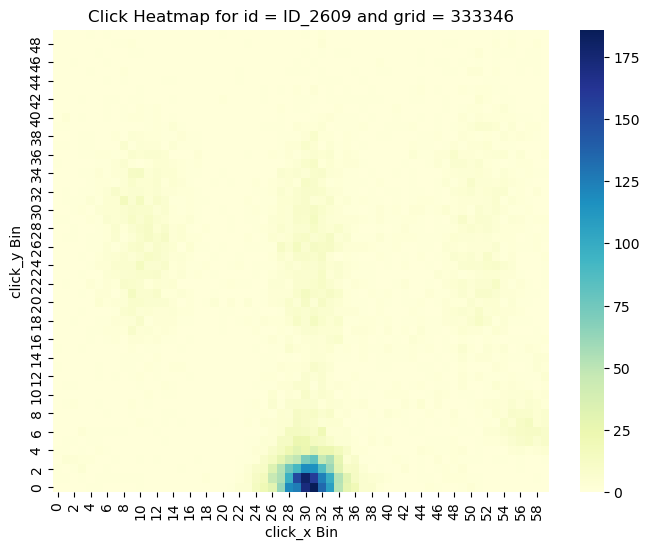

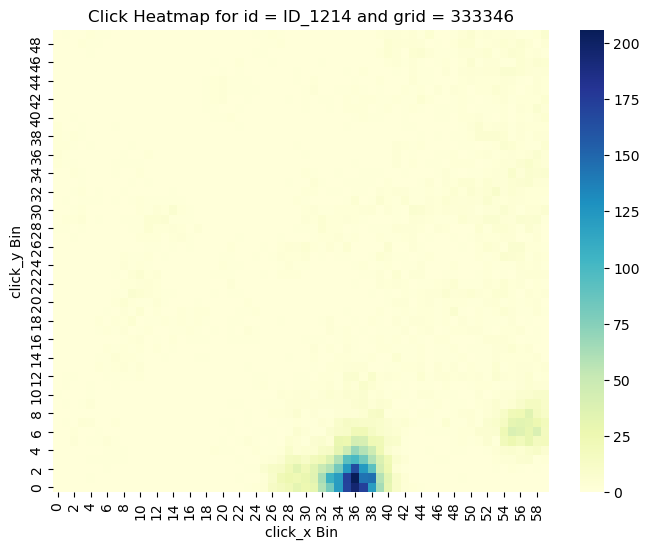

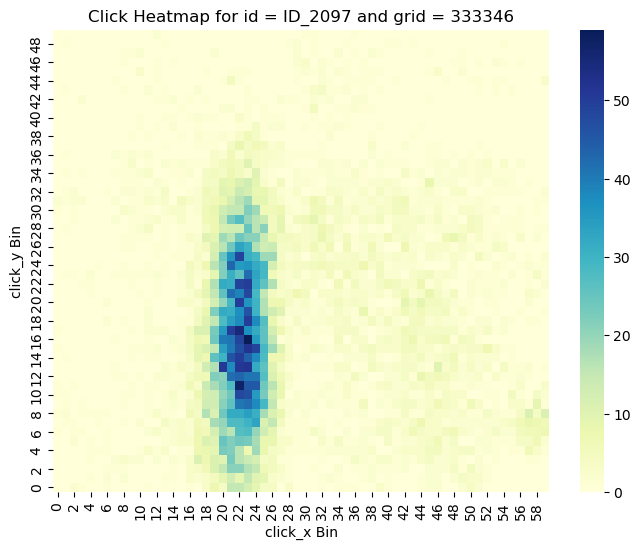

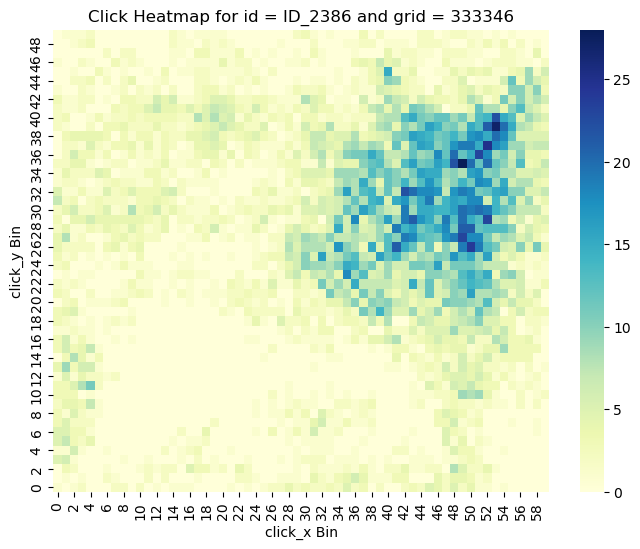

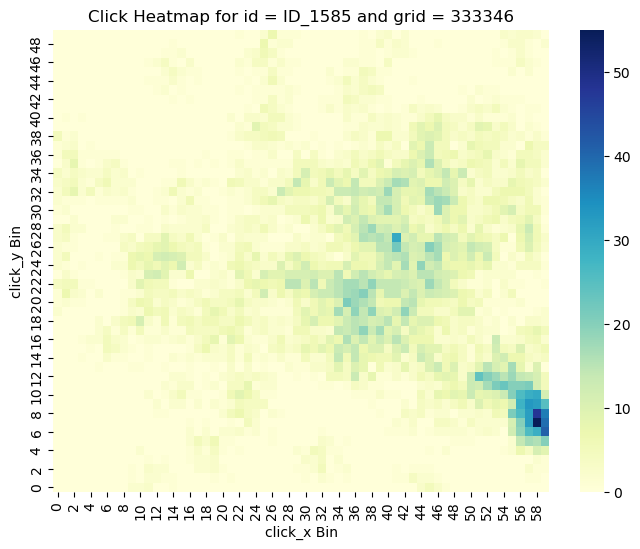

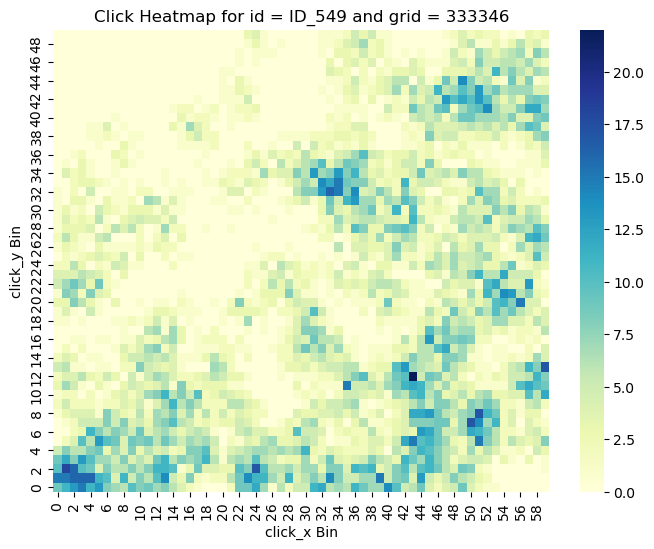

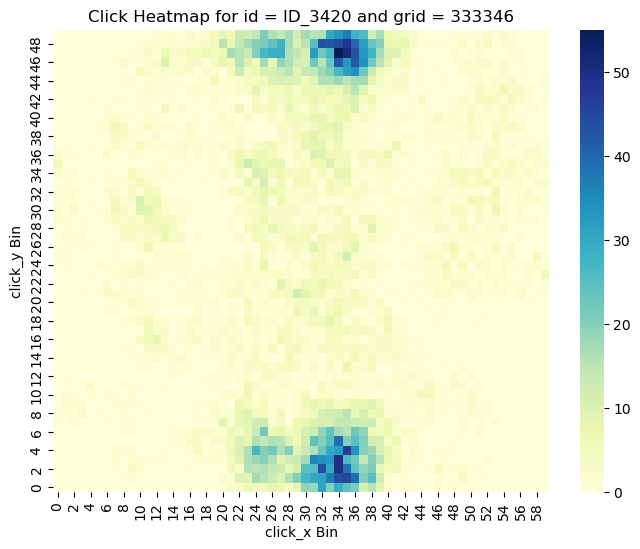

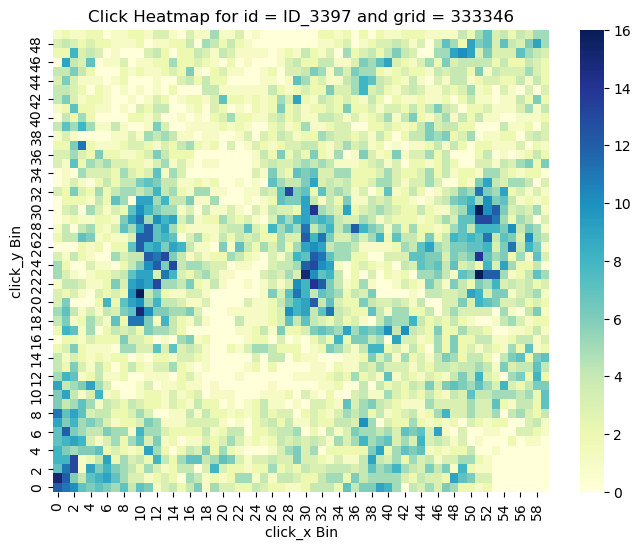

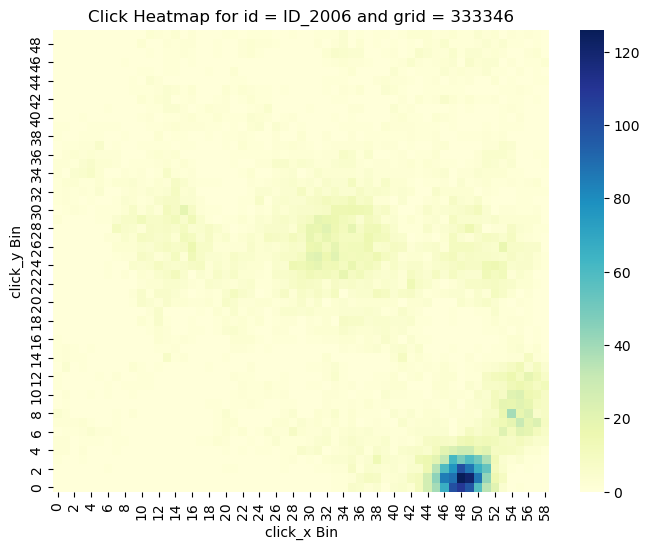

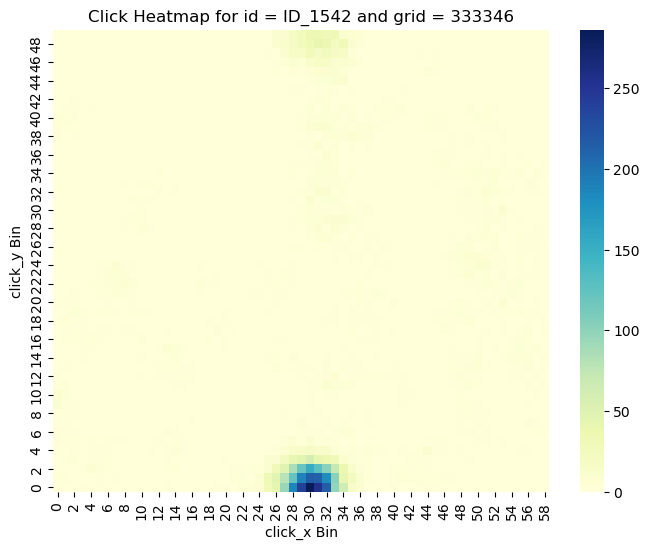

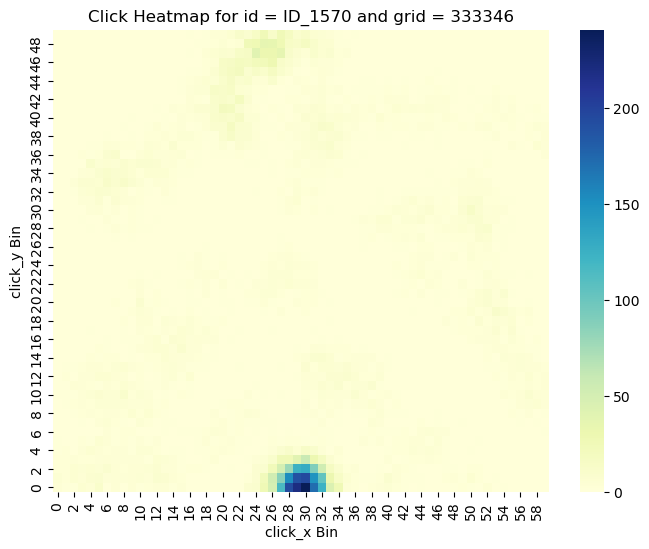

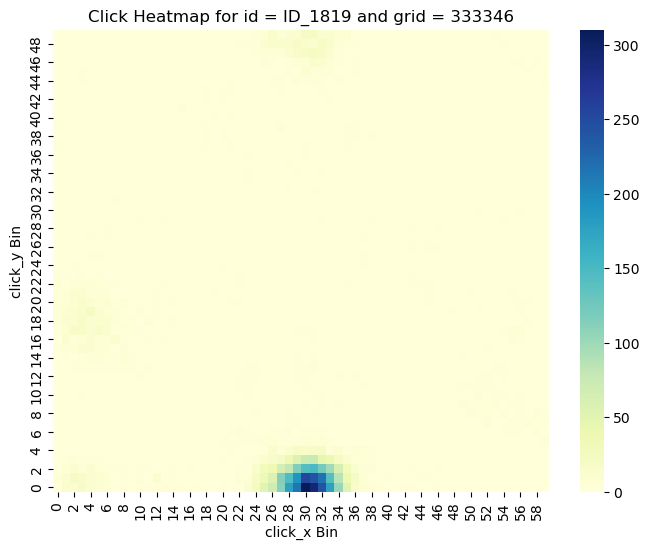

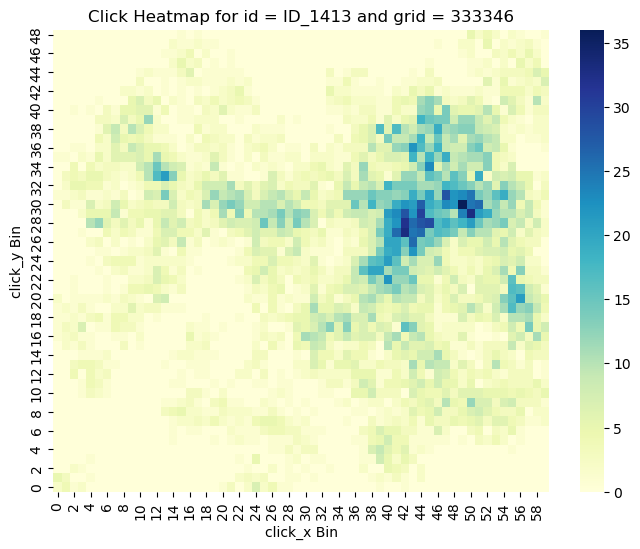

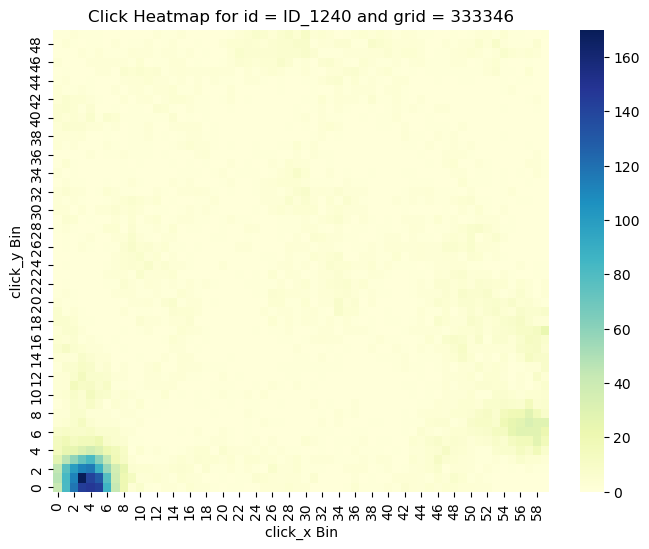

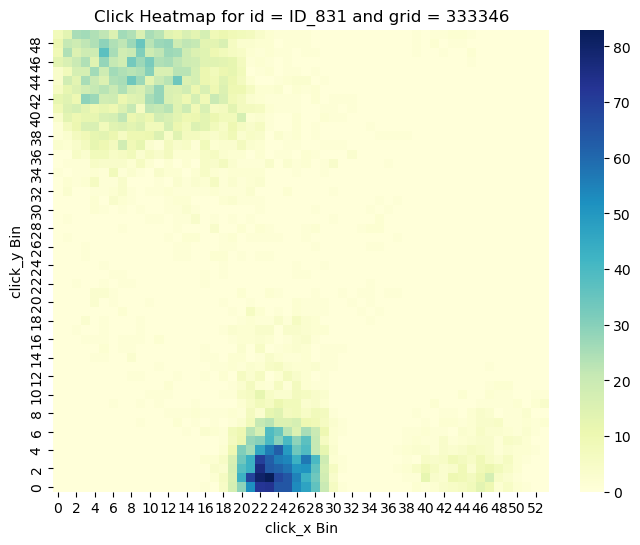

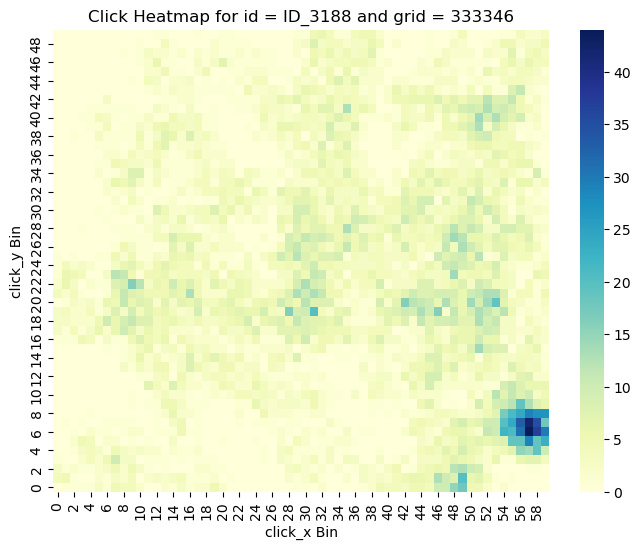

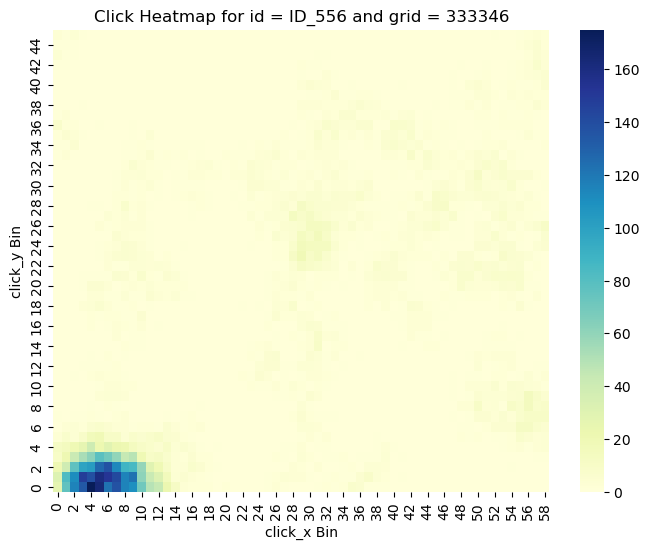

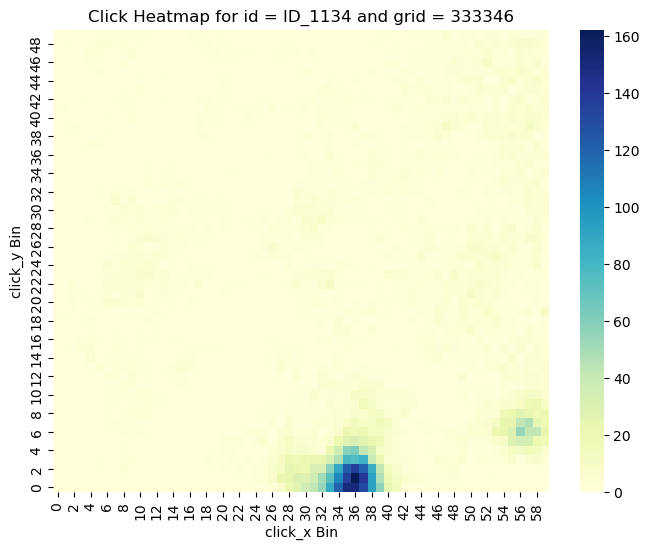

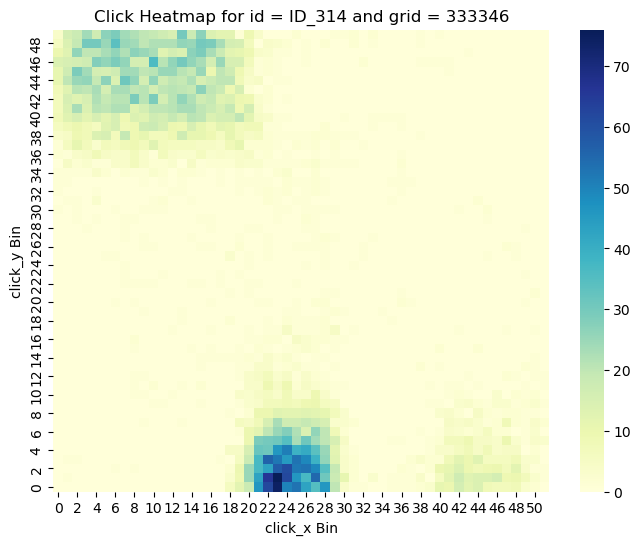

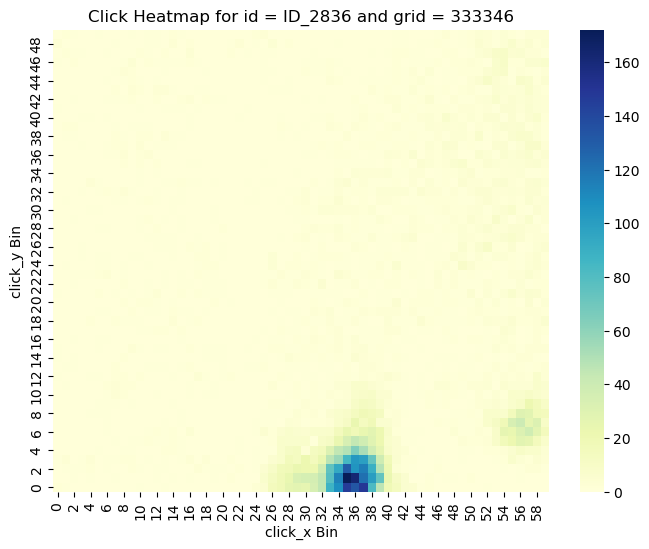

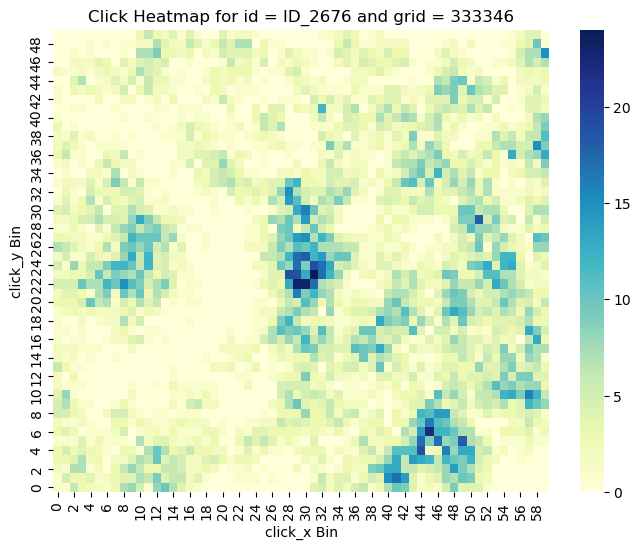

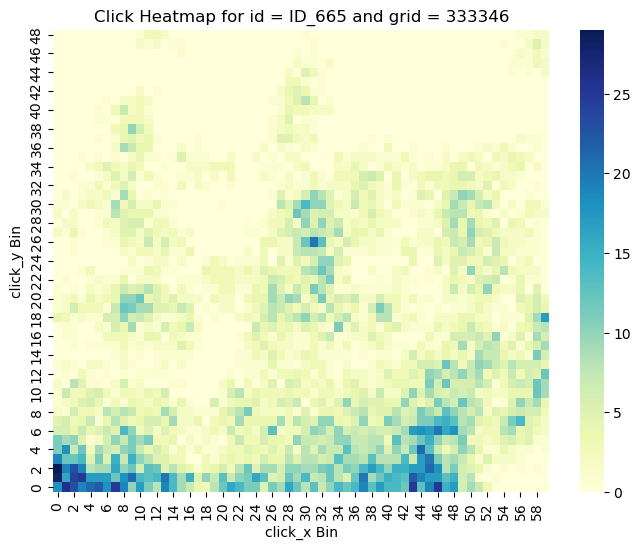

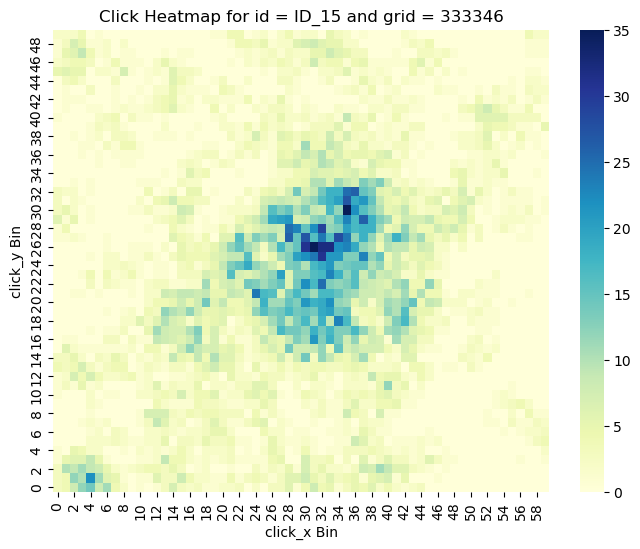

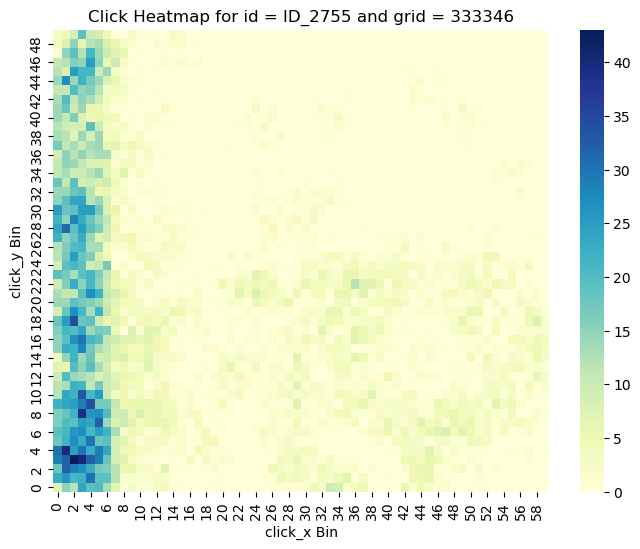

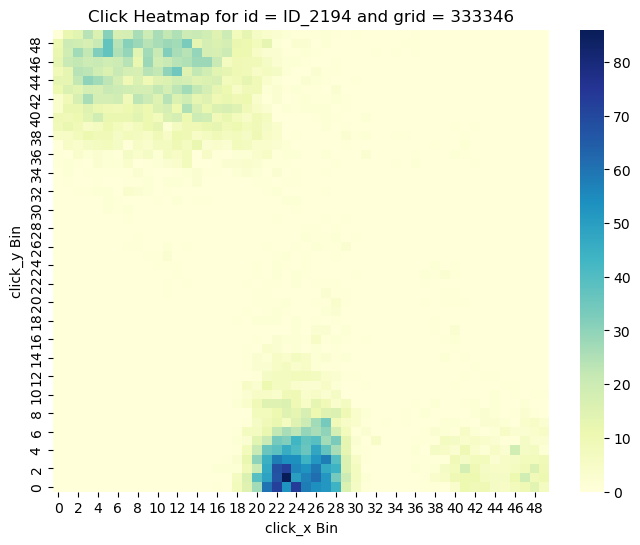

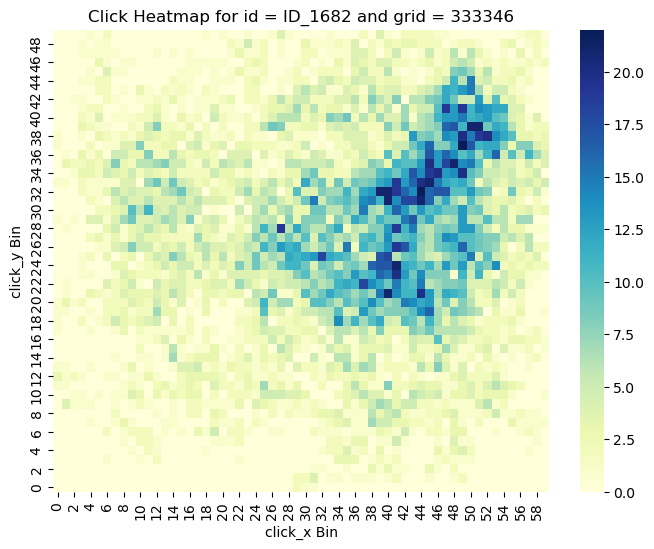

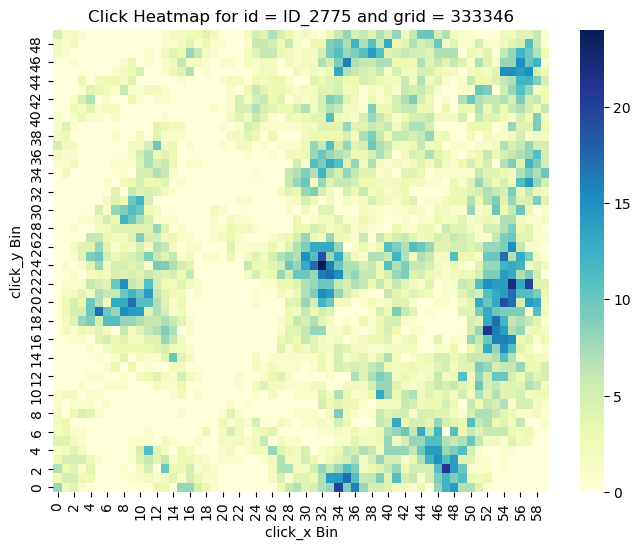

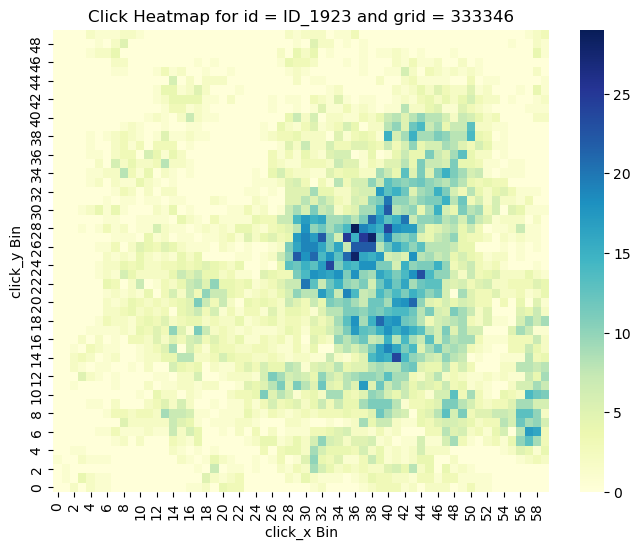

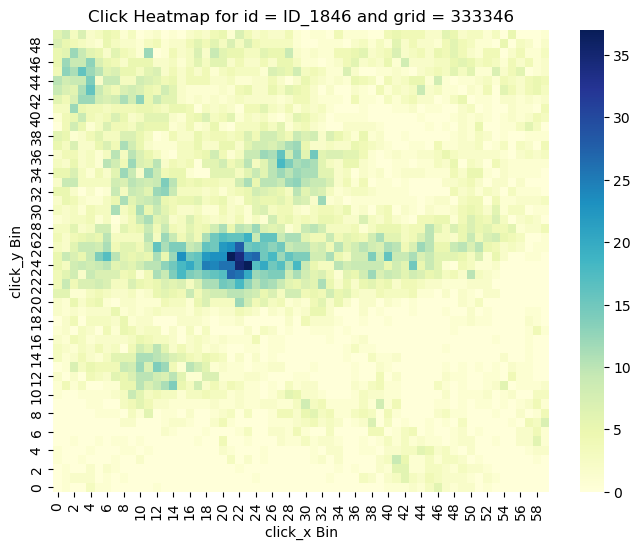

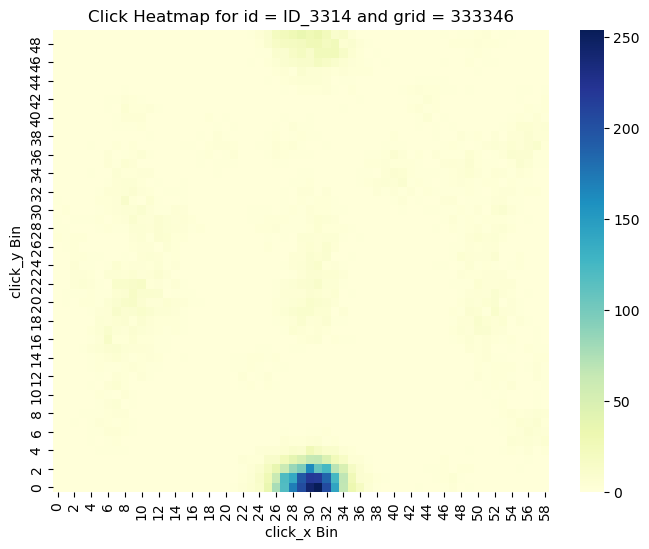

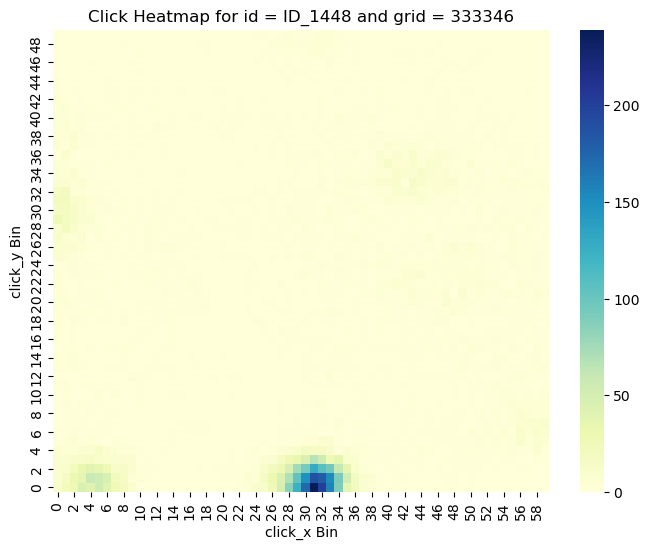

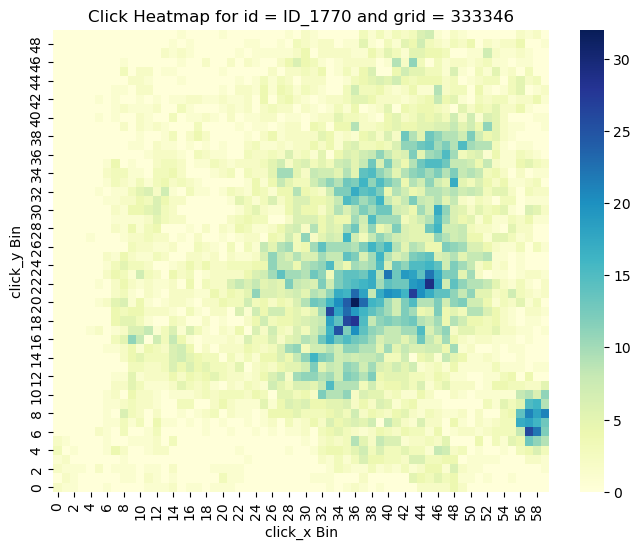

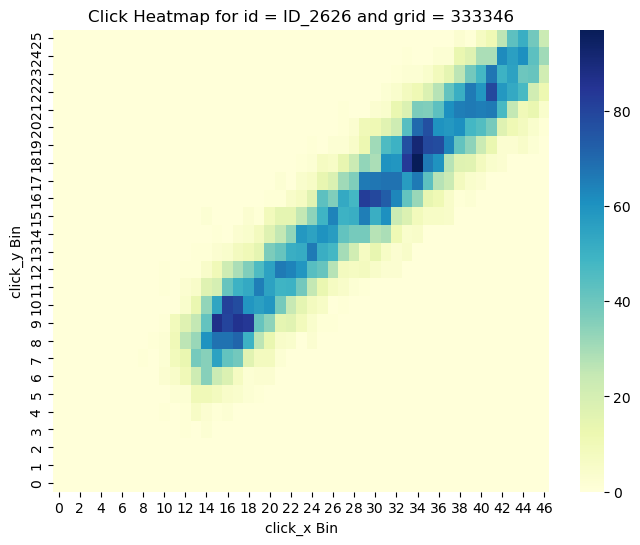

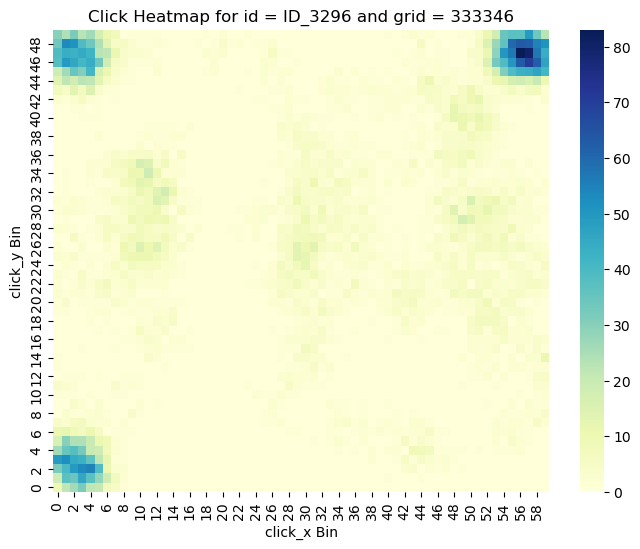

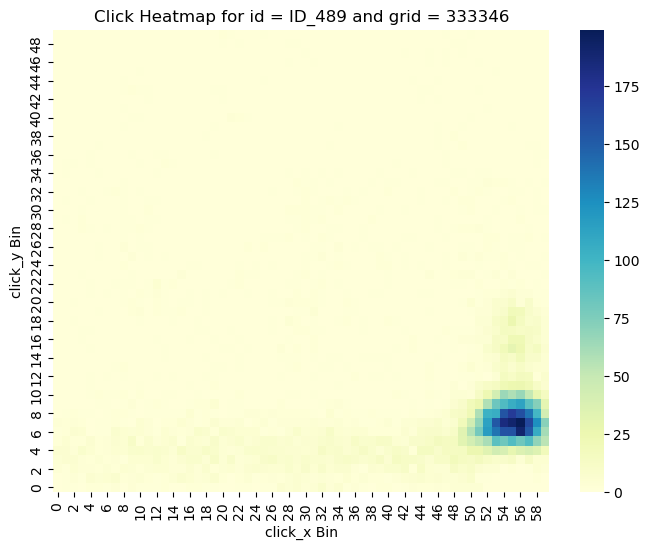

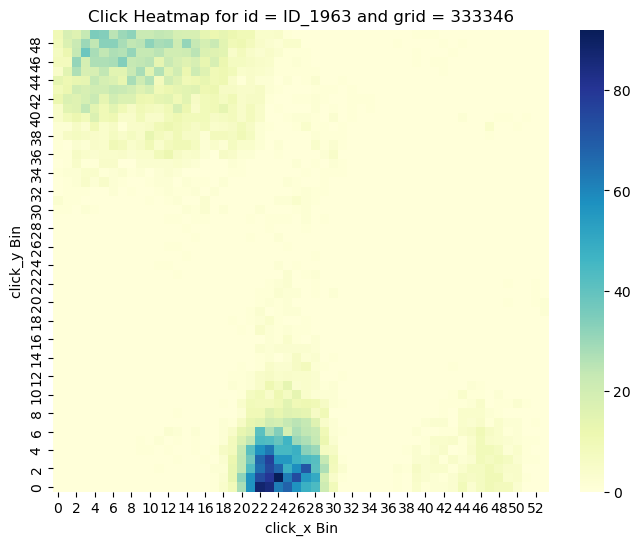

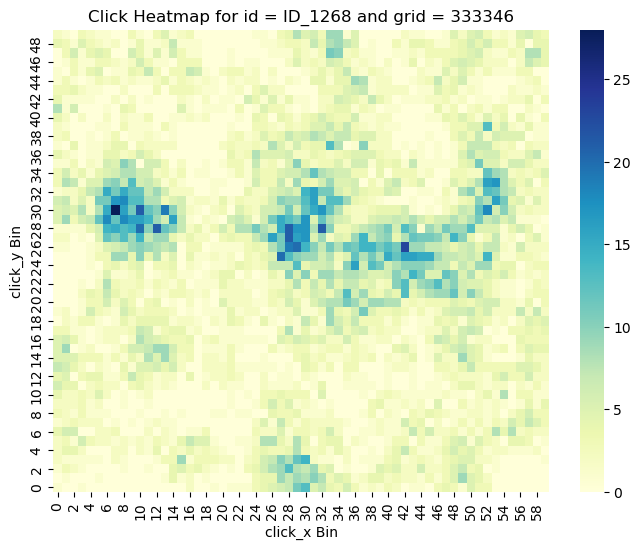

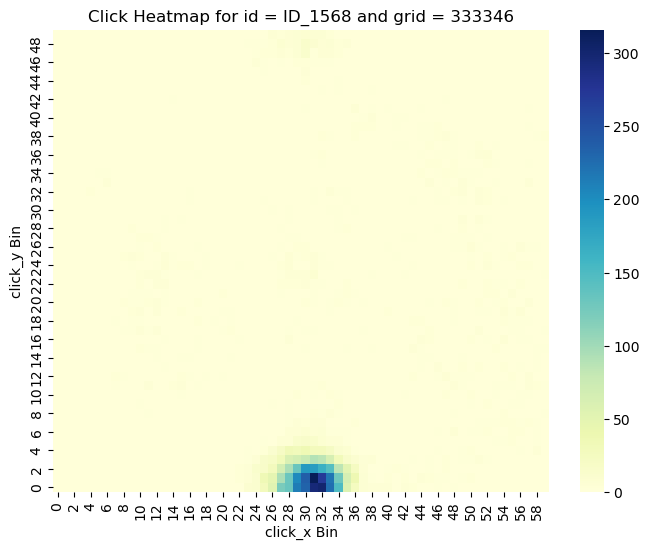

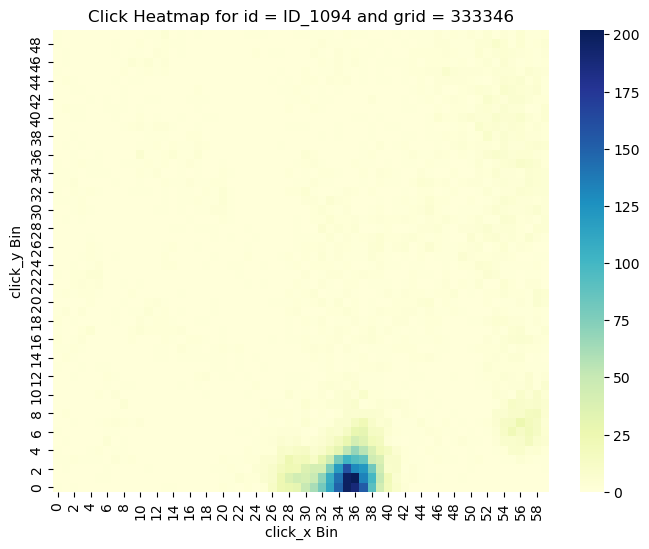

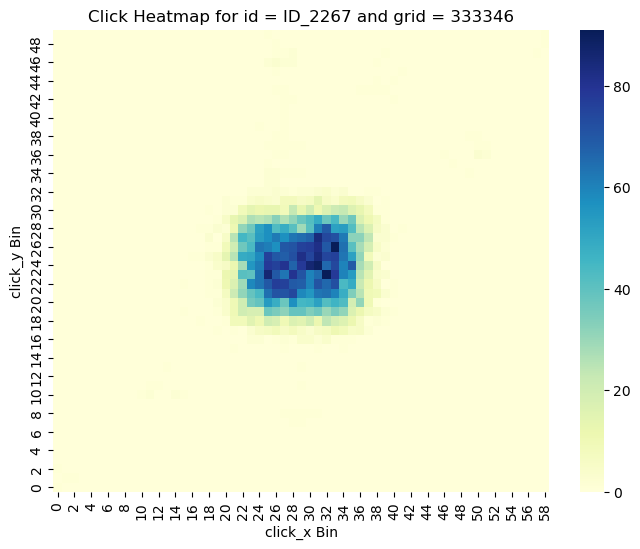

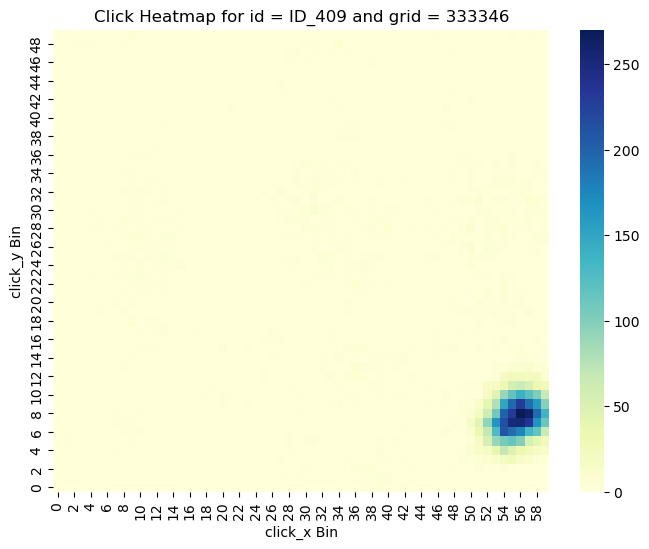

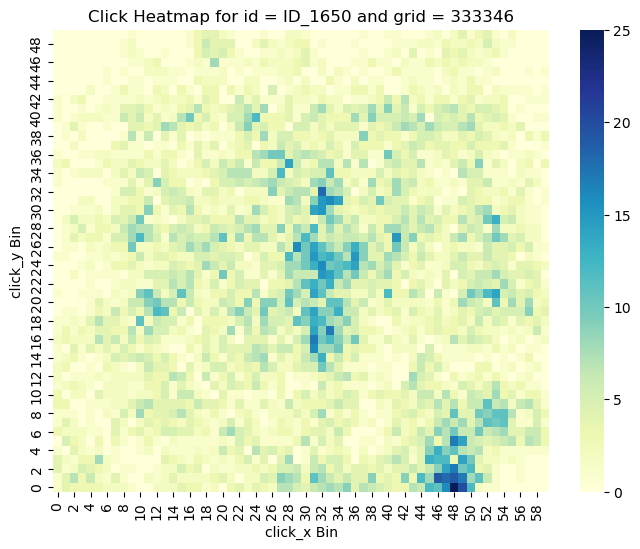

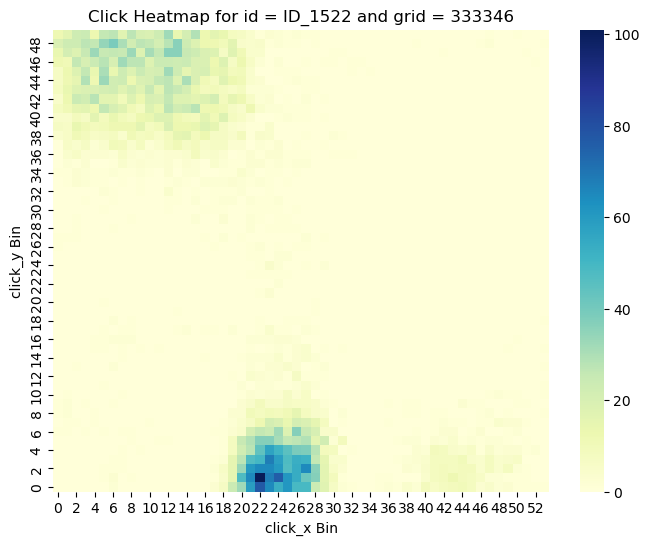

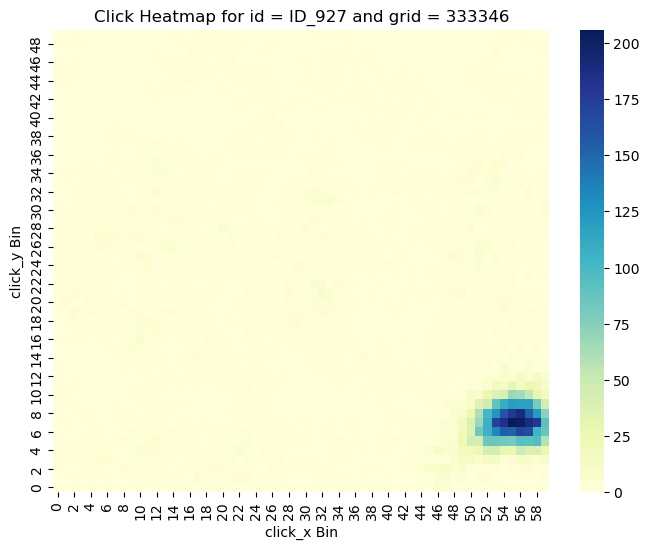

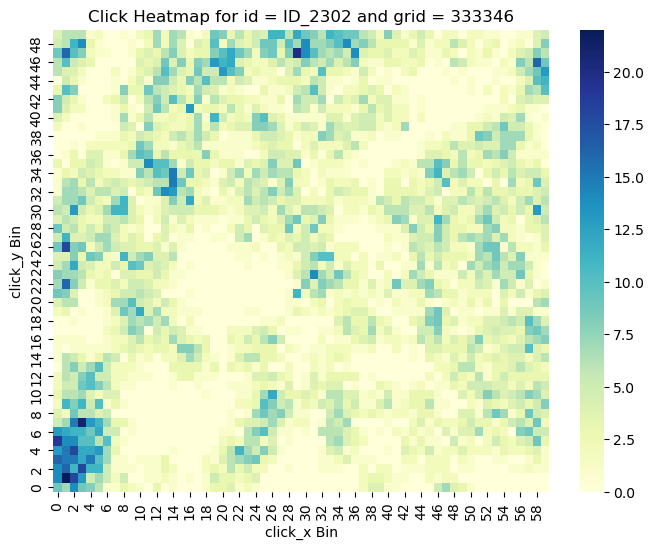

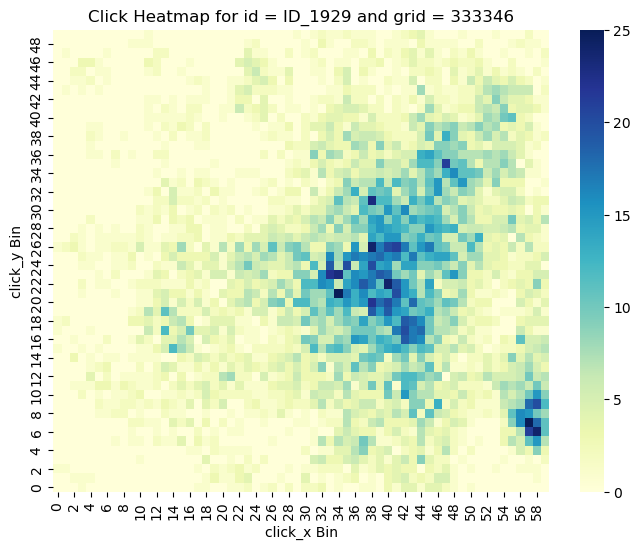

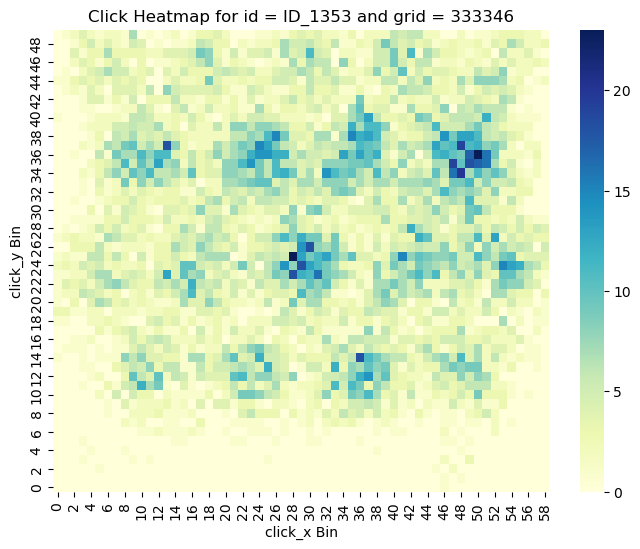

In [109]:
for dom in cb[333346]:
    if dom not in misid[1e-06]['FN']:
        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
                                     (aggregated_clicks.domain == dom)]
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()

## False Negative

Total clicks for (grid_id, domain): (333346, ID_10): 2257


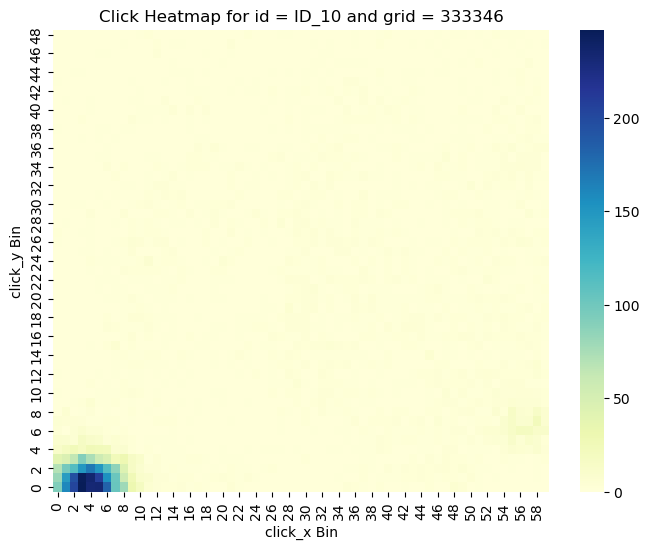

Total clicks for (grid_id, domain): (333346, ID_1030): 482


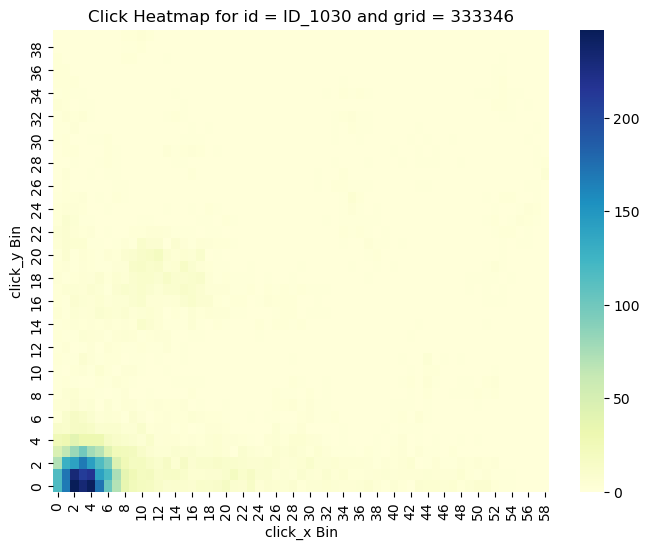

Total clicks for (grid_id, domain): (333346, ID_1077): 366


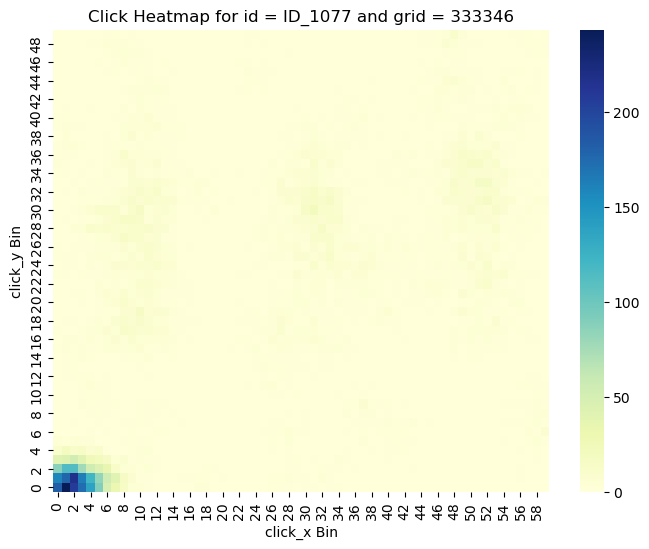

Total clicks for (grid_id, domain): (333346, ID_1238): 302


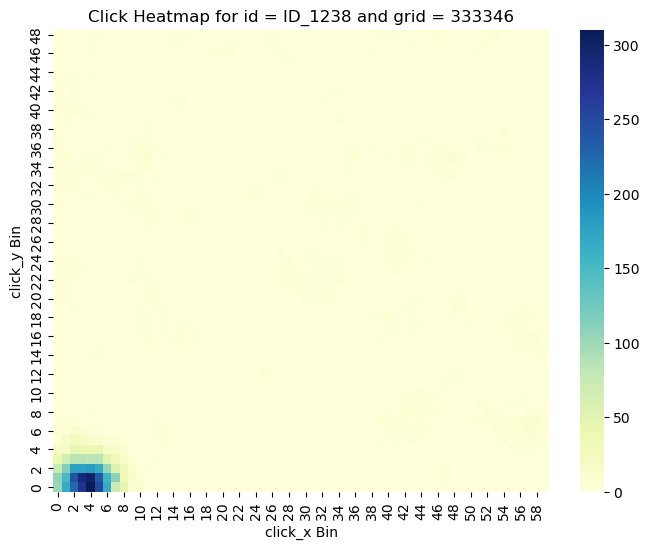

Total clicks for (grid_id, domain): (333346, ID_1262): 951


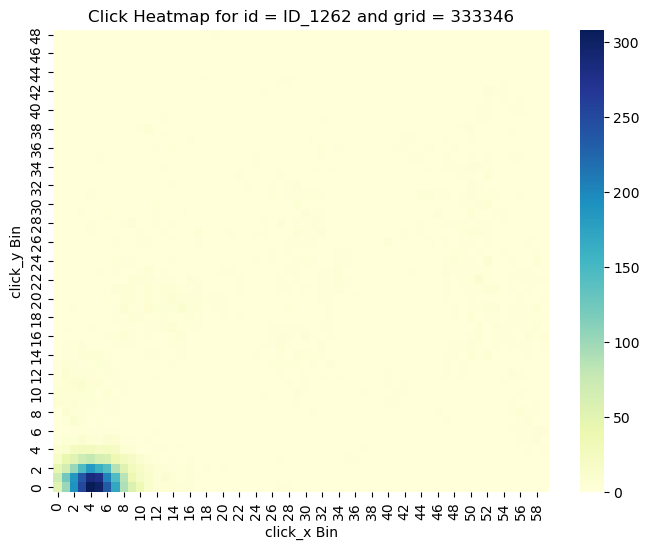

Total clicks for (grid_id, domain): (333346, ID_1435): 253


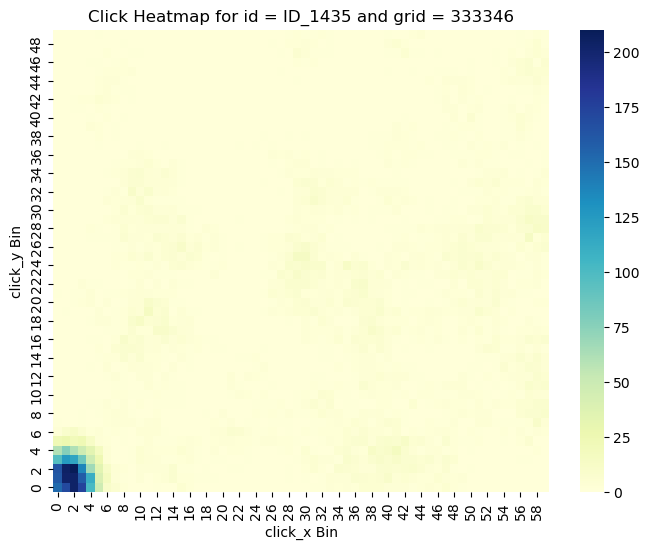

Total clicks for (grid_id, domain): (333346, ID_1437): 671


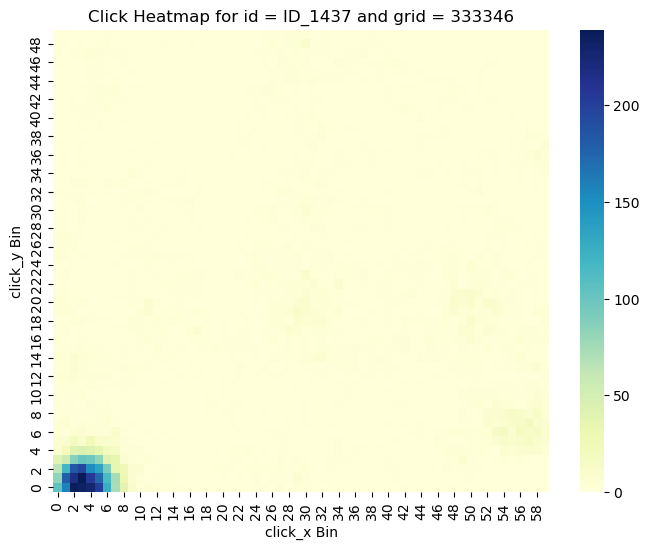

Total clicks for (grid_id, domain): (333346, ID_1483): 465


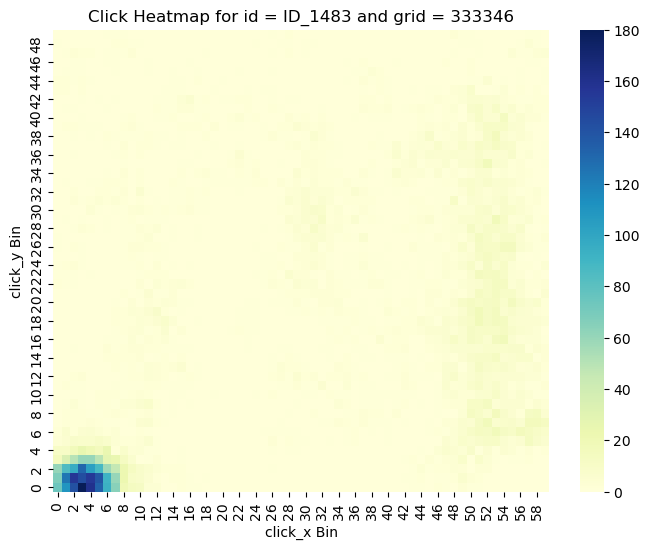

Total clicks for (grid_id, domain): (333346, ID_2569): 1806


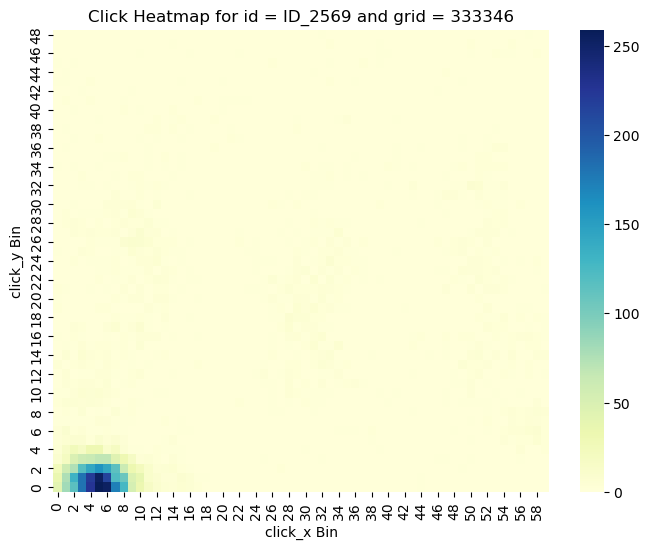

Total clicks for (grid_id, domain): (333346, ID_2619): 541


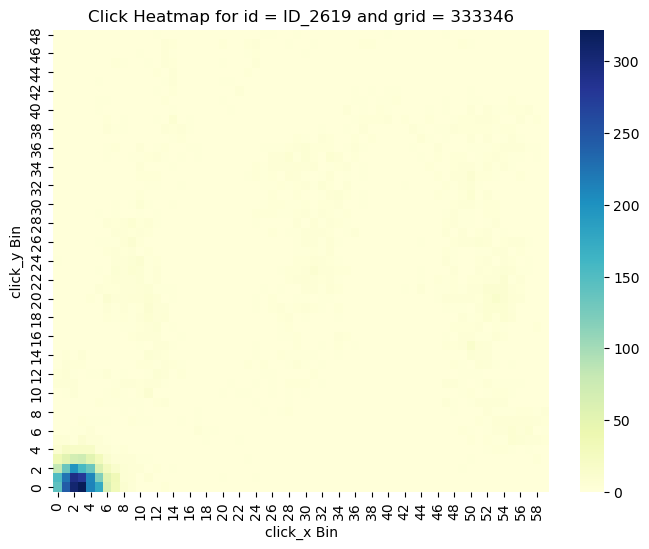

Total clicks for (grid_id, domain): (333346, ID_2742): 838


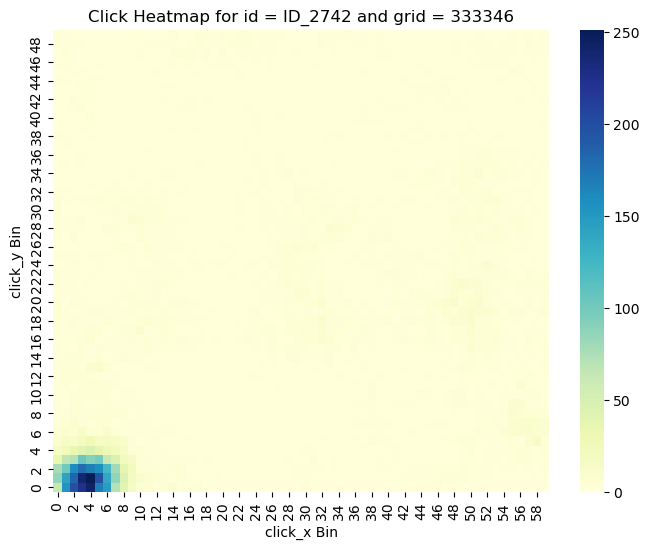

Total clicks for (grid_id, domain): (333346, ID_3180): 63165


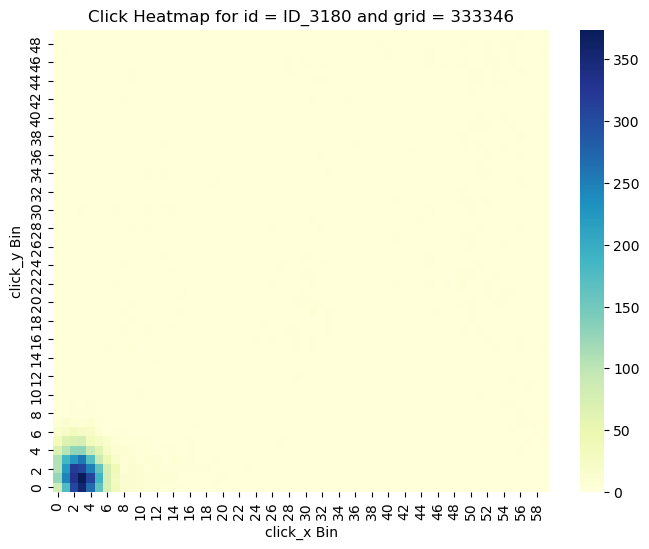

Total clicks for (grid_id, domain): (333346, ID_398): 856


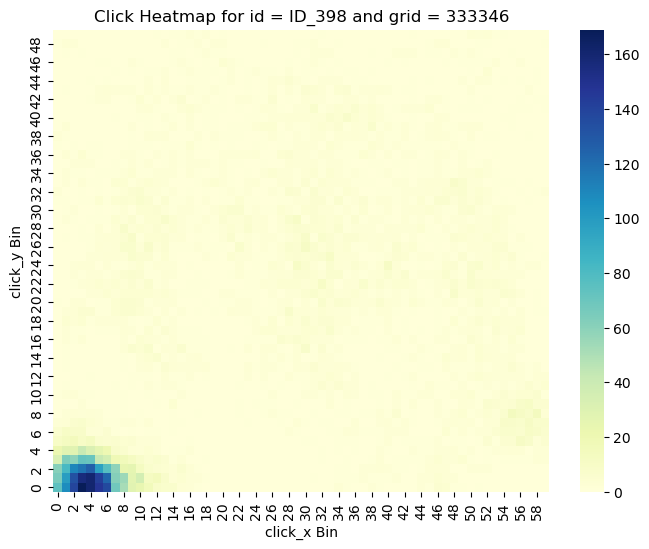

Total clicks for (grid_id, domain): (333346, ID_561): 1009


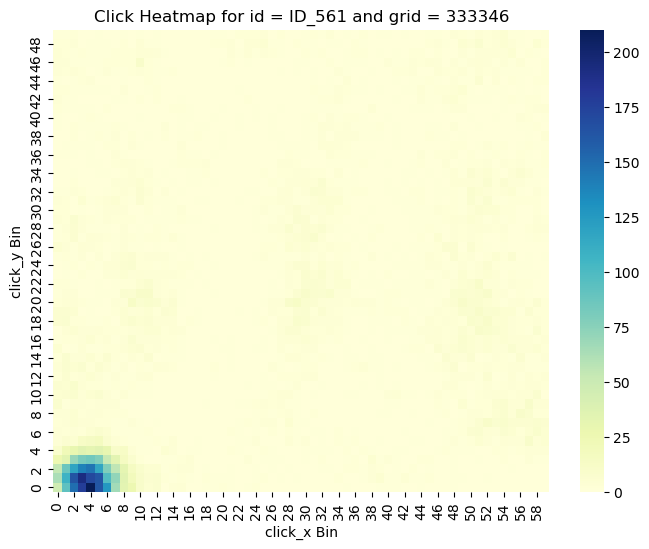

Total clicks for (grid_id, domain): (333346, ID_793): 930


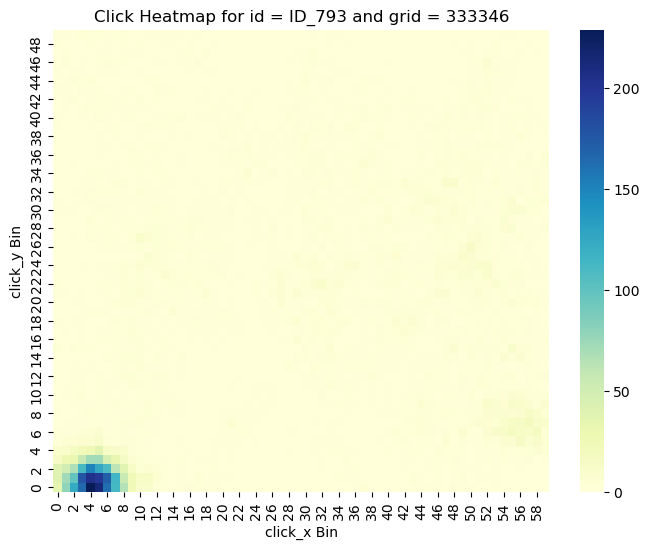

Total clicks for (grid_id, domain): (333346, ID_810): 270


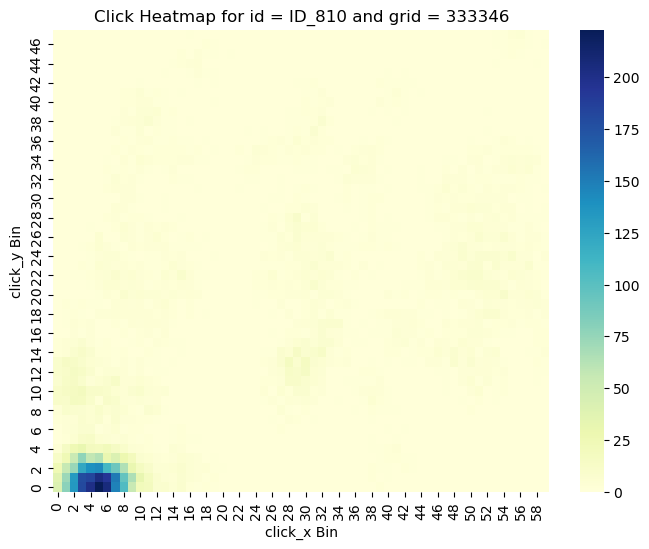

In [113]:
for dom in misid[1e-06]['FN']:
    if dom in unique_gd_comb[unique_gd_comb.grid_id == 333346].domain.unique():

        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
                                     (aggregated_clicks.domain == dom)]
        
        print(f'Total clicks for (grid_id, domain): (333346, {dom}): {data_obs.clicks_sum.sum()}')
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()
    elif  dom in unique_gd_comb[unique_gd_comb.grid_id == 333519].domain.unique():
        data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
                                     (aggregated_clicks.domain == dom)]
        print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
        data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
        data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
        click_matrix = data_obs_enh.pivot("click_y_bin",
                                          "click_x_bin",
                                          "clicks_sum").fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(click_matrix, 
                    cmap = "YlGnBu", 
                    annot = False, 
                    cbar = True, 
                    fmt = "g")
        plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
        plt.xlabel('click_x Bin')
        plt.ylabel('click_y Bin')
        plt.gca().invert_yaxis() 
        plt.show()

# Emp distro = representative

Total clicks for (grid_id, domain): (333519, ID_1501): 196561


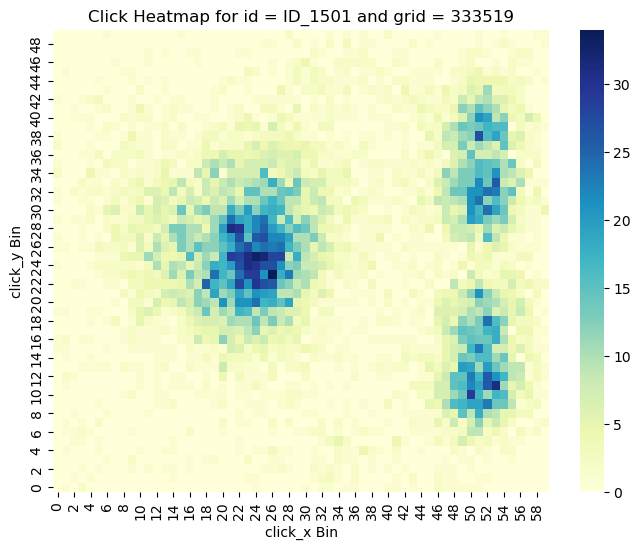

Total clicks for (grid_id, domain): (333519, ID_1501): 86364


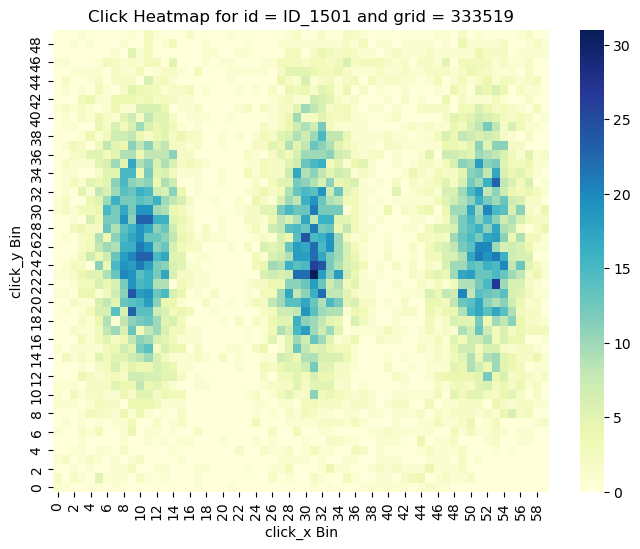

In [134]:
# pick most clicks and highest landing rate:

representative_heatmap = {}

for g_id in [333519, 333346]:
    filtered_data = data_metrics[data_metrics.grid_id == g_id]

    result = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
    dom = result.sort_values(by='clicks', ascending=False).iloc[0].domain
    representative_heatmap[g_id] = dom
    
    data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                 (aggregated_clicks.domain == dom)]
    print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
    click_matrix = data_obs_enh.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [175]:
# upsampling size:
# size = 1000

# avoid dividing by 0:
eps = 1e-8

# stdev for noisy bootstrap enhancement:
stdev = 0

# init to count pct of broken banners:
tot_p, tot, tot_pv, tot_lrt = 0, 0, 0, 0

# keep track of misidentified:
misid = {}
misid1 = {}

# p-value threshold for chi-squared test:
pv_thresh = 0.0000001

# probability threshold:
# proba_thres = 0.0000001

for stdev in [0, 1, 2]:
    for size in [1000, 5000, 10000]:
        for proba_thres in [0.1, 0.001, 0.00001, 0.0000001]:

            misid[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
            TP, TN, FP, FN = 0, 0, 0, 0
            
            misid1[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
            TP1, TN1, FP1, FN1 = 0, 0, 0, 0

            for g_id in [333519, 333346]: 

                # data = repr clicks for grid_id = g_id (in principle should probably do some train/test split):
                data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

                # compute probability by bin
                # data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

                data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]
                
                # representative probabilities:
                data_obs_rep = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                                 (aggregated_clicks.domain == representative_heatmap[g_id])]

                # merge enhanced observed heatmap with empirical distribution
                # in order to get empircal probabilities for bins:
                data_obs_rep = data_obs_rep.merge(data, 
                                              on=['click_x_bin','click_y_bin'], 
                                              how='right').fillna(0)
                data_obs_rep['proba'] = data_obs_rep.clicks_sum_x/data_obs_rep.clicks_sum_x.sum()

                data = data.merge(data_obs_rep[['click_x_bin','click_y_bin','proba']], 
                                  on = ['click_x_bin','click_y_bin'], 
                                  how='left' )
                
                data = data.fillna(0)

                '''
                compute probability for "average" heatmap based on bootstrap sampling of data. 

                The empirical distribution is given by the proba columns and we bootstrap
                sample based on that column as well as evaluate the log-probability.

                The bootstrapped sample is of size = size (notice that the size should be 
                the same as the size for the instance-heatmap to get "fair" comparison, if not
                we would have to normalize accordingly).

                n_bootstrap = number of generated heatmaps to compute average.

                The following returns the avg log-probability:
                '''
                avg_from_empirical = weighted_bootstrap_resample(data, 
                                                                 'proba', 
                                                                 'proba', 
                                                                 size, 
                                                                 n_bootstraps=1000)

                avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
                                                                 'proba', 
                                                                 'proba', 
                                                                 size, 
                                                                 n_bootstraps=1000)


                # run over domains, dom for given grid_id = g_id:
                for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
                    tot += 1

                    ####################
                    # chi-squared method:
                    # returns p-value for chi-squared comparison of heatmap vs empirical distribution
                    _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
                                                          aggregated_clicks_by_grid, 
                                                          dom, g_id, size, .5)

                    ####################
                    # log-probability method:

                    # data_obs = "observed" heatmap for current domain_id = dom
                    data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                                 (aggregated_clicks.domain == dom)]

                    # add proba column in order to do bootstrap enhancement:
                    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

                    # enhanced observed heatmap of size = size, with stdev = stdev 
                    # and sampling based on proba column:
                    data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

                    # merge enhanced observed heatmap with empirical distribution
                    # in order to get empircal probabilities for bins:
                    data_obs = data_obs_enh.merge(data, 
                                                  on=['click_x_bin','click_y_bin'], 
                                                  how='right').fillna(0)

                    # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
                    from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum_x']).sum()

                    # compare with average heatmap from empirical distribution:
                    # prob = P[distr for domain]/P[avg distr]
                    prob = np.exp(from_obs - avg_from_empirical)
                    log_prob = from_obs - avg_from_empirical

                    # if log_prob below certain threshold, label as broken:

                    if log_prob < np.log(proba_thres):
                        tot_p +=1

                    # compare both log-prob and chi-squared p-value:
                    if log_prob < np.log(proba_thres) and pv < pv_thresh:
                        tot_pv += 1

                    ####################
                    # "lrt" method:

                    data_obs_bad = data_obs_enh.merge(data_bad, 
                                                  on=['click_x_bin','click_y_bin'], 
                                                  how='right').fillna(0)

                    from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum_x']).sum()

                    loglrt = from_obs - from_obs_bad

                    if loglrt < np.log(proba_thres):
                        tot_lrt += 1
                        if dom in cb[g_id]:
                            TP += 1
                        else:
                            FP += 1
                            misid[(stdev,size,proba_thres)]['FP'].append(dom)
                    else:
                        if dom in cb[g_id]:
                            FN += 1
                            misid[(stdev,size,proba_thres)]['FN'].append(dom)
                        else:
                            TN += 1
                            
                            
                    if log_prob < np.log(proba_thres):
                        tot_lrt += 1
                        if dom in cb[g_id]:
                            TP1 += 1
                        else:
                            FP1 += 1
                            misid1[(stdev,size,proba_thres)]['FP'].append(dom)
                    else:
                        if dom in cb[g_id]:
                            FN1 += 1
                            misid1[(stdev,size,proba_thres)]['FN'].append(dom)
                        else:
                            TN1 += 1

            print(f'Standard dev: {stdev}')
            print(f'Upsample size: {size}')
            print(f'Probability thresh: {proba_thres}')
            print(f'Confusion matrix (lrt): ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
            print(f'Confusion matrix (old): ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
            print('-----------------------------------------------------------')
            

Standard dev: 0
Upsample size: 1000
Probability thresh: 0.1
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1530,4),(33,166)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (286,0),(1277,170)
-----------------------------------------------------------
Standard dev: 0
Upsample size: 1000
Probability thresh: 0.001
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1529,6),(34,164)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (297,0),(1266,170)
-----------------------------------------------------------
Standard dev: 0
Upsample size: 1000
Probability thresh: 1e-05
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1527,6),(36,164)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (321,0),(1242,170)
-----------------------------------------------------------
Standard dev: 0
Upsample size: 1000
Probability thresh: 1e-07
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1533,4),(30,166)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (310,0),(1253,170)
-----------------------------------------------------------
Standard dev: 

Standard dev: 2
Upsample size: 10000
Probability thresh: 1e-05
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1518,5),(45,165)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (73,46),(1490,124)
-----------------------------------------------------------
Standard dev: 2
Upsample size: 10000
Probability thresh: 1e-07
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1516,5),(47,165)
Confusion matrix (old): ((TN,FN),(FP,TP)) = (75,44),(1488,126)
-----------------------------------------------------------


# Old method

In [178]:
# upsampling size:
size = 1000

eps = 1e-20

# stdev for noisy bootstrap enhancement:
stdev = 0

# init to count pct of broken banners:
tot_p, tot, tot_pv, tot_lrt = 0, 0, 0, 0

# keep track of misidentified:
misid = {}

# p-value threshold for chi-squared test:
pv_thresh = 0.0000001

# probability threshold:
# proba_thres = 0.0000001

for proba_thres in [0.01, 0.00000001]:
    
    misid[proba_thres] = {'FN': [], 'FP': []}
    TP, TN, FP, FN = 0, 0, 0, 0
    
    for g_id in [333519, 333346]: 

        # data = all clicks for grid_id = g_id (in principle should probably do some train/test split):
        data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

        # compute probability by bin
        data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

        '''
        compute probability for "average" heatmap based on bootstrap sampling of data. 

        The empirical distribution is given by the proba columns and we bootstrap
        sample based on that column as well as evaluate the log-probability.

        The bootstrapped sample is of size = size (notice that the size should be 
        the same as the size for the instance-heatmap to get "fair" comparison, if not
        we would have to normalize accordingly).

        n_bootstrap = number of generated heatmaps to compute average.

        The following returns the avg log-probability:
        '''
        avg_from_empirical = weighted_bootstrap_resample(data, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)

        avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)


        # run over domains, dom for given grid_id = g_id:
        for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
            tot += 1

            ####################
            # chi-squared method:
            # returns p-value for chi-squared comparison of heatmap vs empirical distribution
            _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
                                                  aggregated_clicks_by_grid, 
                                                  dom, g_id, size, .5)

            ####################
            # log-probability method:

            # data_obs = "observed" heatmap for current domain_id = dom
            data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                         (aggregated_clicks.domain == dom)]

            # add proba column in order to do bootstrap enhancement:
            data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

            # enhanced observed heatmap of size = size, with stdev = stdev 
            # and sampling based on proba column:
            data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

            # merge enhanced observed heatmap with empirical distribution
            # in order to get empircal probabilities for bins:
            data_obs = data_obs_enh.merge(data, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
            from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum_x']).sum()

            # compare with average heatmap from empirical distribution:
            # prob = P[distr for domain]/P[avg distr]
            prob = np.exp(from_obs - avg_from_empirical)
            log_prob = from_obs - avg_from_empirical

            # if log_prob below certain threshold, label as broken:

            if log_prob < np.log(proba_thres):
                tot_p +=1

            # compare both log-prob and chi-squared p-value:
            if log_prob < np.log(proba_thres) and pv < pv_thresh:
                tot_pv += 1

            ####################
            # "lrt" method:

            data_obs_bad = data_obs_enh.merge(data_bad, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum_x']).sum()

            loglrt = from_obs - from_obs_bad

            if log_prob < np.log(proba_thres):
                tot_lrt += 1
                if dom in cb[g_id]:
                    TP += 1
                else:
                    FP += 1
                    misid[proba_thres]['FP'].append(dom)
            else:
                if dom in cb[g_id]:
                    FN += 1
                    misid[proba_thres]['FN'].append(dom)
                else:
                    TN += 1

    print(f'Probability thresh: {proba_thres}')
    print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
    print('-----------------------------------------------------------')
            

Probability thresh: 0.01
Confusion matrix: ((TN,FN),(FP,TP)) = (890,16),(673,154)
-----------------------------------------------------------
Probability thresh: 1e-08
Confusion matrix: ((TN,FN),(FP,TP)) = (946,17),(617,153)
-----------------------------------------------------------
